# Preprocessing and Training Data Development, and Modeling

In this notebook, Timeseries models will be built with the aim of predicting number of sales and evaluating their performance. Comparing multiple time series models can provide valuable insights into their model performance and suitability for our data. 

Here are time series models we considered:

1-ARIMA model

2-SARIMA model

3-ARIMAX model

4-Prophet

## 1-Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [11]:
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## 2-Load the data


In [62]:
# Load the data contains orders, fulfilment centers, and meal info
sales_wal = pd.read_csv('../Data/walmart_food_sales_cleaned.csv')
sales_wal_all=pd.read_csv('../Data/walmart_food_sales_all.csv')

In [3]:
#use the info method to see a summary of the data
sales_wal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191300 entries, 0 to 191299
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  191300 non-null  int64  
 1   item_id     191300 non-null  object 
 2   store_id    191300 non-null  object 
 3   state_id    191300 non-null  object 
 4   day         191300 non-null  int64  
 5   sales       191300 non-null  int64  
 6   date        191300 non-null  object 
 7   wday        191300 non-null  int64  
 8   month       191300 non-null  int64  
 9   year        191300 non-null  int64  
 10  sell_price  191300 non-null  float64
 11  snap        191300 non-null  int64  
 12  event       191300 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 19.0+ MB


In [51]:
#use the head method to see the first several rows of the data
sales_wal.head()

,Unnamed: 0,item_id,store_id,state_id,day,sales,date,wday,month,year,sell_price,snap,event
0,0,FOODS_1_001,CA_1,CA,1,3,1/29/11,1,1,2011,2.00,0,0
1,1,FOODS_1_002,CA_1,CA,1,0,1/29/11,1,1,2011,7.88,0,0
2,2,FOODS_1_003,CA_1,CA,1,0,1/29/11,1,1,2011,2.88,0,0
3,3,FOODS_1_004,CA_1,CA,1,0,1/29/11,1,1,2011,1.78,0,0
4,4,FOODS_1_005,CA_1,CA,1,3,1/29/11,1,1,2011,2.94,0,0


Dropping unwanted column 'Unnamed: 0'.

In [3]:
sales_wal.drop(columns='Unnamed: 0',inplace=True)

The date field is an object. Let's convert the date column to datetime format before setting it as the index. 

In [4]:
sales_wal['date'] = pd.to_datetime(sales_wal['date'], format='%m/%d/%y')
sales_wal.set_index('date',inplace=True)

The data is now indexed by date. Our objective is to predict the number of sales, so we define 'yt' as the total number of sales (across all items and stores).

In [5]:
# for total daily sale
yt=sales_wal.groupby('date')['sales'].sum()
yt

date
2011-01-29    81
2011-01-30    61
2011-01-31    52
2011-02-01    53
2011-02-02    37
              ..
2016-04-20    72
2016-04-21    46
2016-04-22    53
2016-04-23    92
2016-04-24    49
Name: sales, Length: 1913, dtype: int64

In [55]:
# daily sale per store
ystore=sales_wal.groupby(['date','store_id'])['sales'].sum()
ystore

date        store_id
2011-01-29  CA_1         8
            CA_2        21
            CA_3        14
            CA_4         5
            TX_1         5
                        ..
2016-04-24  TX_2         2
            TX_3         4
            WI_1         7
            WI_2         1
            WI_3         6
Name: sales, Length: 19130, dtype: int64

## 3-Train/Test Split

When working with time-series data, the sequential order of data points holds significance. Unlike traditional machine learning models, where a random train-test split is common, time-series data requires a sequential split to maintain the temporal order of observations. This consideration arises from the inherent dependence of future data points on past ones in time series data. Random splits can potentially lead to using future information to predict past events, which is inappropriate.

To address this, we adopt a sequential split for time series, dividing it into training and test sets based on a specified proportion of the data. A custom function is defined to facilitate this, allowing us to choose the percentage of data for the test set while using the remainder for the training set.

In [56]:
#Split the data into testing and training datasets (per day)
#asumming 20% test dataset
testsize=0.2 
split=int(len(yt)*(1-testsize))
trainyt, testyt= yt[0:split] , yt[split:len(yt)]
trainyt

date
2011-01-29     81
2011-01-30     61
2011-01-31     52
2011-02-01     53
2011-02-02     37
             ... 
2015-04-03    241
2015-04-04    306
2015-04-05    230
2015-04-06     97
2015-04-07    150
Name: sales, Length: 1530, dtype: int64

In [57]:
#Split the data into testing and training datasets (per store per day)
#asumming 20% test dataset
testsize=0.2 
split=int(len(ystore)*(1-testsize))
trainy, testy= ystore[0:split] , ystore[split:len(ystore)]
trainy

date        store_id
2011-01-29  CA_1         8
            CA_2        21
            CA_3        14
            CA_4         5
            TX_1         5
                        ..
2015-04-07  WI_3        21
2015-04-08  CA_1         9
            CA_2         8
            CA_3        44
            CA_4         7
Name: sales, Length: 15304, dtype: int64

Now, we want to create data for the TX1 store to conduct analysis on.

In [6]:
# for a store (TX_1)
# Create a time series for TX_1 store 
stores=sales_wal.groupby(['date','store_id'])['sales'].sum().reset_index()
storeTX1=stores[stores['store_id']=='TX_1'][['date','sales']]
storeTX1['date'] = pd.to_datetime(storeTX1['date'], format='%m/%d/%y')
storeTX1.set_index('date',inplace=True)

In [7]:
#Split the data into testing and training datasets (for store TX_1)
#asumming 20% test dataset
testsize=0.2 
split=int(len(storeTX1)*(1-testsize))
trainst1, testst1= storeTX1[0:split] , storeTX1[split:len(storeTX1)]
trainst1

,sales
date,
2011-01-29,5
2011-01-30,5
2011-01-31,4
2011-02-01,0
2011-02-02,2
...,...
2015-04-03,15
2015-04-04,21
2015-04-05,35


## 4-Modeling

### Decomposition

Decomposition of time series data involves breaking down the series into its constituent components, typically including trend, seasonality, and noise (or residual).

Time series data often exhibit various patterns over time, such as overall trends, repeating seasonal patterns, and irregular fluctuations. Decomposition helps in identifying and separating these patterns, which can provide valuable insights into the underlying behavior of the data.

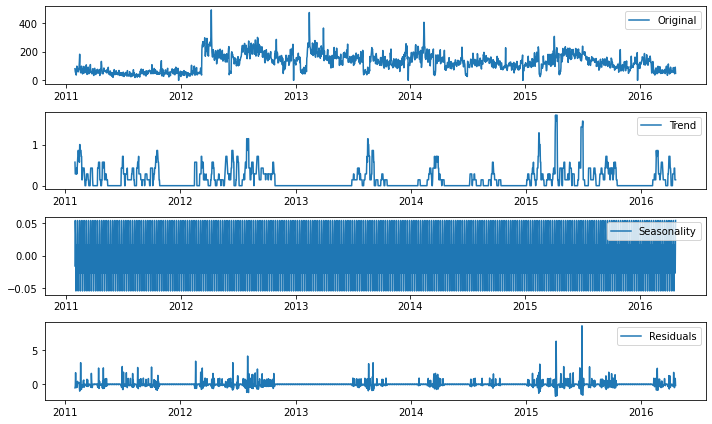

In [105]:
#for tatol number of sales across all items and stores (per day)
# Make a variable called decomposition, and assign it yt passed to seasonal_decompose() 
decomposition = seasonal_decompose(yt)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

Original sales (Top Plot):
The top plot shows the total daily sales over a period of several years.
We observe an increasing after 2012 which is due to the availabitily of some items after 2012 and then even trend over years.
There are also noticeable seasonal spikes, particularly during the begining of each year.

Trend Component (Second Plot):
The second plot displays the trend component, which smooths out the short-term fluctuations and highlights the long-term movement.
We can see a slightly upward trend with some downeard to zero for some periods.

Seasonal Component (Third Plot):
In the third plot, we see the seasonal component that captures the recurring patterns within each year.

Residual Component (Bottom Plot):
The bottom plot represents the residual component, which consists of random fluctuations and irregularities not explained by the trend or seasonality.
We can observe random spikes or dips in the residual plot, which could be due to one-time events, outliers, or measurement errors.
Analyzing the residuals helps us assess the model's goodness of fit and identify any unusual patterns that require further investigation.

Check the Decomposition for store 1 in TEXAS (TX_1)

In [12]:
# for a store (TX_1)
# Create a time series for TX_1 store 
stores=sales_wal.groupby(['date','store_id'])['sales'].sum().reset_index()
storeTX1=stores[stores['store_id']=='TX_1'][['date','sales']]
storeTX1['date'] = pd.to_datetime(storeTX1['date'], format='%m/%d/%y')
storeTX1.set_index('date',inplace=True)

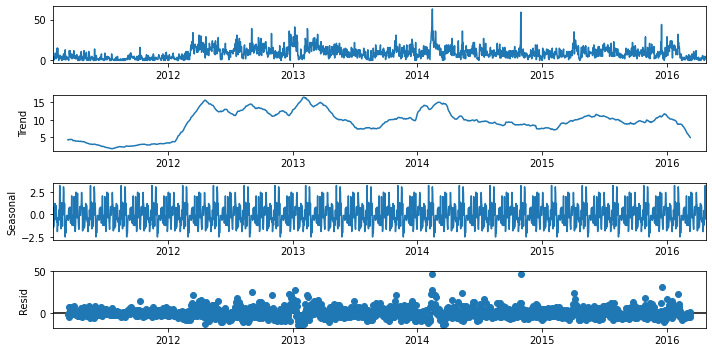

In [280]:
# Perform seasonal decomposition for TX_1
decomposition_sT1 = seasonal_decompose(storeTX1,period=90)
decomposition_sT1.plot()
plt.show()

### Testing for stationary

Check the stationary for store TX_1.

In [60]:
resultytx1=adfuller(storeTX1)
print('ADF Statistic:', resultytx1[0])
print('p-value:', resultytx1[1])

ADF Statistic: -7.42796644447617
p-value: 6.472974568717831e-11


since our p-value is less than 0.05, we should reject the Null hypothesis and the the data is non-stationary.

To make a time series data stationary, we typically need to perform transformations that remove trends and seasonality. One method is differencing our data. Subtract each observation from its previous observation. This is useful for removing linear trends.

In [63]:
resultytx1_diff=adfuller(storeTX1.diff().dropna())
print('ADF Statistic:', resultytx1_diff[0])
print('p-value:', resultytx1_diff[1])

ADF Statistic: -14.01813101065043
p-value: 3.611829021446357e-26


The p-value is still less than 0.05, indicating that the data remains non-stationary. Therefore, we need to use models that can handle non-stationary data effectively.

### 3-1 The ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) models are a popular choice for time series analysis due to their ability to capture both the autocorrelation and trend components present in the data. The ARIMA model is versatile and can handle a wide range of time series patterns, including stationary and non-stationary processes. 

In [8]:
# Import mean_squared_error and ARIMA
from statsmodels.tsa.arima.model import ARIMA

#### Make a function to find the MSE of a single ARIMA model

In [37]:
# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train['sales']]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test['sales'][i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

#### Make a function to evaluate different ARIMA models with several different p, d, and q values

In [78]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [79]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

##### Find the optimum ARIMA model for TX_1 store

In [365]:
# Finally, we can find the optimum ARIMA model for store TX_1.
import warnings
warnings.filterwarnings("ignore")
evaluate_models(storeTX1, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=37.403
ARIMA(0, 0, 1) MSE=31.925
ARIMA(0, 0, 2) MSE=30.182
ARIMA(0, 1, 0) MSE=39.728
ARIMA(0, 1, 1) MSE=27.012
ARIMA(0, 1, 2) MSE=26.853
ARIMA(0, 2, 0) MSE=114.796
ARIMA(0, 2, 1) MSE=39.753
ARIMA(0, 2, 2) MSE=27.032
ARIMA(1, 0, 0) MSE=29.449
ARIMA(1, 0, 1) MSE=26.261
ARIMA(1, 0, 2) MSE=26.241
ARIMA(1, 1, 0) MSE=32.111
ARIMA(1, 1, 1) MSE=26.815
ARIMA(1, 1, 2) MSE=27.025
ARIMA(1, 2, 0) MSE=67.622
ARIMA(1, 2, 1) MSE=32.129
ARIMA(1, 2, 2) MSE=26.840
ARIMA(2, 0, 0) MSE=27.893
ARIMA(2, 0, 1) MSE=26.239
ARIMA(2, 0, 2) MSE=26.309
ARIMA(2, 1, 0) MSE=29.803
ARIMA(2, 1, 1) MSE=26.736
ARIMA(2, 1, 2) MSE=26.244
ARIMA(2, 2, 0) MSE=53.572
ARIMA(2, 2, 1) MSE=29.821
Best ARIMA(2, 0, 1) MSE=26.239


The bset p,d,q parameters for our ARIMA model are 2,0,1. 

In [32]:
#Build the model with (2,0,1) parameters

model=ARIMA(storeTX1,order=(2,0,1),freq='D')
modelfit=model.fit()
forecast=(modelfit.forecast(28))

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


##### Model summary and results

In [75]:
modelfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5932.731
Date:                Mon, 22 Apr 2024   AIC                          11875.462
Time:                        11:29:20   BIC                          11903.244
Sample:                    01-29-2011   HQIC                         11885.686
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9780      0.994      9.036      0.000       7.031      10.925
ar.L1          0.9996      0.033     30.315      0.000       0.935       1.064
ar.L2         -0.0428      0.027     -1.585      0.113      -0.096       0.010
ma.L1         -0.7245      0.024    -29.629      0.000      -0.772      -0.677
sigma2        28.9114      0.574     50.363      0.000      27.786      30.037
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3626.26
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# ARIMA model MSE
mse_arima=evaluate_arima_model(storeTX1,(2,0,1))

/var/folders/vc/sq141_896sbc9xx8ypnnffm40000gn/T/ipykernel_22714/862023043.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  past.append(test['sales'][i])


In [84]:
rmse = np.sqrt(mse_arima)
print('mse= ',mse_arima, 'rmse= ',rmse)

mse=  26.238764878352914 rmse=  5.122378830031308


In [44]:
# Fit the ARIMA model
model = ARIMA(trainst1['sales'], order=(2,0,1),freq='D')
model_fit = model.fit()
# Make predictions
predictions= model_fit.predict(start=len(trainst1), end=len(trainst1)+len(testst1)-1)
# calculate out of sample error
rmse = np.sqrt(mean_squared_error(testst1['sales'], predictions))
print('rmse:',rmse)

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse: 6.0539588673079034


The ARIMA(2, 0, 1) model was applied to the sales data of TX_1 store, comprising 1913 observations. The log likelihood of -5932.731 indicates a good fit of the model to the data. The Akaike Information Criterion (AIC) of 11875.462 and Bayesian Information Criterion (BIC) of 11903.244, along with the Hannan-Quinn Information Criterion (HQIC) of 11885.686, suggest that this model strikes a balance between goodness of fit and complexity, with lower values indicating better model performance. The model's coefficients show a significant influence of the autoregressive (AR) and moving average (MA) terms on sales, as evidenced by their low p-values (<0.05). The Ljung-Box test indicates that the model captures autocorrelation well, with a high p-value (0.95) suggesting no significant autocorrelation in residuals. However, the Jarque-Bera test indicates a departure from normality in residuals, which might warrant further investigation. 
The root mean squared error (RMSE) of 5.12 suggests that the model's predictions are generally close to the actual sales values, considering that the mean sales for this store are around 9. This indicates a reasonably accurate fit of the model to the data, with deviations from the actual values being relatively small.

#### Visualize the result

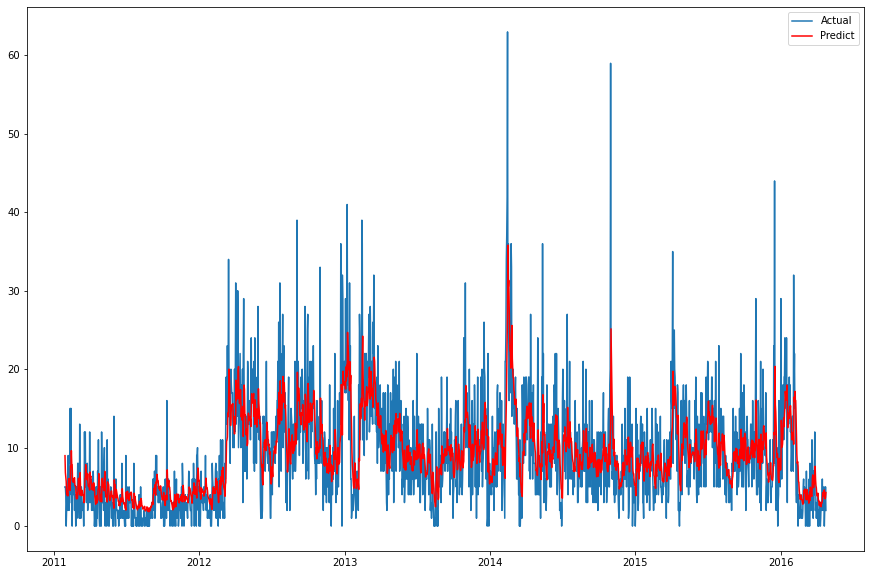

In [34]:
plt.figure(figsize=(15,10))
plt.plot(storeTX1['sales'], label='Actual')
plt.plot(modelfit.predict(), color = 'red',label='Predict')
plt.legend()

Overall, while the ARIMA(2, 0, 1) model demonstrates strong predictive power and captures autocorrelation effectively, the departure from normality in residuals suggests potential areas for refinement to enhance model accuracy.

To improve the result, we can incorporate additional variables that could influence sales, such as events, SNAP sales, or sell price. This can be achieved by using SARIMA (Seasonal ARIMA) models or including exogenous variables in the ARIMA model.

### 3-2 The SARIMA Model

SARIMA model is an extension of the ARIMA model that incorporates seasonality into the time series analysis. Incorporating a SARIMA model can lead to improved accuracy and reliability in forecasting time series data, especially when dealing with seasonal trends that impact the underlying patterns and behaviors.

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

##### Find Optimum Parameters

To fiind the best parameters for a SARIMA model for TX_1 store, we used grid search, to try different combinations of parameters and evaluate their performance using a metric such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). 

In [26]:
# Range of values for p, d, q
p_values = range(0, 3)  
d_values = range(0, 3)  
q_values = range(0, 3)  
P_values = range(0, 3)  
D_values = range(0, 3)  
Q_values = range(0, 3) 

#Seasonal period for monthly data
seasonal_periods = 12  

param_grid = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))

#Seasonal parameters with a yearly seasonality
#P = D = Q = range(0, 3) 
#seasonal_periods = 12
#param_grid = list(product(p, d_values, q_values, P_values, D_values, Q_values))

best_aic = np.inf
best_params = None

for params in param_grid:
    try:
        model = SARIMAX(storeTX1, order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], seasonal_periods))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

print("Best Parameters:", best_params)


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85652D+00    |proj g|=  7.62945D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.629D-08   3.857D+00
  F =   3.8565192377943309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.7

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73036D+00    |proj g|=  3.82523D-01

At iterate    5    f=  3.58761D+00    |proj g|=  1.22750D-01

At iterate   10    f=  3.54837D+00    |proj g|=  3.23755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   1.513D-07   3.548D+00
  F =   3.5483738757681653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48371D+00    |proj g|=  7.80691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.509D-07   3.484D+00
  F =   3.4837041919263916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27755D+00    |proj g|=  3.38152D-02

At iterate    5    f=  3.26789D+00    |proj g|=  1.24973D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.402D-06   3.268D+00
  F =   3.2678853817618054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98162D+00    |proj g|=  9.25272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   7.202D-06   3.982D+00
  F =   3.9815767759298049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.1

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43664D+00    |proj g|=  1.33313D-01

At iterate    5    f=  3.29280D+00    |proj g|=  2.89738D-03

At iterate   10    f=  3.28372D+00    |proj g|=  2.10649D-03

At iterate   15    f=  3.28307D+00    |proj g|=  2.36630D-04

At iterate   20    f=  3.28299D+00    |proj g|=  6.32700D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43981D+00    |proj g|=  2.60307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   3.145D-06   3.440D+00
  F =   3.4397859842403768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30952D+00    |proj g|=  2.79579D-02

At iterate   10    f=  3.28915D+00    |proj g|=  8.43914D-03

At iterate   15    f=  3.28744D+00    |proj g|=  3.40402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   5.069D-06   3.287D+00
  F =   3.2874444621920418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38442D+00    |proj g|=  1.14317D-03

At iterate    5    f=  3.38442D+00    |proj g|=  1.70052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   8.055D-07   3.384D+00
  F =   3.3844165155552370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30910D+00    |proj g|=  8.13839D-02

At iterate    5    f=  3.26778D+00    |proj g|=  4.98403D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.455D-06   3.268D+00
  F =   3.2676366865301505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27758D+00    |proj g|=  4.77811D-02

At iterate    5    f=  3.27011D+00    |proj g|=  1.24399D-02

At iterate   10    f=  3.26875D+00    |proj g|=  1.38380D-02

At iterate   15    f=  3.26762D+00    |proj g|=  4.93856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.637D-05   3.268D+00
  F =   3.2676133481973348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73295D+00    |proj g|=  8.01455D-04

At iterate    5    f=  3.73295D+00    |proj g|=  4.72002D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   3.069D-06   3.733D+00
  F =   3.7329513685010989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48150D+00    |proj g|=  9.04473D-02

At iterate    5    f=  3.39286D+00    |proj g|=  8.72589D-03

At iterate   10    f=  3.38517D+00    |proj g|=  7.55554D-04

At iterate   15    f=  3.38436D+00    |proj g|=  5.26807D-04

At iterate   20    f=  3.38427D+00    |proj g|=  5.40942D-05

At iterate   25    f=  3.38426D+00    |proj g|=  5.88227D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78660D+00    |proj g|=  5.10223D-01

At iterate    5    f=  3.44013D+00    |proj g|=  3.24467D-02

At iterate   10    f=  3.30242D+00    |proj g|=  2.96891D-02

At iterate   15    f=  3.28623D+00    |proj g|=  1.28351D-02

At iterate   20    f=  3.27764D+00    |proj g|=  5.10374D-03

At iterate   25    f=  3.27741D+00    |proj g|=  9.78117D-04

At iterate   30    f=  3.27740D+00    |proj g|=  1.43261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37684D+00    |proj g|=  2.40825D-03

At iterate    5    f=  3.37679D+00    |proj g|=  2.76112D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.761D-06   3.377D+00
  F =   3.3767923233093464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33692D+00    |proj g|=  9.31894D-02

At iterate    5    f=  3.30447D+00    |proj g|=  3.48228D-02

At iterate   10    f=  3.28808D+00    |proj g|=  2.90781D-03

At iterate   15    f=  3.28729D+00    |proj g|=  2.11056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   1.280D-06   3.287D+00
  F =   3.2872891918149487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36355D+00    |proj g|=  2.33988D-01

At iterate    5    f=  3.29689D+00    |proj g|=  3.21438D-02

At iterate   10    f=  3.29134D+00    |proj g|=  1.02705D-03

At iterate   15    f=  3.28889D+00    |proj g|=  2.51500D-02

At iterate   20    f=  3.28761D+00    |proj g|=  8.94787D-03

At iterate   25    f=  3.28729D+00    |proj g|=  2.02521D-04

At iterate   30    f=  3.28729D+00    |proj g|=  1.02755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34196D+00    |proj g|=  2.14218D-03

At iterate    5    f=  3.34195D+00    |proj g|=  1.30696D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   3.740D-06   3.342D+00
  F =   3.3419459717031934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31422D+00    |proj g|=  5.41047D-02

At iterate    5    f=  3.27038D+00    |proj g|=  1.06736D-02

At iterate   10    f=  3.26761D+00    |proj g|=  5.82634D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.258D-05   3.268D+00
  F =   3.2676141827559060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28649D+00    |proj g|=  6.74474D-02

At iterate    5    f=  3.26787D+00    |proj g|=  7.39869D-03

At iterate   10    f=  3.26750D+00    |proj g|=  1.41104D-04

At iterate   15    f=  3.26750D+00    |proj g|=  1.36605D-03

At iterate   20    f=  3.26744D+00    |proj g|=  4.63036D-04

At iterate   25    f=  3.26741D+00    |proj g|=  7.27509D-04

At iterate   30    f=  3.26741D+00    |proj g|=  1.95643D-04

At iterate   35    f=  3.26741D+00    |proj g|=  2.50983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62008D+00    |proj g|=  2.93251D-03

At iterate    5    f=  3.62007D+00    |proj g|=  8.59098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   7.504D-06   3.620D+00
  F =   3.6200645075604969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49958D+00    |proj g|=  1.49584D-01

At iterate    5    f=  3.39848D+00    |proj g|=  3.19958D-02

At iterate   10    f=  3.34714D+00    |proj g|=  8.13686D-03

At iterate   15    f=  3.34415D+00    |proj g|=  8.54000D-04

At iterate   20    f=  3.34368D+00    |proj g|=  1.00112D-03

At iterate   25    f=  3.34362D+00    |proj g|=  1.54606D-03

At iterate   30    f=  3.34362D+00    |proj g|=  6.17635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39425D+00    |proj g|=  7.69903D-02

At iterate    5    f=  3.34676D+00    |proj g|=  1.54036D-01

At iterate   10    f=  3.28290D+00    |proj g|=  4.55492D-02

At iterate   15    f=  3.27741D+00    |proj g|=  5.54623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.219D-05   3.277D+00
  F =   3.2774091778943464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66498D+00    |proj g|=  1.81295D-01

At iterate    5    f=  3.59026D+00    |proj g|=  1.31976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   3.349D-06   3.590D+00
  F =   3.5901243385561816     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59603D+00    |proj g|=  2.00673D-01

At iterate    5    f=  3.46923D+00    |proj g|=  3.70584D-01

At iterate   10    f=  3.42177D+00    |proj g|=  6.40641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   5.645D-06   3.422D+00
  F =   3.4217669846363385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.44021D+00    |proj g|=  2.50067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.855D-07   3.440D+00
  F =   3.4402064933078367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27788D+00    |proj g|=  5.45507D-02

At iterate    5    f=  3.21338D+00    |proj g|=  1.20505D-02

At iterate   10    f=  3.20790D+00    |proj g|=  3.22369D-05

       

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26407D+00    |proj g|=  4.91659D-02

At iterate    5    f=  3.20339D+00    |proj g|=  8.51196D-03

At iterate   10    f=  3.20332D+00    |proj g|=  1.99807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   4.217D-06   3.203D+00
  F =   3.2033152917304162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94399D+00    |proj g|=  1.50102D-02

At iterate    5    f=  3.94386D+00    |proj g|=  5.29819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   5.584D-06   3.944D+00
  F =   3.9438143042947842     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94399D+00    |proj g|=  6.18799D-01

At iterate    5    f=  3.45975D+00    |proj g|=  2.12874D-01

At iterate   10    f=  3.43917D+00    |proj g|=  2.09672D-03

At iterate   15    f=  3.43794D+00    |proj g|=  4.28146D-03

At iterate   20    f=  3.43754D+00    |proj g|=  5.63211D-04

At iterate   25    f=  3.43750D+00    |proj g|=  4.05799D-04

At iterate   30    f=  3.43750D+00    |proj g|=  5.02360D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60675D+00    |proj g|=  6.51427D-02

At iterate    5    f=  3.29885D+00    |proj g|=  5.12630D-02

At iterate   10    f=  3.22925D+00    |proj g|=  3.28126D-03

At iterate   15    f=  3.22057D+00    |proj g|=  1.74030D-02

At iterate   20    f=  3.21868D+00    |proj g|=  6.56613D-04

At iterate   25    f=  3.21856D+00    |proj g|=  1.46982D-03

At iterate   30    f=  3.21855D+00    |proj g|=  1.41394D-04

At iterate   35    f=  3.21855D+00    |proj g|=  2.52950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54236D+00    |proj g|=  5.31186D-02

At iterate    5    f=  3.37871D+00    |proj g|=  7.33668D-02

At iterate   10    f=  3.37065D+00    |proj g|=  9.62740D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   6.334D-07   3.371D+00
  F =   3.3706514171827253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  3.22572D+00    |proj g|=  6.79487D-03

At iterate   20    f=  3.22568D+00    |proj g|=  1.20814D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   1.208D-06   3.226D+00
  F =   3.2256774660869536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51522D+00    |proj g|=  7.23646D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.28871D+00    |proj g|=  1.04518D-01

At iterate   10    f=  3.23302D+00    |proj g|=  9.06231D-03

At iterate   15    f=  3.22427D+00    |proj g|=  1.63378D-02

At iterate   20    f=  3.22160D+00    |proj g|=  4.28959D-03

At iterate   25    f=  3.22155D+00    |proj g|=  4.30465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   2.110D-06   3.222D+00
  F =   3.2215491856793905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34603D+00    |proj g|=  2.76394D-02

At iterate    5    f=  3.33207D+00    |proj g|=  1.23144D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.073D-05   3.332D+00
  F =   3.3320649576730723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28835D+00    |proj g|=  6.71800D-02

At iterate    5    f=  3.20654D+00    |proj g|=  1.36936D-02

At iterate   10    f=  3.20313D+00    |proj g|=  5.78002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   3.638D-06   3.203D+00
  F =   3.2031241317450316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26573D+00    |proj g|=  4.87035D-02

At iterate    5    f=  3.20923D+00    |proj g|=  8.25669D-02

At iterate   10    f=  3.20484D+00    |proj g|=  5.68736D-03

At iterate   15    f=  3.20309D+00    |proj g|=  3.12688D-03

At iterate   20    f=  3.20306D+00    |proj g|=  8.99250D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   8.992D-06   3.203D+00
  F =   3.2030554690507564     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74722D+00    |proj g|=  3.12385D-02

At iterate    5    f=  3.68589D+00    |proj g|=  3.50062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   9.090D-06   3.686D+00
  F =   3.6858776560026905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62917D+00    |proj g|=  4.95905D-02

At iterate    5    f=  3.34239D+00    |proj g|=  6.45129D-02

At iterate   10    f=  3.33727D+00    |proj g|=  1.41377D-02

At iterate   15    f=  3.33277D+00    |proj g|=  3.88565D-03

At iterate   20    f=  3.33240D+00    |proj g|=  1.17541D-03

At iterate   25    f=  3.33232D+00    |proj g|=  2.60699D-04

At iterate   30    f=  3.33232D+00    |proj g|=  2.65663D-04

At iterate   35    f=  3.33232D+00    |proj g|=  3.19743D-05

At iterate   40    f=  3.33232D+00    |proj g|=  2.28424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75293D+00    |proj g|=  2.09887D-01

At iterate    5    f=  3.45336D+00    |proj g|=  1.71413D-01

At iterate   10    f=  3.41389D+00    |proj g|=  1.44348D-02

At iterate   15    f=  3.24470D+00    |proj g|=  3.95009D-02

At iterate   20    f=  3.23533D+00    |proj g|=  1.53884D-02

At iterate   25    f=  3.22188D+00    |proj g|=  2.09565D-02

At iterate   30    f=  3.21480D+00    |proj g|=  1.06208D-02

At iterate   35    f=  3.21452D+00    |proj g|=  4.70001D-04

At iterate   40    f=  3.21452D+00    |proj g|=  1.98233D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51976D+00    |proj g|=  5.72822D-02

At iterate    5    f=  3.31588D+00    |proj g|=  3.44836D-02

At iterate   10    f=  3.31289D+00    |proj g|=  8.03305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.561D-07   3.313D+00
  F =   3.3128911381218531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49795D+00    |proj g|=  6.09126D-02

At iterate    5    f=  3.26769D+00    |proj g|=  1.24922D-01

At iterate   10    f=  3.23937D+00    |proj g|=  1.43217D-02

At iterate   15    f=  3.22287D+00    |proj g|=  4.04596D-03

At iterate   20    f=  3.22143D+00    |proj g|=  3.12193D-03

At iterate   25    f=  3.22142D+00    |proj g|=  9.68874D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49805D+00    |proj g|=  6.07463D-02

At iterate    5    f=  3.30473D+00    |proj g|=  1.69572D-01

At iterate   10    f=  3.22539D+00    |proj g|=  3.37843D-03

At iterate   15    f=  3.22448D+00    |proj g|=  1.18104D-02

At iterate   20    f=  3.22423D+00    |proj g|=  6.89913D-04

At iterate   25    f=  3.22314D+00    |proj g|=  2.95937D-02

At iterate   30    f=  3.22144D+00    |proj g|=  3.79172D-03

At iterate   35    f=  3.22140D+00    |proj g|=  2.57720D-04

At iterate   40    f=  3.22140D+00    |proj g|=  2.64481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31320D+00    |proj g|=  3.61779D-02

At iterate    5    f=  3.28775D+00    |proj g|=  1.53728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   2.734D-05   3.288D+00
  F =   3.2877502509155971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29272D+00    |proj g|=  4.96999D-02

At iterate    5    f=  3.20579D+00    |proj g|=  1.68633D-02

At iterate   10    f=  3.20306D+00    |proj g|=  3.41894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   3.239D-06   3.203D+00
  F =   3.2030559460411441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27244D+00    |proj g|=  4.69116D-02

At iterate    5    f=  3.21165D+00    |proj g|=  1.30554D-02

At iterate   10    f=  3.20301D+00    |proj g|=  1.41265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   7.944D-06   3.203D+00
  F =   3.2030077739686487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68694D+00    |proj g|=  4.05585D-02

At iterate    5    f=  3.56894D+00    |proj g|=  2.27999D-02

At iterate   10    f=  3.56720D+00    |proj g|=  8.97802D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   8.978D-06   3.567D+00
  F =   3.5671977563978370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63740D+00    |proj g|=  6.09963D-02

At iterate    5    f=  3.30747D+00    |proj g|=  1.57985D-01

At iterate   10    f=  3.29138D+00    |proj g|=  8.61541D-04

At iterate   15    f=  3.29122D+00    |proj g|=  8.38624D-03

At iterate   20    f=  3.29007D+00    |proj g|=  1.12525D-03

At iterate   25    f=  3.28990D+00    |proj g|=  1.28203D-03

At iterate   30    f=  3.28987D+00    |proj g|=  2.56610D-04

At iterate   35    f=  3.28987D+00    |proj g|=  2.74185D-05

At iterate   40    f=  3.28987D+00    |proj g|=  4.83320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61002D+00    |proj g|=  5.45153D-02


 This problem is unconstrained.



At iterate    5    f=  3.31038D+00    |proj g|=  1.52892D-01

At iterate   10    f=  3.21707D+00    |proj g|=  3.12176D-02

At iterate   15    f=  3.21451D+00    |proj g|=  4.99755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   8.303D-06   3.215D+00
  F =   3.2145114564885140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59401D+00    |proj g|=  1.79520D-01

At iterate    5    f=  3.48564D+00    |proj g|=  3.05805D-01

At iterate   10    f=  3.45401D+00    |proj g|=  4.65274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   8.411D-06   3.454D+00
  F =   3.4540050774122064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.38839D+00    |proj g|=  2.44876D-01

At iterate   10    f=  3.34466D+00    |proj g|=  1.78844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   8.901D-06   3.345D+00
  F =   3.3446533543416330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42116D+00    |proj g|=  4.52163D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate    5    f=  3.41997D+00    |proj g|=  1.81736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.842D-06   3.420D+00
  F =   3.4199719510407056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25215D+00    |proj g|=  5.77488D-02


 This problem is unconstrained.



At iterate    5    f=  3.17484D+00    |proj g|=  8.24966D-03

At iterate   10    f=  3.17103D+00    |proj g|=  5.36069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   3.326D-05   3.171D+00
  F =   3.1710237790034923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23823D+00    |proj g|=  5.20482D-02

At iterate    5    f=  3.16813D+00    |proj g|=  4.11035D-03

At iterate   10    f=  3.16812D+00    |proj g|=  3.10626D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   2.588D-06   3.168D+00
  F =   3.1681177383118051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93016D+00    |proj g|=  4.72707D-02

At iterate    5    f=  3.92915D+00    |proj g|=  4.74149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   7.094D-06   3.929D+00
  F =   3.9291006737637484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93016D+00    |proj g|=  6.31646D-01

At iterate    5    f=  3.45703D+00    |proj g|=  8.85656D-02

At iterate   10    f=  3.41945D+00    |proj g|=  1.20984D-03

At iterate   15    f=  3.41801D+00    |proj g|=  6.98432D-03

At iterate   20    f=  3.41745D+00    |proj g|=  2.48047D-03

At iterate   25    f=  3.41740D+00    |proj g|=  5.39915D-04

At iterate   30    f=  3.41739D+00    |proj g|=  4.96868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58953D+00    |proj g|=  6.68049D-02

At iterate    5    f=  3.28765D+00    |proj g|=  3.27072D-02

At iterate   10    f=  3.19784D+00    |proj g|=  3.75207D-03

At iterate   15    f=  3.18934D+00    |proj g|=  2.94266D-02

At iterate   20    f=  3.18318D+00    |proj g|=  7.84606D-04

At iterate   25    f=  3.18293D+00    |proj g|=  2.51242D-04

At iterate   30    f=  3.18291D+00    |proj g|=  3.31251D-04

At iterate   35    f=  3.18291D+00    |proj g|=  1.87509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52909D+00    |proj g|=  6.88449D-02

At iterate    5    f=  3.36208D+00    |proj g|=  1.11644D-01

At iterate   10    f=  3.32666D+00    |proj g|=  2.72916D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   4.756D-06   3.327D+00
  F =   3.3266507785052997     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48236D+00    |proj g|=  6.28346D-02

At iterate    5    f=  3.20291D+00    |proj g|=  6.18515D-02

At iterate   10    f=  3.19706D+00    |proj g|=  2.40551D-02

At iterate   15    f=  3.18824D+00    |proj g|=  3.27889D-03

At iterate   20    f=  3.18798D+00    |proj g|=  5.14199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   1.508D-05   3.188D+00
  F =   3.1879761695504971     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.24235D+00    |proj g|=  1.29094D-01

At iterate   10    f=  3.19697D+00    |proj g|=  7.99973D-03

At iterate   15    f=  3.18690D+00    |proj g|=  3.77209D-02

At iterate   20    f=  3.18560D+00    |proj g|=  8.30185D-03

At iterate   25    f=  3.18544D+00    |proj g|=  3.36476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   1.753D-06   3.185D+00
  F =   3.1854432012063412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31858D+00    |proj g|=  3.05389D-02

At iterate    5    f=  3.30198D+00    |proj g|=  2.77913D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   8.450D-06   3.301D+00
  F =   3.3009916976036506     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26173D+00    |proj g|=  7.11120D-02

At iterate    5    f=  3.16906D+00    |proj g|=  1.77777D-02

At iterate   10    f=  3.16789D+00    |proj g|=  2.84650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   8.512D-07   3.168D+00
  F =   3.1678802969861870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23982D+00    |proj g|=  5.15944D-02

At iterate    5    f=  3.17753D+00    |proj g|=  1.85842D-02

At iterate   10    f=  3.16972D+00    |proj g|=  1.38926D-03

At iterate   15    f=  3.16901D+00    |proj g|=  2.32123D-02

At iterate   20    f=  3.16766D+00    |proj g|=  7.46807D-03

At iterate   25    f=  3.16742D+00    |proj g|=  1.01178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72565D+00    |proj g|=  3.27951D-02

At iterate    5    f=  3.65979D+00    |proj g|=  2.63840D-02

At iterate   10    f=  3.65797D+00    |proj g|=  3.44706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     17      1     0     0   6.383D-06   3.658D+00
  F =   3.6579721855245917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61084D+00    |proj g|=  5.09203D-02

At iterate    5    f=  3.43308D+00    |proj g|=  1.33928D-01

At iterate   10    f=  3.31326D+00    |proj g|=  7.54945D-02

At iterate   15    f=  3.30467D+00    |proj g|=  4.22134D-03

At iterate   20    f=  3.30214D+00    |proj g|=  7.42437D-03

At iterate   25    f=  3.30163D+00    |proj g|=  3.48075D-03

At iterate   30    f=  3.30154D+00    |proj g|=  4.92502D-04

At iterate   35    f=  3.30153D+00    |proj g|=  2.49595D-04

At iterate   40    f=  3.30153D+00    |proj g|=  1.40916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73258D+00    |proj g|=  2.13748D-01

At iterate    5    f=  3.41313D+00    |proj g|=  1.22783D-01

At iterate   10    f=  3.38381D+00    |proj g|=  3.33376D-02

At iterate   15    f=  3.28076D+00    |proj g|=  2.39095D-01

At iterate   20    f=  3.22358D+00    |proj g|=  2.29776D-02

At iterate   25    f=  3.18898D+00    |proj g|=  2.86903D-02

At iterate   30    f=  3.18060D+00    |proj g|=  6.36175D-03

At iterate   35    f=  3.18034D+00    |proj g|=  3.67891D-04

At iterate   40    f=  3.18033D+00    |proj g|=  2.77515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50389D+00    |proj g|=  5.93909D-02

At iterate    5    f=  3.28577D+00    |proj g|=  1.25604D-01

At iterate   10    f=  3.27184D+00    |proj g|=  8.04372D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   3.581D-06   3.272D+00
  F =   3.2718384753600849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.24224D+00    |proj g|=  2.22707D-01

At iterate   10    f=  3.20519D+00    |proj g|=  1.50797D-02

At iterate   15    f=  3.19478D+00    |proj g|=  5.39323D-02

At iterate   20    f=  3.18564D+00    |proj g|=  5.04469D-03

At iterate   25    f=  3.18526D+00    |proj g|=  9.98484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   6.780D-06   3.185D+00
  F =   3.1852608699249729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47955D+00    |proj g|=  6.33475D-02

At iterate    5    f=  3.22151D+00    |proj g|=  9.45372D-02

At iterate   10    f=  3.18759D+00    |proj g|=  8.45596D-03

At iterate   15    f=  3.18747D+00    |proj g|=  2.85073D-04

At iterate   20    f=  3.18745D+00    |proj g|=  1.90511D-03

At iterate   25    f=  3.18735D+00    |proj g|=  3.64752D-03

At iterate   30    f=  3.18643D+00    |proj g|=  9.18447D-03

At iterate   35    f=  3.18530D+00    |proj g|=  6.93384D-03

At iterate   40    f=  3.18502D+00    |proj g|=  1.11714D-03

At iterate   45    f=  3.18497D+00    |proj g|=  2.97184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28779D+00    |proj g|=  4.38560D-02

At iterate    5    f=  3.25794D+00    |proj g|=  5.74470D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   4.408D-07   3.258D+00
  F =   3.2578908854517379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26665D+00    |proj g|=  5.85507D-02

At iterate    5    f=  3.17002D+00    |proj g|=  1.05529D-02

At iterate   10    f=  3.16757D+00    |proj g|=  6.16942D-03

At iterate   15    f=  3.16740D+00    |proj g|=  1.23755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   1.238D-05   3.167D+00
  F =   3.1673974162348624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24670D+00    |proj g|=  4.97251D-02

At iterate    5    f=  3.17648D+00    |proj g|=  3.91816D-02

At iterate   10    f=  3.16939D+00    |proj g|=  4.55627D-02

At iterate   15    f=  3.16743D+00    |proj g|=  2.59252D-04

At iterate   20    f=  3.16736D+00    |proj g|=  1.48586D-03

At iterate   25    f=  3.16736D+00    |proj g|=  1.62761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66688D+00    |proj g|=  4.20195D-02

At iterate    5    f=  3.53937D+00    |proj g|=  2.75872D-02

At iterate   10    f=  3.53829D+00    |proj g|=  1.87192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   2.014D-06   3.538D+00
  F =   3.5382939760306713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61864D+00    |proj g|=  6.07035D-02

At iterate    5    f=  3.28082D+00    |proj g|=  1.26044D-01

At iterate   10    f=  3.26177D+00    |proj g|=  2.39515D-03

At iterate   15    f=  3.26165D+00    |proj g|=  1.01381D-02

At iterate   20    f=  3.26052D+00    |proj g|=  5.27426D-03

At iterate   25    f=  3.26030D+00    |proj g|=  1.12093D-03

At iterate   30    f=  3.26027D+00    |proj g|=  1.65335D-03

At iterate   35    f=  3.26027D+00    |proj g|=  2.22089D-04

At iterate   40    f=  3.26027D+00    |proj g|=  4.81027D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59251D+00    |proj g|=  5.57932D-02

At iterate    5    f=  3.34673D+00    |proj g|=  2.11897D-01

At iterate   10    f=  3.24463D+00    |proj g|=  9.71864D-02

At iterate   15    f=  3.18486D+00    |proj g|=  2.39793D-02

At iterate   20    f=  3.18001D+00    |proj g|=  6.23168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     29      1     0     0   5.049D-05   3.180D+00
  F =   3.1800072234566672     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmod

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31166D+00    |proj g|=  7.84148D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   2.914D-06   3.312D+00
  F =   3.3116552629955143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

 This problem is unconstrained.


 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31097D+00    |proj g|=  4.77262D-03

At iterate    5    f=  3.31083D+00    |proj g|=  5.93695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   4.262D-06   3.311D+00
  F =   3.3108307497074625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61831D+00    |

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38364D+00    |proj g|=  7.38804D-02

At iterate    5    f=  3.30973D+00    |proj g|=  3.58796D-03

At iterate   10    f=  3.30625D+00    |proj g|=  3.49491D-04

At iterate   15    f=  3.30610D+00    |proj g|=  1.23554D-04

At iterate   20    f=  3.30608D+00    |proj g|=  7.38087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     23      1     0     0   6.239D-06   3.306D+00
  F =   3.3060835619498383     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35824D+00    |proj g|=  3.29531D-02

At iterate    5    f=  3.31226D+00    |proj g|=  7.25638D-03

At iterate   10    f=  3.30575D+00    |proj g|=  2.58993D-04

At iterate   15    f=  3.30545D+00    |proj g|=  1.11399D-04

At iterate   20    f=  3.30541D+00    |proj g|=  3.70378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   5.760D-05   3.305D+00
  F =   3.3054081939469175     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13558D+00    |proj g|=  8.23148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   4.492D-06   4.136D+00
  F =   4.1355339132550277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.2

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61149D+00    |proj g|=  1.16456D-01

At iterate    5    f=  3.33142D+00    |proj g|=  2.96271D-03

At iterate   10    f=  3.32989D+00    |proj g|=  4.65207D-04

At iterate   15    f=  3.32690D+00    |proj g|=  6.75207D-04

At iterate   20    f=  3.32619D+00    |proj g|=  8.80596D-05

At iterate   25    f=  3.32614D+00    |proj g|=  1.71538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31093D+00    |proj g|=  8.00604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.998D-06   3.311D+00
  F =   3.3109205408111841     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.31084D+00    |proj g|=  1.43872D-03

At iterate   10    f=  3.31084D+00    |proj g|=  5.93608D-04

At iterate   15    f=  3.31081D+00    |proj g|=  2.94977D-03

At iterate   20    f=  3.31080D+00    |proj g|=  2.56233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     36      1     0     0   2.562D-05   3.311D+00
  F =   3.3107958414319900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.48438D+00    |proj g|=  1.76672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   9.566D-07   3.484D+00
  F =   3.4843798493543101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42054D+00    |proj g|=  1.09765D-01


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.31215D+00    |proj g|=  6.81631D-03

At iterate   10    f=  3.30570D+00    |proj g|=  1.82558D-03

At iterate   15    f=  3.30542D+00    |proj g|=  3.56122D-04

At iterate   20    f=  3.30539D+00    |proj g|=  6.29913D-05

At iterate   25    f=  3.30539D+00    |proj g|=  4.45904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     31      1     0     0   8.579D-06   3.305D+00
  F =   3.3053891319352871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34664D+00    |proj g|=  5.32288D-02

At iterate    5    f=  3.30610D+00    |proj g|=  8.43868D-04

At iterate   10    f=  3.30601D+00    |proj g|=  5.02668D-04

At iterate   15    f=  3.30600D+00    |proj g|=  2.27762D-04

At iterate   20    f=  3.30591D+00    |proj g|=  7.80455D-03

At iterate   25    f=  3.30540D+00    |proj g|=  1.77834D-03

At iterate   30    f=  3.30536D+00    |proj g|=  4.55231D-04

At iterate   35    f=  3.30536D+00    |proj g|=  1.37886D-04

At iterate   40    f=  3.30536D+00    |proj g|=  1.07697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85000D+00    |proj g|=  9.73183D-04

At iterate    5    f=  3.85000D+00    |proj g|=  6.10379D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   4.463D-06   3.850D+00
  F =   3.8500006844110728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61871D+00    |proj g|=  9.96950D-02

At iterate    5    f=  3.48901D+00    |proj g|=  1.25711D-02

At iterate   10    f=  3.48462D+00    |proj g|=  1.05324D-03

At iterate   15    f=  3.48395D+00    |proj g|=  4.12062D-04

At iterate   20    f=  3.48385D+00    |proj g|=  7.24594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   8.832D-06   3.484D+00
  F =   3.4838505767671313     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87930D+00    |proj g|=  4.60856D-01

At iterate    5    f=  3.56106D+00    |proj g|=  5.90118D-02

At iterate   10    f=  3.34662D+00    |proj g|=  4.65189D-02

At iterate   15    f=  3.33125D+00    |proj g|=  8.99411D-03

At iterate   20    f=  3.32645D+00    |proj g|=  1.05785D-03

At iterate   25    f=  3.32558D+00    |proj g|=  2.00612D-03

At iterate   30    f=  3.32551D+00    |proj g|=  7.01499D-04

At iterate   35    f=  3.32551D+00    |proj g|=  7.23874D-05

At iterate   40    f=  3.32550D+00    |proj g|=  4.87534D-04

At iterate   45    f=  3.32549D+00    |proj g|=  5.07073D-04

At iterate   50    f=  3.32548D+00    |proj g|=  1.84665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31086D+00    |proj g|=  9.15114D-04

At iterate    5    f=  3.31085D+00    |proj g|=  5.20566D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.206D-06   3.311D+00
  F =   3.3108487878409116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31087D+00    |proj g|=  1.48902D-03

At iterate    5    f=  3.31085D+00    |proj g|=  2.49149D-04

At iterate   10    f=  3.31085D+00    |proj g|=  9.41422D-04

At iterate   15    f=  3.31082D+00    |proj g|=  3.38019D-03

At iterate   20    f=  3.31081D+00    |proj g|=  1.31337D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   5.795D-06   3.311D+00
  F =   3.3108093253030422     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31098D+00    |proj g|=  4.21153D-03

At iterate    5    f=  3.31084D+00    |proj g|=  4.56500D-04

At iterate   10    f=  3.31081D+00    |proj g|=  5.07536D-03

At iterate   15    f=  3.31076D+00    |proj g|=  6.37335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   6.373D-05   3.311D+00
  F =   3.3107639539320575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.43521D+00    |proj g|=  9.08509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.576D-06   3.435D+00
  F =   3.4352059090484990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42216D+00    |proj g|=  5.49781D-02

At iterate    5    f=  3.32275D+00    |proj g|=  2.16433D-02

At iterate   10    f=  3.30704D+00    |proj g|=  2.86980D-03

At iterate   15    f=  3.30550D+00    |proj g|=  3.52215D-03

At iterate   20    f=  3.30534D+00    |proj g|=  4.74371D-04

At iterate   25    f=  3.30533D+00    |proj g|=  2.11478D-04

At iterate   30    f=  3.30533D+00    |proj g|=  7.79350D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36427D+00    |proj g|=  7.24792D-02

At iterate    5    f=  3.30835D+00    |proj g|=  2.53879D-02

At iterate   10    f=  3.30548D+00    |proj g|=  8.15228D-04

At iterate   15    f=  3.30541D+00    |proj g|=  7.85803D-04

At iterate   20    f=  3.30531D+00    |proj g|=  1.94814D-03

At iterate   25    f=  3.30517D+00    |proj g|=  2.54959D-03

At iterate   30    f=  3.30504D+00    |proj g|=  2.28184D-04

At iterate   35    f=  3.30501D+00    |proj g|=  1.15534D-05

At iterate   40    f=  3.30501D+00    |proj g|=  1.15532D-04

At iterate   45    f=  3.30500D+00    |proj g|=  4.51841D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.30500D+00    |proj g|=  2.44108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   2.441D-04   3.305D+00
  F =   3.3050017263754037     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71864D+00    |proj g|=  3.06617D-03

At iterate    5    f=  3.71862D+00    |proj g|=  1.01514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   6.376D-07   3.719D+00
  F =   3.7186200616586449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64000D+00    |proj g|=  1.74334D-01

At iterate    5    f=  3.48656D+00    |proj g|=  3.38390D-02

At iterate   10    f=  3.43831D+00    |proj g|=  2.94582D-03

At iterate   15    f=  3.43687D+00    |proj g|=  1.60764D-03

At iterate   20    f=  3.43667D+00    |proj g|=  3.33055D-04

At iterate   25    f=  3.43664D+00    |proj g|=  2.60556D-04

At iterate   30    f=  3.43664D+00    |proj g|=  1.85247D-04

At iterate   35    f=  3.43664D+00    |proj g|=  6.46132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74689D+00    |proj g|=  4.63903D-01

At iterate    5    f=  3.49586D+00    |proj g|=  5.35766D-02

At iterate   10    f=  3.47354D+00    |proj g|=  2.02751D-02

At iterate   15    f=  3.41205D+00    |proj g|=  1.00554D-01

At iterate   20    f=  3.34583D+00    |proj g|=  5.90452D-02

At iterate   25    f=  3.33047D+00    |proj g|=  8.31058D-03

At iterate   30    f=  3.32580D+00    |proj g|=  1.08267D-02

At iterate   35    f=  3.32545D+00    |proj g|=  1.62691D-03

At iterate   40    f=  3.32542D+00    |proj g|=  3.15144D-04

At iterate   45    f=  3.32541D+00    |proj g|=  6.45050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11900D+00    |proj g|=  5.65063D-02

At iterate    5    f=  3.11062D+00    |proj g|=  4.21134D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   4.211D-06   3.111D+00
  F =   3.1106165488415298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11919D+00    |proj g|=  5.47745D-02

At iterate    5    f=  3.11072D+00    |proj g|=  6.91158D-03

At iterate   10    f=  3.11060D+00    |proj g|=  1.99640D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.996D-06   3.111D+00
  F =   3.1105996983181030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24472D+00    |proj g|=  5.58557D-02

At iterate    5    f=  3.10991D+00    |proj g|=  3.67021D-03

At iterate   10    f=  3.10612D+00    |proj g|=  6.72049D-04

At iterate   15    f=  3.10592D+00    |proj g|=  7.83437D-05

At iterate   20    f=  3.10589D+00    |proj g|=  4.16512D-05

At iterate   25    f=  3.10589D+00    |proj g|=  8.42943D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22695D+00    |proj g|=  5.83880D-02

At iterate    5    f=  3.12366D+00    |proj g|=  2.07051D-02

At iterate   10    f=  3.11148D+00    |proj g|=  3.21144D-02

At iterate   15    f=  3.10620D+00    |proj g|=  7.35234D-03

At iterate   20    f=  3.10592D+00    |proj g|=  1.40649D-03

At iterate   25    f=  3.10589D+00    |proj g|=  2.04708D-04

At iterate   30    f=  3.10589D+00    |proj g|=  1.04908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95910D+00    |proj g|=  4.20155D-02

At iterate    5    f=  3.95569D+00    |proj g|=  2.36301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   2.372D-06   3.956D+00
  F =   3.9556619287730834     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    0    f=  3.95910D+00    |proj g|=  6.41480D-01

At iterate    5    f=  3.43900D+00    |proj g|=  7.98908D-03

At iterate   10    f=  3.43631D+00    |proj g|=  5.25822D-03

At iterate   15    f=  3.43260D+00    |proj g|=  1.02792D-04

At iterate   20    f=  3.43237D+00    |proj g|=  1.04763D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   9.231D-06   3.432D+00
  F =   3.4323425063765995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61445D+00    |proj g|=  6.60390D-02


 This problem is unconstrained.



At iterate    5    f=  3.13433D+00    |proj g|=  3.79155D-03

At iterate   10    f=  3.13324D+00    |proj g|=  1.12163D-02

At iterate   15    f=  3.13201D+00    |proj g|=  4.93119D-04

At iterate   20    f=  3.12946D+00    |proj g|=  9.17069D-03

At iterate   25    f=  3.12755D+00    |proj g|=  1.21110D-03

At iterate   30    f=  3.12747D+00    |proj g|=  9.20010D-05

At iterate   35    f=  3.12746D+00    |proj g|=  1.23437D-04

At iterate   40    f=  3.12745D+00    |proj g|=  6.89154D-04

At iterate   45    f=  3.12745D+00    |proj g|=  1.09697D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     79   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(da

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11913D+00    |proj g|=  5.50104D-02

At iterate    5    f=  3.11071D+00    |proj g|=  7.66675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   5.197D-06   3.111D+00
  F =   3.1106142667212433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.11068D+00    |proj g|=  7.89229D-03

At iterate   10    f=  3.11060D+00    |proj g|=  1.42317D-04

At iterate   15    f=  3.11060D+00    |proj g|=  2.22776D-04

At iterate   20    f=  3.11058D+00    |proj g|=  2.11560D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   1.184D-05   3.111D+00
  F =   3.1105849160042536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32236D+00    |proj g|=  3.86699D-02

At iterate    5    f=  3.29626D+00    |proj g|=  9.35404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   8.708D-06   3.296D+00
  F =   3.2962494639477384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22859D+00    |proj g|=  5.78987D-02

At iterate    5    f=  3.10681D+00    |proj g|=  9.29977D-03

At iterate   10    f=  3.10611D+00    |proj g|=  3.13049D-03

At iterate   15    f=  3.10578D+00    |proj g|=  5.97777D-04

At iterate   20    f=  3.10556D+00    |proj g|=  5.87935D-04

At iterate   25    f=  3.10539D+00    |proj g|=  4.96964D-04

At iterate   30    f=  3.10533D+00    |proj g|=  4.45891D-04

At iterate   35    f=  3.10531D+00    |proj g|=  2.12225D-04

At iterate   40    f=  3.10531D+00    |proj g|=  3.49640D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74737D+00    |proj g|=  3.30169D-02

At iterate    5    f=  3.67047D+00    |proj g|=  6.67463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.917D-07   3.670D+00
  F =   3.6703488328757308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63943D+00    |proj g|=  4.94557D-02

At iterate    5    f=  3.30031D+00    |proj g|=  6.05749D-03

At iterate   10    f=  3.29899D+00    |proj g|=  5.35462D-03

At iterate   15    f=  3.29711D+00    |proj g|=  4.05421D-03

At iterate   20    f=  3.29697D+00    |proj g|=  2.95948D-04

At iterate   25    f=  3.29695D+00    |proj g|=  6.99714D-05

At iterate   30    f=  3.29695D+00    |proj g|=  4.20312D-05

At iterate   35    f=  3.29695D+00    |proj g|=  7.05786D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74764D+00    |proj g|=  1.95334D-01

At iterate    5    f=  3.41459D+00    |proj g|=  3.54169D-02

At iterate   10    f=  1.39275D+00    |proj g|=  4.39886D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     63      2     0     0   4.399D+05   1.393D+00
  F =   1.3927476409957720     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11917D+00    |proj g|=  5.47874D-02

At iterate    5    f=  3.11074D+00    |proj g|=  6.45316D-03

At iterate   10    f=  3.11060D+00    |proj g|=  1.82383D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.824D-06   3.111D+00
  F =   3.1105987413747025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.11069D+00    |proj g|=  9.18648D-03

At iterate   10    f=  3.11060D+00    |proj g|=  2.71453D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.715D-05   3.111D+00
  F =   3.1105981469721642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11919D+00    |proj g|=  5.47779D-02

At iterate    5    f=  3.11085D+00    |proj g|=  5.51100D-03

At iterate   10    f=  3.11060D+00    |proj g|=  8.05433D-05

At iterate   15    f=  3.11060D+00    |proj g|=  9.34606D-04

At iterate   20    f=  3.11056D+00    |proj g|=  1.44432D-03

At iterate   25    f=  3.11049D+00    |proj g|=  9.12065D-03

At iterate   30    f=  3.11004D+00    |proj g|=  2.36257D-03

At iterate   35    f=  3.10994D+00    |proj g|=  1.13851D-02

At iterate   40    f=  3.10946D+00    |proj g|=  2.33424D-02

At iterate   45    f=  3.10909D+00    |proj g|=  6.59434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28455D+00    |proj g|=  4.30662D-02

At iterate    5    f=  3.24164D+00    |proj g|=  5.14638D-02

At iterate   10    f=  3.23990D+00    |proj g|=  9.50133D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.501D-06   3.240D+00
  F =   3.2398994810866446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27449D+00    |proj g|=  4.98286D-02

At iterate    5    f=  3.14939D+00    |proj g|=  3.74285D-02

At iterate   10    f=  3.11269D+00    |proj g|=  6.55875D-03

At iterate   15    f=  3.10640D+00    |proj g|=  7.46150D-03

At iterate   20    f=  3.10593D+00    |proj g|=  1.22333D-03

At iterate   25    f=  3.10586D+00    |proj g|=  3.66931D-04

At iterate   30    f=  3.10586D+00    |proj g|=  1.24961D-04

At iterate   35    f=  3.10586D+00    |proj g|=  2.84567D-04

At iterate   40    f=  3.10585D+00    |proj g|=  1.10326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23948D+00    |proj g|=  5.49696D-02

At iterate    5    f=  3.10728D+00    |proj g|=  1.50045D-02

At iterate   10    f=  3.10609D+00    |proj g|=  1.23823D-03

At iterate   15    f=  3.10580D+00    |proj g|=  2.81567D-03

At iterate   20    f=  3.10555D+00    |proj g|=  9.03227D-04

At iterate   25    f=  3.10541D+00    |proj g|=  3.75498D-03

At iterate   30    f=  3.10532D+00    |proj g|=  2.58453D-04

At iterate   35    f=  3.10530D+00    |proj g|=  1.01361D-04

At iterate   40    f=  3.10530D+00    |proj g|=  1.93024D-04

At iterate   45    f=  3.10530D+00    |proj g|=  5.47264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68538D+00    |proj g|=  4.24604D-02

At iterate    5    f=  3.56142D+00    |proj g|=  1.42057D-01

At iterate   10    f=  3.53879D+00    |proj g|=  1.43761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   9.215D-06   3.539D+00
  F =   3.5387908827011767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65171D+00    |proj g|=  7.09874D-02

At iterate    5    f=  3.28645D+00    |proj g|=  5.48049D-02

At iterate   10    f=  3.24403D+00    |proj g|=  2.66417D-03

At iterate   15    f=  3.24388D+00    |proj g|=  6.22633D-03

At iterate   20    f=  3.24290D+00    |proj g|=  1.21960D-03

At iterate   25    f=  3.24274D+00    |proj g|=  4.70759D-04

At iterate   30    f=  3.24272D+00    |proj g|=  3.93370D-04

At iterate   35    f=  3.24271D+00    |proj g|=  1.78526D-04

At iterate   40    f=  3.24271D+00    |proj g|=  5.25523D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69143D+00    |proj g|=  1.67976D-01

At iterate    5    f=  3.32472D+00    |proj g|=  3.61896D-02

At iterate   10    f=  3.29403D+00    |proj g|=  2.63946D-03

At iterate   15    f=  3.26276D+00    |proj g|=  1.00966D-01

At iterate   20    f=  3.22597D+00    |proj g|=  2.58505D-02

At iterate   25    f=  3.16495D+00    |proj g|=  2.46147D-02

At iterate   30    f=  3.13381D+00    |proj g|=  5.87566D-03

At iterate   35    f=  3.12768D+00    |proj g|=  5.26180D-04

At iterate   40    f=  3.12743D+00    |proj g|=  6.85142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11263D+00    |proj g|=  2.97528D-02

At iterate    5    f=  3.10899D+00    |proj g|=  5.08799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   8.776D-07   3.109D+00
  F =   3.1089923138851958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11307D+00    |proj g|=  2.94671D-02

At iterate    5    f=  3.10898D+00    |proj g|=  1.63889D-03

At iterate   10    f=  3.10896D+00    |proj g|=  8.40172D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.402D-07   3.109D+00
  F =   3.1089626007753606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43497D+00    |proj g|=  1.82883D-02

At iterate    5    f=  3.43393D+00    |proj g|=  1.00750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.969D-06   3.434D+00
  F =   3.4339123570308563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.11417D+00    |proj g|=  2.18026D-02

At iterate   10    f=  3.10515D+00    |proj g|=  7.44314D-03

At iterate   15    f=  3.10449D+00    |proj g|=  8.90983D-04

At iterate   20    f=  3.10442D+00    |proj g|=  1.71611D-04

At iterate   25    f=  3.10441D+00    |proj g|=  2.54709D-04

At iterate   30    f=  3.10441D+00    |proj g|=  9.12572D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   9.126D-06   3.104D+00
  F =   3.1044071327743450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21954D+00    |proj g|=  5.84369D-02

At iterate    5    f=  3.12027D+00    |proj g|=  2.20230D-02

At iterate   10    f=  3.11022D+00    |proj g|=  3.30234D-02

At iterate   15    f=  3.10485D+00    |proj g|=  6.96377D-03

At iterate   20    f=  3.10446D+00    |proj g|=  3.10489D-03

At iterate   25    f=  3.10441D+00    |proj g|=  3.73939D-04

At iterate   30    f=  3.10441D+00    |proj g|=  3.46609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95520D+00    |proj g|=  1.42186D-02

At iterate    5    f=  3.95460D+00    |proj g|=  7.98946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.083D-06   3.955D+00
  F =   3.9545667648837086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95520D+00    |proj g|=  6.43900D-01

At iterate    5    f=  3.44149D+00    |proj g|=  8.54648D-02

At iterate   10    f=  3.43563D+00    |proj g|=  2.90994D-03

At iterate   15    f=  3.43199D+00    |proj g|=  3.53856D-04

At iterate   20    f=  3.43135D+00    |proj g|=  7.70286D-04

At iterate   25    f=  3.43126D+00    |proj g|=  2.14392D-04

At iterate   30    f=  3.43125D+00    |proj g|=  5.97671D-04

At iterate   35    f=  3.43125D+00    |proj g|=  1.26773D-04

At iterate   40    f=  3.43125D+00    |proj g|=  1.74402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60907D+00    |proj g|=  6.65446D-02


 This problem is unconstrained.



At iterate    5    f=  3.13392D+00    |proj g|=  1.30592D-02

At iterate   10    f=  3.13214D+00    |proj g|=  5.99611D-03

At iterate   15    f=  3.13066D+00    |proj g|=  5.19175D-04

At iterate   20    f=  3.12966D+00    |proj g|=  3.48640D-03

At iterate   25    f=  3.12636D+00    |proj g|=  1.13129D-03

At iterate   30    f=  3.12608D+00    |proj g|=  9.07494D-04

At iterate   35    f=  3.12606D+00    |proj g|=  3.02638D-04

At iterate   40    f=  3.12605D+00    |proj g|=  6.64513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     64      1     0     0   1.948D-04   3.126D+00
  F =   3.12604602342

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11298D+00    |proj g|=  2.94954D-02

At iterate    5    f=  3.10900D+00    |proj g|=  1.20147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   4.390D-06   3.109D+00
  F =   3.1089905601199890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11299D+00    |proj g|=  2.94969D-02

At iterate    5    f=  3.10901D+00    |proj g|=  1.75291D-03

At iterate   10    f=  3.10899D+00    |proj g|=  6.17457D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   6.175D-06   3.109D+00
  F =   3.1089907952039022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11307D+00    |proj g|=  2.96976D-02

At iterate    5    f=  3.10899D+00    |proj g|=  1.84201D-03

At iterate   10    f=  3.10896D+00    |proj g|=  4.06202D-05

At iterate   15    f=  3.10896D+00    |proj g|=  2.35896D-03

At iterate   20    f=  3.10893D+00    |proj g|=  1.02094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     28      1     0     0   9.772D-06   3.109D+00
  F =   3.1089321543068391     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31635D+00    |proj g|=  3.26733D-02

At iterate    5    f=  3.29563D+00    |proj g|=  1.52765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.973D-06   3.295D+00
  F =   3.2952284128541831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26694D+00    |proj g|=  8.67901D-02

At iterate    5    f=  3.11538D+00    |proj g|=  6.18934D-02

At iterate   10    f=  3.10821D+00    |proj g|=  4.48694D-03

At iterate   15    f=  3.10479D+00    |proj g|=  2.47392D-03

At iterate   20    f=  3.10446D+00    |proj g|=  1.05184D-03

At iterate   25    f=  3.10441D+00    |proj g|=  9.97163D-04

At iterate   30    f=  3.10441D+00    |proj g|=  2.29304D-04

At iterate   35    f=  3.10441D+00    |proj g|=  1.75434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22114D+00    |proj g|=  5.79515D-02

At iterate    5    f=  3.10539D+00    |proj g|=  7.81549D-03

At iterate   10    f=  3.10456D+00    |proj g|=  1.10571D-03

At iterate   15    f=  3.10427D+00    |proj g|=  9.98911D-04

At iterate   20    f=  3.10406D+00    |proj g|=  2.63206D-03

At iterate   25    f=  3.10394D+00    |proj g|=  1.36802D-03

At iterate   30    f=  3.10392D+00    |proj g|=  7.38725D-04

At iterate   35    f=  3.10390D+00    |proj g|=  2.12636D-04

At iterate   40    f=  3.10390D+00    |proj g|=  4.58741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74261D+00    |proj g|=  3.30802D-02

At iterate    5    f=  3.67137D+00    |proj g|=  3.32097D-02

At iterate   10    f=  3.66924D+00    |proj g|=  9.87793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   1.791D-07   3.669D+00
  F =   3.6692377684835011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63413D+00    |proj g|=  4.96930D-02

At iterate    5    f=  3.30169D+00    |proj g|=  2.49916D-02

At iterate   10    f=  3.29874D+00    |proj g|=  1.73649D-03

At iterate   15    f=  3.29736D+00    |proj g|=  1.78111D-02

At iterate   20    f=  3.29608D+00    |proj g|=  4.37994D-03

At iterate   25    f=  3.29595D+00    |proj g|=  7.96912D-04

At iterate   30    f=  3.29594D+00    |proj g|=  1.16580D-04

At iterate   35    f=  3.29594D+00    |proj g|=  4.45560D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74289D+00    |proj g|=  1.95436D-01

At iterate    5    f=  3.43334D+00    |proj g|=  8.21730D-02

At iterate   10    f=  3.39395D+00    |proj g|=  2.57926D-02

At iterate   15    f=  3.22786D+00    |proj g|=  1.21119D-01

At iterate   20    f=  3.17226D+00    |proj g|=  1.38437D-02

At iterate   25    f=  3.13586D+00    |proj g|=  3.03048D-02

At iterate   30    f=  3.12660D+00    |proj g|=  2.87037D-03

At iterate   35    f=  3.12609D+00    |proj g|=  2.02414D-03

At iterate   40    f=  3.12604D+00    |proj g|=  3.04194D-04

At iterate   45    f=  3.12603D+00    |proj g|=  3.69724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11305D+00    |proj g|=  2.94148D-02

At iterate    5    f=  3.10897D+00    |proj g|=  1.20593D-03

At iterate   10    f=  3.10896D+00    |proj g|=  8.44724D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.447D-06   3.109D+00
  F =   3.1089611467364744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11307D+00    |proj g|=  2.94235D-02

At iterate    5    f=  3.10899D+00    |proj g|=  2.08015D-03

At iterate   10    f=  3.10896D+00    |proj g|=  4.41187D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   4.728D-05   3.109D+00
  F =   3.1089599847109417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11308D+00    |proj g|=  2.94535D-02

At iterate    5    f=  3.10901D+00    |proj g|=  4.03568D-03

At iterate   10    f=  3.10896D+00    |proj g|=  1.21245D-04

At iterate   15    f=  3.10896D+00    |proj g|=  1.22555D-03

At iterate   20    f=  3.10893D+00    |proj g|=  1.91393D-04

At iterate   25    f=  3.10893D+00    |proj g|=  3.67616D-04

At iterate   30    f=  3.10890D+00    |proj g|=  1.15929D-02

At iterate   35    f=  3.10809D+00    |proj g|=  7.03686D-03

At iterate   40    f=  3.10655D+00    |proj g|=  5.12724D-02

At iterate   45    f=  3.10627D+00    |proj g|=  3.66645D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10605D+00    |proj g|=  7.09189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   7.092D-03   3.106D+00
  F =   3.1060476286421710     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27773D+00    |proj g|=  4.28154D-02

At iterate    5    f=  3.24018D+00    |proj g|=  4.28847D-02

At iterate   10    f=  3.23901D+00    |proj g|=  7.34173D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   1.500D-06   3.239D+00
  F =   3.2390149647327457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26747D+00    |proj g|=  5.20258D-02

At iterate    5    f=  3.13383D+00    |proj g|=  5.99854D-02

At iterate   10    f=  3.11270D+00    |proj g|=  1.87075D-02

At iterate   15    f=  3.10840D+00    |proj g|=  2.80443D-02

At iterate   20    f=  3.10464D+00    |proj g|=  5.63089D-03

At iterate   25    f=  3.10439D+00    |proj g|=  5.25391D-04

At iterate   30    f=  3.10436D+00    |proj g|=  7.24387D-05

At iterate   35    f=  3.10436D+00    |proj g|=  3.17304D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23203D+00    |proj g|=  5.49957D-02

At iterate    5    f=  3.10717D+00    |proj g|=  1.90666D-02

At iterate   10    f=  3.10460D+00    |proj g|=  7.08192D-04

At iterate   15    f=  3.10437D+00    |proj g|=  2.13612D-03

At iterate   20    f=  3.10424D+00    |proj g|=  1.83602D-03

At iterate   25    f=  3.10408D+00    |proj g|=  8.88689D-04

At iterate   30    f=  3.10395D+00    |proj g|=  2.68115D-03

At iterate   35    f=  3.10390D+00    |proj g|=  8.57725D-04

At iterate   40    f=  3.10389D+00    |proj g|=  2.32970D-04

At iterate   45    f=  3.10389D+00    |proj g|=  5.68733D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10389D+00    |proj g|=  1.37507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.375D-04   3.104D+00
  F =   3.1038901325376069     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67999D+00    |proj g|=  4.26722D-02

At iterate    5    f=  3.55177D+00    |proj g|=  3.39590D-02

At iterate   10    f=  3.53709D+00    |proj g|=  9.88994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   4.706D-05   3.537D+00
  F =   3.5370875596038407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64629D+00    |proj g|=  7.13984D-02

At iterate    5    f=  3.25950D+00    |proj g|=  3.42516D-02

At iterate   10    f=  3.24300D+00    |proj g|=  9.65782D-03

At iterate   15    f=  3.24285D+00    |proj g|=  3.84340D-03

At iterate   20    f=  3.24197D+00    |proj g|=  3.93295D-03

At iterate   25    f=  3.24186D+00    |proj g|=  1.66016D-03

At iterate   30    f=  3.24184D+00    |proj g|=  2.79521D-04

At iterate   35    f=  3.24184D+00    |proj g|=  1.76457D-05

At iterate   40    f=  3.24184D+00    |proj g|=  5.61382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68617D+00    |proj g|=  1.67949D-01

At iterate    5    f=  3.39658D+00    |proj g|=  1.24759D-01

At iterate   10    f=  3.29522D+00    |proj g|=  1.72992D-02

At iterate   15    f=  3.29257D+00    |proj g|=  3.61963D-03

At iterate   20    f=  3.27149D+00    |proj g|=  1.30211D-01

At iterate   25    f=  3.23366D+00    |proj g|=  7.52440D-02

At iterate   30    f=  3.17575D+00    |proj g|=  7.29941D-02

At iterate   35    f=  3.13418D+00    |proj g|=  2.47293D-02

At iterate   40    f=  3.12623D+00    |proj g|=  1.21779D-03

At iterate   45    f=  3.12602D+00    |proj g|=  6.91105D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12601D+00    |proj g|=  1.73607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     85      1     0     0   1.736D-04   3.126D+00
  F =   3.1260144182381890     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84877D+00    |proj g|=  9.15950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.242D-06   3.849D+00
  F =   3.8487723244011089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84808D+00    |proj g|=  2.56272D-02

At iterate    5    f=  3.84762D+00    |proj g|=  6.25977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   8.645D-06   3.848D+00
  F =   3.8475645382870751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94821D+00    |proj g|=  7.40671D-02

At iterate    5    f=  3.84273D+00    |proj g|=  2.53287D-03

At iterate   10    f=  3.84022D+00    |proj g|=  1.64856D-04

At iterate   15    f=  3.84005D+00    |proj g|=  1.68879D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   1.787D-06   3.840D+00
  F =   3.8400381242360218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92179D+00    |proj g|=  2.71397D-02

At iterate    5    f=  3.84173D+00    |proj g|=  4.09043D-03

At iterate   10    f=  3.83926D+00    |proj g|=  1.49504D-03

At iterate   15    f=  3.83896D+00    |proj g|=  2.88221D-04

At iterate   20    f=  3.83892D+00    |proj g|=  3.70607D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   2.501D-05   3.839D+00
  F =   3.8389180865272570     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65780D+00    |proj g|=  5.03237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   7.224D-07   4.658D+00
  F =   4.6577512506067427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.6

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26593D+00    |proj g|=  8.68144D-02


 This problem is unconstrained.



At iterate    5    f=  3.86777D+00    |proj g|=  1.56916D-03

At iterate   10    f=  3.86218D+00    |proj g|=  6.27983D-03

At iterate   15    f=  3.85927D+00    |proj g|=  2.18389D-03

At iterate   20    f=  3.85670D+00    |proj g|=  6.33527D-05

At iterate   25    f=  3.85657D+00    |proj g|=  5.56116D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     46      1     0     0   7.132D-06   3.857D+00
  F =   3.8565597387890578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84761D+00    |proj g|=  4.42249D-04

At iterate    5    f=  3.84761D+00    |proj g|=  2.35101D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   2.351D-07   3.848D+00
  F =   3.8476053032655027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.84764D+00    |proj g|=  4.64238D-03

At iterate   10    f=  3.84757D+00    |proj g|=  9.55628D-05

At iterate   15    f=  3.84756D+00    |proj g|=  1.20219D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   20    f=  3.84755D+00    |proj g|=  5.49182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     37      1     0     0   5.492D-05   3.848D+00
  F =   3.8475506137440911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01745D+00    |proj g|=  1.19961D-03

At iterate    5    f=  4.01745D+00    |proj g|=  3.49064D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98801D+00    |proj g|=  9.27138D-02

At iterate    5    f=  3.85333D+00    |proj g|=  1.56036D-02

At iterate   10    f=  3.83920D+00    |proj g|=  2.12546D-03

At iterate   15    f=  3.83894D+00    |proj g|=  1.45767D-04

At iterate   20    f=  3.83890D+00    |proj g|=  9.60804D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   1.252D-04   3.839D+00
  F =   3.8388983440215116     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89049D+00    |proj g|=  5.11869D-02

At iterate    5    f=  3.84026D+00    |proj g|=  4.24332D-03

At iterate   10    f=  3.83978D+00    |proj g|=  3.29630D-04

At iterate   15    f=  3.83968D+00    |proj g|=  4.10119D-03

At iterate   20    f=  3.83961D+00    |proj g|=  1.94298D-04

At iterate   25    f=  3.83920D+00    |proj g|=  5.19583D-03

At iterate   30    f=  3.83892D+00    |proj g|=  1.24140D-03

At iterate   35    f=  3.83889D+00    |proj g|=  1.73466D-04

At iterate   40    f=  3.83888D+00    |proj g|=  2.45119D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37775D+00    |proj g|=  9.20371D-04

At iterate    5    f=  4.37774D+00    |proj g|=  7.70554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   7.610D-06   4.378D+00
  F =   4.3777430688538308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21645D+00    |proj g|=  1.43714D-01

At iterate    5    f=  4.01987D+00    |proj g|=  4.95678D-02

At iterate   10    f=  4.01483D+00    |proj g|=  7.23492D-04

At iterate   15    f=  4.01381D+00    |proj g|=  2.22852D-03

At iterate   20    f=  4.01353D+00    |proj g|=  9.89534D-04

At iterate   25    f=  4.01350D+00    |proj g|=  9.11946D-04

At iterate   30    f=  4.01350D+00    |proj g|=  1.12967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37943D+00    |proj g|=  3.79867D-01

At iterate    5    f=  4.13054D+00    |proj g|=  4.16344D-02

At iterate   10    f=  3.87004D+00    |proj g|=  4.21273D-03

At iterate   15    f=  3.85948D+00    |proj g|=  2.27743D-03

At iterate   20    f=  3.85604D+00    |proj g|=  2.48525D-04

At iterate   25    f=  3.85571D+00    |proj g|=  8.99056D-05

At iterate   30    f=  3.85567D+00    |proj g|=  2.41981D-04

At iterate   35    f=  3.85566D+00    |proj g|=  5.94253D-04

At iterate   40    f=  3.85566D+00    |proj g|=  9.11014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84759D+00    |proj g|=  4.93867D-04

At iterate    5    f=  3.84758D+00    |proj g|=  4.16911D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   4.169D-07   3.848D+00
  F =   3.8475814131584216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84783D+00    |proj g|=  2.13892D-02

At iterate    5    f=  3.84759D+00    |proj g|=  2.21896D-03

At iterate   10    f=  3.84758D+00    |proj g|=  7.22229D-05

At iterate   15    f=  3.84758D+00    |proj g|=  1.19699D-03

At iterate   20    f=  3.84757D+00    |proj g|=  6.11015D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   1.636D-05   3.848D+00
  F =   3.8475649164732180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84807D+00    |proj g|=  2.64244D-02

At iterate    5    f=  3.84762D+00    |proj g|=  5.22393D-03


 This problem is unconstrained.



At iterate   10    f=  3.84751D+00    |proj g|=  1.61951D-03

At iterate   15    f=  3.84740D+00    |proj g|=  1.91082D-03

At iterate   20    f=  3.84739D+00    |proj g|=  9.54600D-04

At iterate   25    f=  3.84713D+00    |proj g|=  1.19038D-02

At iterate   30    f=  3.84633D+00    |proj g|=  8.40562D-03

At iterate   35    f=  3.84590D+00    |proj g|=  4.68397D-03

At iterate   40    f=  3.84559D+00    |proj g|=  1.74864D-02

At iterate   45    f=  3.84406D+00    |proj g|=  4.06294D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.84384D+00    |proj g|=  4.11955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   4.120D-03   3.844D+00
  F =   3.8438422903806595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96870D+00    |proj g|=  2.34243D-03

At iterate    5    f=  3.96868D+00    |proj g|=  2.09773D-03

At iterate   10    f=  3.96868D+00    |proj g|=  6.06981D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   6.070D-07   3.969D+00
  F =   3.9686766122380477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96566D+00    |proj g|=  4.33164D-02

At iterate    5    f=  3.86749D+00    |proj g|=  5.82206D-02

At iterate   10    f=  3.83977D+00    |proj g|=  1.55750D-03

At iterate   15    f=  3.83902D+00    |proj g|=  1.43022D-03

At iterate   20    f=  3.83889D+00    |proj g|=  1.11516D-03

At iterate   25    f=  3.83888D+00    |proj g|=  1.68289D-04

At iterate   30    f=  3.83887D+00    |proj g|=  3.37621D-04

At iterate   35    f=  3.83887D+00    |proj g|=  5.17757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92412D+00    |proj g|=  8.97422D-02

At iterate    5    f=  3.85188D+00    |proj g|=  1.52686D-02

At iterate   10    f=  3.83898D+00    |proj g|=  3.59455D-04

At iterate   15    f=  3.83894D+00    |proj g|=  3.94431D-03

At iterate   20    f=  3.83890D+00    |proj g|=  3.28344D-04

At iterate   25    f=  3.83886D+00    |proj g|=  6.17124D-04

At iterate   30    f=  3.83881D+00    |proj g|=  5.84352D-04

At iterate   35    f=  3.83878D+00    |proj g|=  3.00960D-04

At iterate   40    f=  3.83877D+00    |proj g|=  1.98615D-04

At iterate   45    f=  3.83876D+00    |proj g|=  1.08495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24421D+00    |proj g|=  3.07129D-03

At iterate    5    f=  4.24420D+00    |proj g|=  1.64821D-03

At iterate   10    f=  4.24419D+00    |proj g|=  1.61826D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   1.618D-07   4.244D+00
  F =   4.2441889556888892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20857D+00    |proj g|=  1.37500D-01

At iterate    5    f=  4.02843D+00    |proj g|=  9.45521D-02

At iterate   10    f=  3.96700D+00    |proj g|=  1.63596D-03

At iterate   15    f=  3.96694D+00    |proj g|=  2.08788D-03

At iterate   20    f=  3.96672D+00    |proj g|=  2.99023D-04

At iterate   25    f=  3.96669D+00    |proj g|=  1.94702D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07530D+00    |proj g|=  1.05186D-01

At iterate    5    f=  4.04030D+00    |proj g|=  3.43111D-02

At iterate   10    f=  4.00657D+00    |proj g|=  1.27224D-02

At iterate   15    f=  3.99467D+00    |proj g|=  1.20480D-01

At iterate   20    f=  3.92823D+00    |proj g|=  6.67482D-02

At iterate   25    f=  3.89562D+00    |proj g|=  3.65061D-02

At iterate   30    f=  3.86334D+00    |proj g|=  1.70136D-02

At iterate   35    f=  3.86256D+00    |proj g|=  1.15175D-03

At iterate   40    f=  3.85775D+00    |proj g|=  5.59038D-03

At iterate   45    f=  3.85601D+00    |proj g|=  1.23345D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.85570D+00    |proj g|=  1.87379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.874D-03   3.856D+00
  F =   3.8557006376619580     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09728D+00    |proj g|=  1.57067D+00

At iterate    5    f=  3.34120D+00    |proj g|=  1.99947D-02

At iterate   10    f=  3.31529D+00    |proj g|=  9.53315D-04

At iterate   15    f=  3.31239D+00    |proj g|=  2.83988D-04

At iterate   20    f=  3.31218D+00    |proj g|=  1.31467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     22      1     0     0   4.028D-06   3.312D+00
  F =   3.3121690113347633     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.35408D+00    |proj g|=  2.98652D-02

At iterate   10    f=  3.32054D+00    |proj g|=  1.09384D-02

At iterate   15    f=  3.31209D+00    |proj g|=  7.57668D-03

At iterate   20    f=  3.31139D+00    |proj g|=  2.22278D-03

At iterate   25    f=  3.31132D+00    |proj g|=  5.78071D-04

At iterate   30    f=  3.31131D+00    |proj g|=  4.23462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     40      1     0     0   5.949D-05   3.311D+00
  F =   3.3113083806642041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41291D+00    |proj g|=  1.58207D+00

At iterate    5    f=  3.65024D+00    |proj g|=  2.04463D-02

At iterate   10    f=  3.62173D+00    |proj g|=  2.27853D-03

At iterate   15    f=  3.61887D+00    |proj g|=  1.85409D-04

At iterate   20    f=  3.61865D+00    |proj g|=  9.22733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     24      1     0     0   4.356D-06   3.619D+00
  F =   3.6186356335128700     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.33580D+00    |proj g|=  1.11973D-02

At iterate   10    f=  3.31260D+00    |proj g|=  1.53402D-03

At iterate   15    f=  3.30888D+00    |proj g|=  2.89715D-04

At iterate   20    f=  3.30862D+00    |proj g|=  4.29052D-04

At iterate   25    f=  3.30859D+00    |proj g|=  1.26292D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     47      1     0     0   1.263D-05   3.309D+00
  F =   3.3085910728672334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89772D+00    |proj g|=  9.07244D-01

At iterate    5    f=  3.33910D+00    |proj g|=  7.87029D-02

At iterate   10    f=  3.31821D+00    |proj g|=  2.71154D-02

At iterate   15    f=  3.30915D+00    |proj g|=  9.24073D-03

At iterate   20    f=  3.30802D+00    |proj g|=  2.00703D-03

At iterate   25    f=  3.30790D+00    |proj g|=  8.54368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93801D+00    |proj g|=  1.58762D+00

At iterate    5    f=  4.16879D+00    |proj g|=  2.10748D-02

At iterate   10    f=  4.13876D+00    |proj g|=  1.49251D-03

At iterate   15    f=  4.13582D+00    |proj g|=  1.47189D-04

At iterate   20    f=  4.13560D+00    |proj g|=  1.22254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     25      1     0     0   7.147D-06   4.136D+00
  F =   4.1355793319295922     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93801D+00    |proj g|=  1.60627D+00

At iterate    5    f=  3.84859D+00    |proj g|=  3.64075D-02

At iterate   10    f=  3.62889D+00    |proj g|=  3.55433D-03

At iterate   15    f=  3.61828D+00    |proj g|=  6.39379D-04

At iterate   20    f=  3.61692D+00    |proj g|=  6.66076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   2.723D-06   3.617D+00
  F =   3.6168123958400717     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06010D+00    |proj g|=  4.31992D-01

At iterate    5    f=  3.33856D+00    |proj g|=  2.43503D-03

At iterate   10    f=  3.33533D+00    |proj g|=  4.98398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   1.188D-03   3.332D+00
  F =   3.3320727222363979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09452D+00    |proj g|=  1.56491D+00

At iterate    5    f=  3.35469D+00    |proj g|=  3.84807D-02

At iterate   10    f=  3.31555D+00    |proj g|=  2.79020D-03

At iterate   15    f=  3.31186D+00    |proj g|=  3.21665D-04

At iterate   20    f=  3.31146D+00    |proj g|=  6.75318D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   6.753D-06   3.311D+00
  F =   3.3114560666268114     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09507D+00    |proj g|=  1.56462D+00

At iterate    5    f=  3.34804D+00    |proj g|=  3.47623D-02

At iterate   10    f=  3.31510D+00    |proj g|=  5.97907D-03

At iterate   15    f=  3.31201D+00    |proj g|=  2.85849D-03

At iterate   20    f=  3.31142D+00    |proj g|=  2.44200D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   6.240D-06   3.311D+00
  F =   3.3113771643864833     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09536D+00    |proj g|=  1.56594D+00

At iterate    5    f=  3.34278D+00    |proj g|=  4.02128D-02

At iterate   10    f=  3.32090D+00    |proj g|=  1.19264D-02

At iterate   15    f=  3.31289D+00    |proj g|=  7.77809D-03

At iterate   20    f=  3.31146D+00    |proj g|=  1.39699D-03

At iterate   25    f=  3.31129D+00    |proj g|=  2.64432D-03

At iterate   30    f=  3.31128D+00    |proj g|=  2.46180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     34     

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13695D+00    |proj g|=  1.24388D+00

At iterate    5    f=  3.52482D+00    |proj g|=  7.43799D-02

At iterate   10    f=  3.48990D+00    |proj g|=  1.88681D-03

At iterate   15    f=  3.48537D+00    |proj g|=  5.73880D-04

At iterate   20    f=  3.48506D+00    |proj g|=  2.31006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   6.768D-06   3.485D+00
  F =   3.4850114373003085     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08137D+00    |proj g|=  1.17209D+00

At iterate    5    f=  3.35597D+00    |proj g|=  3.51142D-02

At iterate   10    f=  3.31478D+00    |proj g|=  2.10041D-02

At iterate   15    f=  3.30841D+00    |proj g|=  1.31705D-03

At iterate   20    f=  3.30793D+00    |proj g|=  7.30885D-04

At iterate   25    f=  3.30788D+00    |proj g|=  4.87727D-04

At iterate   30    f=  3.30788D+00    |proj g|=  5.42478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90462D+00    |proj g|=  9.17613D-01


 This problem is unconstrained.



At iterate    5    f=  3.33009D+00    |proj g|=  4.28965D-02

At iterate   10    f=  3.31625D+00    |proj g|=  9.86346D-03

At iterate   15    f=  3.30936D+00    |proj g|=  6.45444D-04

At iterate   20    f=  3.30862D+00    |proj g|=  3.46080D-04

At iterate   25    f=  3.30840D+00    |proj g|=  1.24428D-04

At iterate   30    f=  3.30837D+00    |proj g|=  6.53999D-04

At iterate   35    f=  3.30835D+00    |proj g|=  8.59286D-05

At iterate   40    f=  3.30834D+00    |proj g|=  1.11567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     53      1     0     0   2.255D-05   3.308D+00
  F =   3.30833882635

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40870D+00    |proj g|=  9.25811D-01

At iterate    5    f=  3.88757D+00    |proj g|=  1.82627D-02

At iterate   10    f=  3.85740D+00    |proj g|=  9.54942D-03

At iterate   15    f=  3.85152D+00    |proj g|=  2.51411D-03

At iterate   20    f=  3.85053D+00    |proj g|=  4.30401D-04

At iterate   25    f=  3.85047D+00    |proj g|=  2.92316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     31      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19212D+00    |proj g|=  6.34591D-01

At iterate    5    f=  3.60427D+00    |proj g|=  1.45359D-01

At iterate   10    f=  3.49490D+00    |proj g|=  4.29797D-03

At iterate   15    f=  3.48946D+00    |proj g|=  2.33264D-03

At iterate   20    f=  3.48679D+00    |proj g|=  9.29743D-04

At iterate   25    f=  3.48650D+00    |proj g|=  6.07301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40871D+00    |proj g|=  9.25741D-01

At iterate    5    f=  3.68972D+00    |proj g|=  4.86632D-02

At iterate   10    f=  3.38030D+00    |proj g|=  2.88386D-02

At iterate   15    f=  3.34236D+00    |proj g|=  7.80676D-03

At iterate   20    f=  3.33457D+00    |proj g|=  2.02385D-02

At iterate   25    f=  3.33274D+00    |proj g|=  3.23929D-02

At iterate   30    f=  3.33205D+00    |proj g|=  3.41045D-03

At iterate   35    f=  3.33197D+00    |proj g|=  3.01273D-03

At iterate   40    f=  3.33194D+00    |proj g|=  8.24659D-04

At iterate   45    f=  3.33193D+00    |proj g|=  2.60532D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09447D+00    |proj g|=  1.56527D+00

At iterate    5    f=  3.35426D+00    |proj g|=  6.58222D-02

At iterate   10    f=  3.32057D+00    |proj g|=  2.76621D-02

At iterate   15    f=  3.31509D+00    |proj g|=  1.68329D-02

At iterate   20    f=  3.31183D+00    |proj g|=  4.20041D-03

At iterate   25    f=  3.31141D+00    |proj g|=  1.74554D-03

At iterate   30    f=  3.31133D+00    |proj g|=  2.76756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09500D+00    |proj g|=  1.56488D+00

At iterate    5    f=  3.34885D+00    |proj g|=  3.56921D-02

At iterate   10    f=  3.31764D+00    |proj g|=  8.23741D-03

At iterate   15    f=  3.31204D+00    |proj g|=  2.45116D-02

At iterate   20    f=  3.31134D+00    |proj g|=  5.27230D-04

At iterate   25    f=  3.31130D+00    |proj g|=  1.18907D-04

At iterate   30    f=  3.31130D+00    |proj g|=  3.39357D-04

At iterate   35    f=  3.31129D+00    |proj g|=  1.51757D-03

At iterate   40    f=  3.31129D+00    |proj g|=  2.34696D-04

At iterate   45    f=  3.31129D+00    |proj g|=  1.83677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09536D+00    |proj g|=  1.56594D+00

At iterate    5    f=  3.34828D+00    |proj g|=  6.50594D-02

At iterate   10    f=  3.31504D+00    |proj g|=  5.86563D-03

At iterate   15    f=  3.31164D+00    |proj g|=  1.68774D-03

At iterate   20    f=  3.31136D+00    |proj g|=  3.40058D-04

At iterate   25    f=  3.31128D+00    |proj g|=  2.26080D-03

At iterate   30    f=  3.31124D+00    |proj g|=  2.46962D-04

At iterate   35    f=  3.31124D+00    |proj g|=  4.35794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04999D+00    |proj g|=  1.11951D+00

At iterate    5    f=  3.48622D+00    |proj g|=  8.87222D-02

At iterate   10    f=  3.44543D+00    |proj g|=  5.22169D-03

At iterate   15    f=  3.43794D+00    |proj g|=  4.83693D-03

At iterate   20    f=  3.43619D+00    |proj g|=  1.87544D-03

At iterate   25    f=  3.43600D+00    |proj g|=  9.63936D-04

At iterate   30    f=  3.43598D+00    |proj g|=  1.72386D-04

At iterate   35    f=  3.43598D+00    |proj g|=  6.04369D-05

At iterate   40    f=  3.43598D+00    |proj g|=  2.10374D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04465D+00    |proj g|=  1.11386D+00

At iterate    5    f=  3.39347D+00    |proj g|=  1.21470D-01

At iterate   10    f=  3.31686D+00    |proj g|=  1.02621D-02

At iterate   15    f=  3.30866D+00    |proj g|=  5.82047D-03

At iterate   20    f=  3.30796D+00    |proj g|=  7.79647D-03

At iterate   25    f=  3.30783D+00    |proj g|=  2.93613D-03
  ys=-6.257E-08  -gs= 6.445E-07 BFGS update SKIPPED

At iterate   30    f=  3.30782D+00    |proj g|=  1.21196D-03

At iterate   35    f=  3.30782D+00    |proj g|=  1.15126D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     70      1     1     0   8.101D-05   3.308D+00
  F =   3.3078202946563251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97336D+00    |proj g|=  1.00911D+00

At iterate    5    f=  3.34909D+00    |proj g|=  4.16877D-02

At iterate   10    f=  3.31435D+00    |proj g|=  6.83943D-03

At iterate   15    f=  3.30839D+00    |proj g|=  7.97039D-03

At iterate   20    f=  3.30771D+00    |proj g|=  6.36989D-04

At iterate   25    f=  3.30764D+00    |proj g|=  1.05856D-03

At iterate   30    f=  3.30752D+00    |proj g|=  4.46687D-04

At iterate   35    f=  3.30751D+00    |proj g|=  3.27080D-04

At iterate   40    f=  3.30751D+00    |proj g|=  8.88063D-05

At iterate   45    f=  3.30750D+00    |proj g|=  3.23176D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     70      1     0     0   1.463D-03   3.308D+00
  F =   3.3075022238340566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24511D+00    |proj g|=  6.98564D-01

At iterate    5    f=  3.81131D+00    |proj g|=  7.47006D-02

At iterate   10    f=  3.72371D+00    |proj g|=  1.48025D-03

At iterate   15    f=  3.72074D+00    |proj g|=  1.18646D-02

At iterate   20    f=  3.71949D+00    |proj g|=  1.26168D-03

At iterate   25    f=  3.71937D+00    |proj g|=  6.09461D-04

At iterate   30    f=  3.71935D+00    |proj g|=  2.88690D-04

At iterate   35    f=  3.71935D+00    |proj g|=  8.85101D-05

At iterate   40    f=  3.71935D+00    |proj g|=  2.18843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20711D+00    |proj g|=  6.50418D-01

At iterate    5    f=  3.52697D+00    |proj g|=  8.94232D-02

At iterate   10    f=  3.44365D+00    |proj g|=  1.37251D-03

At iterate   15    f=  3.43993D+00    |proj g|=  3.11266D-03

At iterate   20    f=  3.43946D+00    |proj g|=  2.06285D-03

At iterate   25    f=  3.43941D+00    |proj g|=  2.74691D-04

At iterate   30    f=  3.43941D+00    |proj g|=  3.74613D-04

At iterate   35    f=  3.43941D+00    |proj g|=  5.79915D-04

At iterate   40    f=  3.43941D+00    |proj g|=  1.40293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07076D+00    |proj g|=  4.55138D-01

At iterate    5    f=  3.58271D+00    |proj g|=  1.27886D-01

At iterate   10    f=  3.45646D+00    |proj g|=  9.95605D-02

At iterate   15    f=  3.41295D+00    |proj g|=  2.78552D-02

At iterate   20    f=  3.34746D+00    |proj g|=  7.93497D-02

At iterate   25    f=  3.33511D+00    |proj g|=  1.42375D-03

At iterate   30    f=  3.33479D+00    |proj g|=  5.99295D-03

At iterate   35    f=  3.33318D+00    |proj g|=  7.73834D-03

At iterate   40    f=  3.33306D+00    |proj g|=  4.33087D-03

At iterate   45    f=  3.33303D+00    |proj g|=  1.77357D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.33301D+00    |proj g|=  4.20410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   4.204D-03   3.333D+00
  F =   3.3330074582108833     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22124D+00    |proj g|=  1.48807D-01

At iterate    5    f=  3.13581D+00    |proj g|=  5.66311D-03

At iterate   10    f=  3.11481D+00    |proj g|=  3.77836D-03

At iterate   15    f=  3.11228D+00    |proj g|=  9.29150D-04

At iterate   20    f=  3.11197D+00    |proj g|=  2.32221D-04

At iterate   25    f=  3.11195D+00    |proj g|=  5.78335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     31      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.12482D+00    |proj g|=  2.70831D-03

At iterate   15    f=  3.11396D+00    |proj g|=  7.25938D-03

At iterate   20    f=  3.11215D+00    |proj g|=  3.61795D-03

At iterate   25    f=  3.11196D+00    |proj g|=  2.27115D-04

At iterate   30    f=  3.11194D+00    |proj g|=  2.70262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     40      1     0     0   3.233D-05   3.112D+00
  F =   3.1119396632600744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22176D+00    |proj g|=  1.47372D-01

At iterate    5    f=  3.15823D+00    |proj g|=  1.63811D-02

At iterate   10    f=  3.12863D+00    |proj g|=  3.89520D-02

At iterate   15    f=  3.11497D+00    |proj g|=  1.46733D-02

At iterate   20    f=  3.11225D+00    |proj g|=  6.49623D-04

At iterate   25    f=  3.11196D+00    |proj g|=  1.52987D-03

At iterate   30    f=  3.11193D+00    |proj g|=  9.06980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53301D+00    |proj g|=  1.57242D-01

At iterate    5    f=  3.46188D+00    |proj g|=  6.74859D-03

At iterate   10    f=  3.43893D+00    |proj g|=  3.81666D-03

At iterate   15    f=  3.43643D+00    |proj g|=  6.09210D-04

At iterate   20    f=  3.43610D+00    |proj g|=  8.82618D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   9.479D-06   3.436D+00
  F =   3.4360795353227438     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.14120D+00    |proj g|=  1.64585D-02

At iterate   10    f=  3.11252D+00    |proj g|=  4.35625D-03

At iterate   15    f=  3.10954D+00    |proj g|=  4.39417D-04
  ys=-1.513E-05  -gs= 1.316E-05 BFGS update SKIPPED

At iterate   20    f=  3.10947D+00    |proj g|=  1.37927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     45      1     1     0   1.680D-04   3.109D+00
  F =   3.1094686965191025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36501D+00    |proj g|=  9.19838D-02

At iterate    5    f=  3.16959D+00    |proj g|=  1.42674D-01

At iterate   10    f=  3.14485D+00    |proj g|=  2.44985D-02

At iterate   15    f=  3.11622D+00    |proj g|=  5.90624D-03

At iterate   20    f=  3.10988D+00    |proj g|=  7.79649D-03

At iterate   25    f=  3.10923D+00    |proj g|=  8.15339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     55      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04848D+00    |proj g|=  1.69253D-01

At iterate    5    f=  3.96845D+00    |proj g|=  3.28506D-03

At iterate   10    f=  3.95763D+00    |proj g|=  3.19467D-03

At iterate   15    f=  3.95652D+00    |proj g|=  4.67153D-05

At iterate   20    f=  3.95643D+00    |proj g|=  3.78842D-05

At iterate   25    f=  3.95642D+00    |proj g|=  2.94109D-04

At iterate   30    f=  3.95642D+00    |proj g|=  4.76684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04848D+00    |proj g|=  5.09206D-01

At iterate    5    f=  3.51615D+00    |proj g|=  1.13959D-01

At iterate   10    f=  3.44892D+00    |proj g|=  4.65328D-03

At iterate   15    f=  3.43651D+00    |proj g|=  2.17382D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  3.43562D+00    |proj g|=  4.29375D-03

At iterate   25    f=  3.43558D+00    |proj g|=  8.36244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     54      2     0     0   5.451D-05   3.436D+00
  F =   3.4355754807864685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78310D+00    |proj g|=  5.79996D-02

At iterate    5    f=  3.17002D+00    |proj g|=  2.94720D-02

At iterate   10    f=  3.14650D+00    |proj g|=  5.98773D-03

At iterate   15    f=  3.14309D+00    |proj g|=  4.14442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     50      1     0     0   3.453D-03   3.143D+00
  F =   3.1430833677684449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22108D+00    |proj g|=  1.47874D-01

At iterate    5    f=  3.15742D+00    |proj g|=  2.60538D-02

At iterate   10    f=  3.12416D+00    |proj g|=  7.34153D-03

At iterate   15    f=  3.11379D+00    |proj g|=  3.52912D-03

At iterate   20    f=  3.11226D+00    |proj g|=  2.97422D-03

At iterate   25    f=  3.11198D+00    |proj g|=  8.67524D-04

At iterate   30    f=  3.11194D+00    |proj g|=  5.94412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.18011D+00    |proj g|=  6.94699D-02

At iterate   10    f=  3.15687D+00    |proj g|=  4.89895D-02

At iterate   15    f=  3.12160D+00    |proj g|=  1.72767D-02

At iterate   20    f=  3.11337D+00    |proj g|=  1.64206D-03

At iterate   25    f=  3.11213D+00    |proj g|=  1.71082D-03

At iterate   30    f=  3.11196D+00    |proj g|=  1.17463D-03

At iterate   35    f=  3.11194D+00    |proj g|=  5.24540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     55      1     0     0   5.250D-05   3.112D+00
  F =   3.1119447100849520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22176D+00    |proj g|=  1.47390D-01

At iterate    5    f=  3.17968D+00    |proj g|=  7.33917D-02

At iterate   10    f=  3.15594D+00    |proj g|=  4.26205D-02

At iterate   15    f=  3.12279D+00    |proj g|=  3.66408D-03

At iterate   20    f=  3.11392D+00    |proj g|=  5.22987D-03

At iterate   25    f=  3.11209D+00    |proj g|=  1.53011D-03

At iterate   30    f=  3.11195D+00    |proj g|=  5.41016D-04

At iterate   35    f=  3.11194D+00    |proj g|=  2.12810D-04

At iterate   40    f=  3.11194D+00    |proj g|=  7.91610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43945D+00    |proj g|=  1.20671D-01

At iterate    5    f=  3.34149D+00    |proj g|=  5.83994D-02

At iterate   10    f=  3.32586D+00    |proj g|=  3.62838D-02

At iterate   15    f=  3.30146D+00    |proj g|=  1.25022D-02

At iterate   20    f=  3.29802D+00    |proj g|=  4.07216D-03

At iterate   25    f=  3.29764D+00    |proj g|=  5.09704D-04

At iterate   30    f=  3.29761D+00    |proj g|=  1.64670D-04

At iterate   35    f=  3.29761D+00    |proj g|=  1.55195D-04

At iterate   40    f=  3.29761D+00    |proj g|=  9.46669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42022D+00    |proj g|=  1.15335D-01

At iterate    5    f=  3.15654D+00    |proj g|=  1.52713D-02

At iterate   10    f=  3.12857D+00    |proj g|=  1.08494D-02

At iterate   15    f=  3.11152D+00    |proj g|=  1.56661D-03

At iterate   20    f=  3.10930D+00    |proj g|=  1.82051D-03

At iterate   25    f=  3.10930D+00    |proj g|=  1.85087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     48      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36668D+00    |proj g|=  9.32167D-02

At iterate    5    f=  3.14801D+00    |proj g|=  2.65123D-02

At iterate   10    f=  3.12199D+00    |proj g|=  4.98190D-03

At iterate   15    f=  3.10955D+00    |proj g|=  2.07034D-03

At iterate   20    f=  3.10887D+00    |proj g|=  4.72492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     35      1     0     0   4.921D-04   3.109D+00
  F =   3.1088730266206883     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88049D+00    |proj g|=  9.22518D-02

At iterate    5    f=  3.70697D+00    |proj g|=  3.43410D-02

At iterate   10    f=  3.68779D+00    |proj g|=  1.43434D-02

At iterate   15    f=  3.67332D+00    |proj g|=  6.31016D-03

At iterate   20    f=  3.67166D+00    |proj g|=  9.91039D-04

At iterate   25    f=  3.67153D+00    |proj g|=  4.39003D-04

At iterate   30    f=  3.67152D+00    |proj g|=  6.02781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81416D+00    |proj g|=  6.41620D-02

At iterate    5    f=  3.34806D+00    |proj g|=  9.16947D-02

At iterate   10    f=  3.32620D+00    |proj g|=  1.37993D-02

At iterate   15    f=  3.30427D+00    |proj g|=  8.41701D-03

At iterate   20    f=  3.30093D+00    |proj g|=  5.94809D-03

At iterate   25    f=  3.30076D+00    |proj g|=  8.27102D-04

At iterate   30    f=  3.30071D+00    |proj g|=  1.45521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88049D+00    |proj g|=  1.57853D-01

At iterate    5    f=  3.49616D+00    |proj g|=  3.92503D-02

At iterate   10    f=  3.43190D+00    |proj g|=  1.47023D-02

At iterate   15    f=  3.23686D+00    |proj g|=  3.17358D-02

At iterate   20    f=  3.15727D+00    |proj g|=  3.66413D-02

At iterate   25    f=  3.13948D+00    |proj g|=  8.12759D-03

At iterate   30    f=  3.13934D+00    |proj g|=  1.93712D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     83      2     0     0   2.430D-03   3.139D+00
  F =   3.1393322847496838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22103D+00    |proj g|=  1.47777D-01

At iterate    5    f=  3.16062D+00    |proj g|=  1.74479D-02

At iterate   10    f=  3.13366D+00    |proj g|=  5.34296D-02

At iterate   15    f=  3.11544D+00    |proj g|=  1.97003D-03

At iterate   20    f=  3.11241D+00    |proj g|=  6.76685D-03

At iterate   25    f=  3.11198D+00    |proj g|=  1.37519D-03

At iterate   30    f=  3.11193D+00    |proj g|=  2.86242D-04

At iterate   35    f=  3.11193D+00    |proj g|=  3.89494D-05

At iterate   40    f=  3.11193D+00    |proj g|=  1.47418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22156D+00    |proj g|=  1.47628D-01

At iterate    5    f=  3.18028D+00    |proj g|=  6.70505D-02

At iterate   10    f=  3.15762D+00    |proj g|=  2.38180D-02

At iterate   15    f=  3.12259D+00    |proj g|=  2.64819D-02

At iterate   20    f=  3.11403D+00    |proj g|=  1.55694D-02

At iterate   25    f=  3.11213D+00    |proj g|=  2.88028D-03

At iterate   30    f=  3.11196D+00    |proj g|=  1.36095D-03

At iterate   35    f=  3.11194D+00    |proj g|=  5.71284D-04

At iterate   40    f=  3.11194D+00    |proj g|=  8.17173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22176D+00    |proj g|=  1.47390D-01

At iterate    5    f=  3.17975D+00    |proj g|=  7.08336D-02

At iterate   10    f=  3.15575D+00    |proj g|=  2.71858D-02

At iterate   15    f=  3.11863D+00    |proj g|=  1.87969D-03

At iterate   20    f=  3.11236D+00    |proj g|=  4.51363D-03

At iterate   25    f=  3.11194D+00    |proj g|=  1.87349D-03
  ys=-2.232E-03  -gs= 2.196E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41076D+00    |proj g|=  1.13449D-01

At iterate    5    f=  3.28282D+00    |proj g|=  6.88230D-02

At iterate   10    f=  3.27559D+00    |proj g|=  3.04545D-02

At iterate   15    f=  3.24785D+00    |proj g|=  1.18055D-02

At iterate   20    f=  3.24235D+00    |proj g|=  3.92360D-03

At iterate   25    f=  3.24152D+00    |proj g|=  1.27497D-03

At iterate   30    f=  3.24147D+00    |proj g|=  1.03090D-03

At iterate   35    f=  3.24146D+00    |proj g|=  2.03634D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.24146D+00    |proj g|=  1.67345D-04

At iterate   45    f=  3.24146D+00    |proj g|=  1.97780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     79      2     0     0   3.614D-05   3.241D+00
  F =   3.2414619031146157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40854D+00    |proj g|=  1.13221D-01

At iterate    5    f=  3.17283D+00    |proj g|=  2.01610D-02

At iterate   10    f=  3.14358D+00    |proj g|=  5.72550D-02

At iterate   15    f=  3.11389D+00    |proj g|=  3.98710D-03

At iterate   20    f=  3.10990D+00    |proj g|=  1.05190D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     38      1     0     0   1.287D-02   3.110D+00
  F =   3.1097264310142698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38737D+00    |proj g|=  1.04336D-01

At iterate    5    f=  3.15878D+00    |proj g|=  5.19162D-02

At iterate   10    f=  3.14278D+00    |proj g|=  1.29085D-02

At iterate   15    f=  3.11459D+00    |proj g|=  9.12770D-03

At iterate   20    f=  3.10899D+00    |proj g|=  2.76605D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  3.10874D+00    |proj g|=  6.86216D-05

At iterate   30    f=  3.10874D+00    |proj g|=  1.50210D-04

At iterate   35    f=  3.10872D+00    |proj g|=  1.30073D-03

At iterate   40    f=  3.10870D+00    |proj g|=  4.89526D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     72      2     0     0   8.715D-05   3.109D+00
  F =   3.1086988728422251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83229D+00    |proj g|=  7.03291D-02

At iterate    5    f=  3.60704D+00    |proj g|=  9.12961D-02

At iterate   10    f=  3.56680D+00    |proj g|=  6.95476D-03

At iterate   15    f=  3.55192D+00    |proj g|=  2.05791D-02

At iterate   20    f=  3.54182D+00    |proj g|=  4.14642D-03

At iterate   25    f=  3.54051D+00    |proj g|=  9.37702D-03

At iterate   30    f=  3.54028D+00    |proj g|=  1.40044D-03

At iterate   35    f=  3.54026D+00    |proj g|=  6.64167D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81972D+00    |proj g|=  6.63605D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78164D+00    |proj g|=  4.79305D-02

At iterate    5    f=  3.51260D+00    |proj g|=  1.52287D-01


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26941D+00    |proj g|=  1.94971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   7.430D-08   3.269D+00
  F =   3.2694122566600345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26447D+00    |proj g|=  5.87572D-02

At iterate    5    f=  3.25945D+00    |proj g|=  2.12944D-03

At iterate   10    f=  3.25943D+00    |proj g|=  6.49658D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   6.497D-06   3.259D+00
  F =   3.2594273604784996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.42183D+00    |proj g|=  4.84313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   6.716D-06   3.422D+00
  F =   3.4218337842224549     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24876D+00    |proj g|=  6.06452D-02

At iterate    5    f=  3.16557D+00    |proj g|=  4.09960D-03

At iterate   10    f=  3.16517D+00    |proj g|=  8.05787D-06

       

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23377D+00    |proj g|=  5.04652D-02

At iterate    5    f=  3.16473D+00    |proj g|=  4.04464D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93023D+00    |proj g|=  1.51065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   3.894D-05   3.930D+00
  F =   3.9302310636027591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58482D+00    |proj g|=  6.78589D-02

At iterate    5    f=  3.24650D+00    |proj g|=  6.97746D-02

At iterate   10    f=  3.19203D+00    |proj g|=  3.51246D-03

At iterate   15    f=  3.18745D+00    |proj g|=  2.79805D-02

At iterate   20    f=  3.17855D+00    |proj g|=  8.65696D-04

At iterate   25    f=  3.17825D+00    |proj g|=  5.69192D-04

At iterate   30    f=  3.17822D+00    |proj g|=  5.72434D-05

At iterate   35    f=  3.17822D+00    |proj g|=  1.77119D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47667D+00    |proj g|=  1.87284D-01

At iterate    5    f=  3.26232D+00    |proj g|=  1.59550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   4.522D-06   3.262D+00
  F =   3.2622904421661061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.20571D+00    |proj g|=  7.61913D-02

At iterate   10    f=  3.19381D+00    |proj g|=  1.80877D-02

At iterate   15    f=  3.18063D+00    |proj g|=  6.78434D-03

At iterate   20    f=  3.17913D+00    |proj g|=  6.82797D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   6.886D-06   3.179D+00
  F =   3.1791239022043887     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31892D+00    |proj g|=  3.15386D-02

At iterate    5    f=  3.30467D+00    |proj g|=  2.96678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.931D-06   3.305D+00
  F =   3.3045859002946165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25911D+00    |proj g|=  7.43532D-02

At iterate    5    f=  3.16324D+00    |proj g|=  2.44058D-02

At iterate   10    f=  3.16250D+00    |proj g|=  1.09833D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   7.555D-07   3.162D+00
  F =   3.1624971251147791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23546D+00    |proj g|=  4.99820D-02

At iterate    5    f=  3.16975D+00    |proj g|=  9.53457D-03

At iterate   10    f=  3.16395D+00    |proj g|=  9.26237D-04

At iterate   15    f=  3.16320D+00    |proj g|=  7.08621D-03

At iterate   20    f=  3.16240D+00    |proj g|=  3.28290D-03

At iterate   25    f=  3.16232D+00    |proj g|=  4.70733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72559D+00    |proj g|=  3.18769D-02

At iterate    5    f=  3.66308D+00    |proj g|=  1.65801D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   2.902D-06   3.663D+00
  F =   3.6630724736195246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60712D+00    |proj g|=  5.07099D-02

At iterate    5    f=  3.32935D+00    |proj g|=  7.46858D-02

At iterate   10    f=  3.31158D+00    |proj g|=  4.61895D-03

At iterate   15    f=  3.30692D+00    |proj g|=  9.28340D-03

At iterate   20    f=  3.30532D+00    |proj g|=  1.96235D-03

At iterate   25    f=  3.30512D+00    |proj g|=  6.40847D-05

At iterate   30    f=  3.30509D+00    |proj g|=  2.47843D-04

At iterate   35    f=  3.30509D+00    |proj g|=  9.90329D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73214D+00    |proj g|=  2.16773D-01

At iterate    5    f=  3.40013D+00    |proj g|=  2.78028D-02

At iterate   10    f=  3.30277D+00    |proj g|=  7.52534D-02

At iterate   15    f=  3.22000D+00    |proj g|=  2.38651D-02

At iterate   20    f=  3.18306D+00    |proj g|=  1.50472D-02

At iterate   25    f=  3.17608D+00    |proj g|=  3.03978D-03

At iterate   30    f=  3.17594D+00    |proj g|=  1.26094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39245D+00    |proj g|=  8.89642D-02

At iterate    5    f=  3.25632D+00    |proj g|=  1.53588D-02

At iterate   10    f=  3.25502D+00    |proj g|=  2.07047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   3.609D-06   3.255D+00
  F =   3.2550093856491200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28780D+00    |proj g|=  9.67325D-02

At iterate    5    f=  3.20752D+00    |proj g|=  5.36470D-02

At iterate   10    f=  3.19586D+00    |proj g|=  2.68988D-02

At iterate   15    f=  3.18070D+00    |proj g|=  6.66471D-03

At iterate   20    f=  3.17904D+00    |proj g|=  2.71613D-03

At iterate   25    f=  3.17903D+00    |proj g|=  1.77046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   2.242D-06   3.179D+00
  F =   3.1790335011371602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL           

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25867D+00    |proj g|=  6.28112D-02

At iterate    5    f=  3.19798D+00    |proj g|=  5.04473D-02

At iterate   10    f=  3.18243D+00    |proj g|=  1.45661D-02

At iterate   15    f=  3.18080D+00    |proj g|=  2.99020D-03

At iterate   20    f=  3.18077D+00    |proj g|=  9.80395D-04

At iterate   25    f=  3.18048D+00    |proj g|=  9.40226D-03

At iterate   30    f=  3.17915D+00    |proj g|=  9.59924D-03

At iterate   35    f=  3.17895D+00    |proj g|=  1.02274D-03

At iterate   40    f=  3.17894D+00    |proj g|=  4.82322D-04

At iterate   45    f=  3.17894D+00    |proj g|=  9.39488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28531D+00    |proj g|=  3.76740D-02

At iterate    5    f=  3.25893D+00    |proj g|=  6.89565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   9.338D-06   3.259D+00
  F =   3.2588795960576578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26367D+00    |proj g|=  6.00877D-02

At iterate    5    f=  3.18367D+00    |proj g|=  2.97071D-02

At iterate   10    f=  3.16317D+00    |proj g|=  4.14839D-03

At iterate   15    f=  3.16230D+00    |proj g|=  2.83365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.184D-06   3.162D+00
  F =   3.1623000578280704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24250D+00    |proj g|=  4.80457D-02

At iterate    5    f=  3.16717D+00    |proj g|=  1.42099D-02

At iterate   10    f=  3.16260D+00    |proj g|=  1.66900D-02

At iterate   15    f=  3.16233D+00    |proj g|=  7.49931D-05

At iterate   20    f=  3.16231D+00    |proj g|=  2.85471D-03

At iterate   25    f=  3.16229D+00    |proj g|=  6.90158D-04

At iterate   30    f=  3.16228D+00    |proj g|=  7.03245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66427D+00    |proj g|=  4.15682D-02

At iterate    5    f=  3.54487D+00    |proj g|=  6.72815D-02

At iterate   10    f=  3.54063D+00    |proj g|=  7.02897D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   8.314D-06   3.541D+00
  F =   3.5406276214760766     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61496D+00    |proj g|=  6.19871D-02

At iterate    5    f=  3.30533D+00    |proj g|=  1.96647D-01

At iterate   10    f=  3.26304D+00    |proj g|=  1.02117D-03

At iterate   15    f=  3.26245D+00    |proj g|=  1.50868D-02

At iterate   20    f=  3.26140D+00    |proj g|=  4.00290D-03

At iterate   25    f=  3.26129D+00    |proj g|=  1.36419D-03

At iterate   30    f=  3.26128D+00    |proj g|=  1.52588D-04

At iterate   35    f=  3.26128D+00    |proj g|=  3.40366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58776D+00    |proj g|=  5.57782D-02


 This problem is unconstrained.



At iterate    5    f=  3.29360D+00    |proj g|=  1.24828D-01

At iterate   10    f=  3.22582D+00    |proj g|=  8.94623D-02

At iterate   15    f=  3.17681D+00    |proj g|=  1.39825D-02

At iterate   20    f=  3.17584D+00    |proj g|=  3.01291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     26      1     0     0   1.354D-05   3.176D+00
  F =   3.1758396481550752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12116D+00    |proj g|=  6.86392D-02

At iterate    5    f=  3.11077D+00    |proj g|=  4.52271D-03

At iterate   10    f=  3.11010D+00    |proj g|=  9.00271D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   2.286D-06   3.110D+00
  F =   3.1100984545275798     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.11120D+00    |proj g|=  5.44644D-03

At iterate   10    f=  3.11086D+00    |proj g|=  2.46720D-03

At iterate   15    f=  3.11030D+00    |proj g|=  1.12344D-02

At iterate   20    f=  3.11006D+00    |proj g|=  6.23594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   8.814D-07   3.110D+00
  F =   3.1100646169326689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39883D+00    |proj g|=  1.77397D-03

At iterate    5    f=  3.39874D+00    |proj g|=  4.26315D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.263D-05   3.399D+00
  F =   3.3987411984226816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19987D+00    |proj g|=  5.48638D-02

At iterate    5    f=  3.10629D+00    |proj g|=  9.77372D-03

At iterate   10    f=  3.09835D+00    |proj g|=  3.78329D-03

At iterate   15    f=  3.09730D+00    |proj g|=  1.42769D-02

At iterate   20    f=  3.09643D+00    |proj g|=  8.70956D-04

At iterate   25    f=  3.09636D+00    |proj g|=  4.15180D-04

At iterate   30    f=  3.09636D+00    |proj g|=  9.78394D-05

At iterate   35    f=  3.09636D+00    |proj g|=  1.10264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91350D+00    |proj g|=  2.50533D-03

At iterate    5    f=  3.91332D+00    |proj g|=  1.65946D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.244D-05   3.913D+00
  F =   3.9133240661142699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91350D+00    |proj g|=  6.45520D-01

At iterate    5    f=  3.41521D+00    |proj g|=  1.24263D-01

At iterate   10    f=  3.40019D+00    |proj g|=  3.61935D-03

At iterate   15    f=  3.39759D+00    |proj g|=  1.78193D-03

At iterate   20    f=  3.39642D+00    |proj g|=  9.56536D-04

At iterate   25    f=  3.39628D+00    |proj g|=  4.91667D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56434D+00    |proj g|=  7.12334D-02


 This problem is unconstrained.



At iterate    5    f=  3.17977D+00    |proj g|=  2.28809D-02

At iterate   10    f=  3.13502D+00    |proj g|=  1.44966D-02

At iterate   15    f=  3.12064D+00    |proj g|=  1.06420D-02

At iterate   20    f=  3.11699D+00    |proj g|=  1.44646D-03

At iterate   25    f=  3.11675D+00    |proj g|=  5.18342D-04

At iterate   30    f=  3.11671D+00    |proj g|=  4.05145D-04

At iterate   35    f=  3.11671D+00    |proj g|=  3.03882D-05

At iterate   40    f=  3.11671D+00    |proj g|=  5.76603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     62      1     0     0   5.630D-05   3.117D+00
  F =   3.11671329081

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37522D+00    |proj g|=  1.99524D-01

At iterate    5    f=  3.11162D+00    |proj g|=  1.45364D-02

At iterate   10    f=  3.11025D+00    |proj g|=  2.25833D-03

At iterate   15    f=  3.11006D+00    |proj g|=  5.90017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   3.603D-05   3.110D+00
  F =   3.1100646280406101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.11034D+00    |proj g|=  1.40400D-03

At iterate   10    f=  3.10990D+00    |proj g|=  1.50578D-03

At iterate   15    f=  3.10983D+00    |proj g|=  6.03488D-04

At iterate   20    f=  3.10889D+00    |proj g|=  2.28718D-03

At iterate   25    f=  3.10857D+00    |proj g|=  3.96221D-03

At iterate   30    f=  3.10785D+00    |proj g|=  1.68650D-03

At iterate   35    f=  3.10774D+00    |proj g|=  1.15991D-03

At iterate   40    f=  3.10772D+00    |proj g|=  8.04396D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  3.10772D+00    |proj g|=  1.27149D-04

At iterate   50    f=  3.10772D+00    |proj g|=  3.08478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     87      2     0     0   3.085D-04   3.108D+00
  F =   3.1077168969788764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13586D+00    |proj g|=  7.12341D-02


 This problem is unconstrained.



At iterate    5    f=  3.11100D+00    |proj g|=  2.33701D-02

At iterate   10    f=  3.11032D+00    |proj g|=  1.23072D-03

At iterate   15    f=  3.11016D+00    |proj g|=  9.30650D-03

At iterate   20    f=  3.10986D+00    |proj g|=  3.67077D-04

At iterate   25    f=  3.10983D+00    |proj g|=  9.78753D-04

At iterate   30    f=  3.10879D+00    |proj g|=  6.70284D-04

At iterate   35    f=  3.10867D+00    |proj g|=  2.28739D-03

At iterate   40    f=  3.10779D+00    |proj g|=  7.42831D-04

At iterate   45    f=  3.10773D+00    |proj g|=  2.97739D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10768D+00    |proj g|=  3.61410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   3.614D-04   3.108D+00
  F =   3.1076832162104076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28776D+00    |proj g|=  3.59926D-02

At iterate    5    f=  3.26981D+00    |proj g|=  4.37831D-03

At iterate   10    f=  3.26964D+00    |proj g|=  4.46219D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.290D-06   3.270D+00
  F =   3.2696413243014972     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22543D+00    |proj g|=  8.36667D-02

At iterate    5    f=  3.10653D+00    |proj g|=  3.54334D-02

At iterate   10    f=  3.09898D+00    |proj g|=  1.16435D-02

At iterate   15    f=  3.09760D+00    |proj g|=  4.44222D-03

At iterate   20    f=  3.09647D+00    |proj g|=  4.89530D-04

At iterate   25    f=  3.09637D+00    |proj g|=  2.32595D-04

At iterate   30    f=  3.09635D+00    |proj g|=  1.83907D-04

At iterate   35    f=  3.09635D+00    |proj g|=  3.69495D-05

At iterate   40    f=  3.09635D+00    |proj g|=  7.32570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20137D+00    |proj g|=  5.44188D-02

At iterate    5    f=  3.10292D+00    |proj g|=  3.13940D-02

At iterate   10    f=  3.09677D+00    |proj g|=  3.50302D-03

At iterate   15    f=  3.09667D+00    |proj g|=  1.24967D-03

At iterate   20    f=  3.09659D+00    |proj g|=  2.28949D-04

At iterate   25    f=  3.09639D+00    |proj g|=  7.20577D-04

At iterate   30    f=  3.09615D+00    |proj g|=  1.92390D-04

At iterate   35    f=  3.09607D+00    |proj g|=  1.74370D-04

At iterate   40    f=  3.09605D+00    |proj g|=  1.48095D-04

At iterate   45    f=  3.09604D+00    |proj g|=  1.45757D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09604D+00    |proj g|=  8.15332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   8.153D-05   3.096D+00
  F =   3.0960427119317608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70332D+00    |proj g|=  3.32539D-02

At iterate    5    f=  3.63722D+00    |proj g|=  8.98513D-03

At iterate   10    f=  3.63693D+00    |proj g|=  1.77687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   6.024D-06   3.637D+00
  F =   3.6369338815096963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58592D+00    |proj g|=  5.22435D-02

At iterate    5    f=  3.32572D+00    |proj g|=  7.23971D-02

At iterate   10    f=  3.27719D+00    |proj g|=  1.19442D-02

At iterate   15    f=  3.27308D+00    |proj g|=  1.00495D-02

At iterate   20    f=  3.27058D+00    |proj g|=  1.83084D-03

At iterate   25    f=  3.27040D+00    |proj g|=  6.62682D-04

At iterate   30    f=  3.27038D+00    |proj g|=  4.87296D-05

At iterate   35    f=  3.27038D+00    |proj g|=  1.23249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71076D+00    |proj g|=  2.21250D-01

At iterate    5    f=  3.37201D+00    |proj g|=  7.91357D-02

At iterate   10    f=  3.32582D+00    |proj g|=  1.39411D-01

At iterate   15    f=  3.20190D+00    |proj g|=  7.66497D-02

At iterate   20    f=  3.16116D+00    |proj g|=  1.49884D-02

At iterate   25    f=  3.12535D+00    |proj g|=  5.78254D-03

At iterate   30    f=  3.12030D+00    |proj g|=  2.46111D-02

At iterate   35    f=  3.11869D+00    |proj g|=  1.57046D-02

At iterate   40    f=  3.11746D+00    |proj g|=  4.28778D-03

At iterate   45    f=  3.11734D+00    |proj g|=  7.03230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28551D+00    |proj g|=  8.76994D-02

At iterate    5    f=  3.13426D+00    |proj g|=  5.46970D-02

At iterate   10    f=  3.11082D+00    |proj g|=  1.34878D-03

At iterate   15    f=  3.11011D+00    |proj g|=  8.87337D-03

At iterate   20    f=  3.11006D+00    |proj g|=  4.07685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   5.262D-06   3.110D+00
  F =   3.1100646116474220     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17048D+00    |proj g|=  1.08704D-01

At iterate    5    f=  3.11070D+00    |proj g|=  5.90498D-03

At iterate   10    f=  3.11033D+00    |proj g|=  2.25630D-03

At iterate   15    f=  3.10989D+00    |proj g|=  1.28162D-03

At iterate   20    f=  3.10987D+00    |proj g|=  4.85237D-04

At iterate   25    f=  3.10964D+00    |proj g|=  7.73393D-03

At iterate   30    f=  3.10898D+00    |proj g|=  2.12898D-03

At iterate   35    f=  3.10804D+00    |proj g|=  5.28676D-03

At iterate   40    f=  3.10770D+00    |proj g|=  1.17613D-03

At iterate   45    f=  3.10769D+00    |proj g|=  1.80955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14041D+00    |proj g|=  7.29341D-02

At iterate    5    f=  3.10965D+00    |proj g|=  3.45955D-03

At iterate   10    f=  3.10900D+00    |proj g|=  3.28238D-03

At iterate   15    f=  3.10813D+00    |proj g|=  1.57972D-03

At iterate   20    f=  3.10789D+00    |proj g|=  3.01409D-03

At iterate   25    f=  4.86192D-01    |proj g|=  4.40517D+08



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     74      2     0     0   5.814D+05   3.024D-01
  F =  0.30240799462540757     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25225D+00    |proj g|=  6.19369D-02

At iterate    5    f=  3.21818D+00    |proj g|=  1.22555D-02

At iterate   10    f=  3.21770D+00    |proj g|=  2.77949D-03

At iterate   15    f=  3.21767D+00    |proj g|=  9.97615D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   9.976D-06   3.218D+00
  F =   3.2176715129953890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22903D+00    |proj g|=  7.66615D-02

At iterate    5    f=  3.11685D+00    |proj g|=  3.56281D-02

At iterate   10    f=  3.10041D+00    |proj g|=  2.34336D-02

At iterate   15    f=  3.09777D+00    |proj g|=  4.18486D-03

At iterate   20    f=  3.09666D+00    |proj g|=  1.02313D-02

At iterate   25    f=  3.09637D+00    |proj g|=  4.01398D-03

At iterate   30    f=  3.09633D+00    |proj g|=  2.24921D-04

At iterate   35    f=  3.09632D+00    |proj g|=  1.29438D-04

At iterate   40    f=  3.09632D+00    |proj g|=  4.02001D-05

At iterate   45    f=  3.09632D+00    |proj g|=  3.62239D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20807D+00    |proj g|=  5.50365D-02

At iterate    5    f=  3.10314D+00    |proj g|=  3.81745D-02

At iterate   10    f=  3.09707D+00    |proj g|=  1.63433D-02

At iterate   15    f=  3.09625D+00    |proj g|=  2.64124D-04

At iterate   20    f=  3.09624D+00    |proj g|=  1.34532D-03

At iterate   25    f=  3.09599D+00    |proj g|=  9.71885D-04

At iterate   30    f=  3.09576D+00    |proj g|=  5.48677D-04

At iterate   35    f=  3.09570D+00    |proj g|=  1.80424D-04

At iterate   40    f=  3.09568D+00    |proj g|=  1.16867D-04

At iterate   45    f=  3.09568D+00    |proj g|=  3.34909D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09568D+00    |proj g|=  4.87812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   4.878D-04   3.096D+00
  F =   3.0956772404781501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64163D+00    |proj g|=  4.31696D-02

At iterate    5    f=  3.51251D+00    |proj g|=  3.75647D-02

At iterate   10    f=  3.51056D+00    |proj g|=  4.52170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   4.436D-06   3.510D+00
  F =   3.5104581360838973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59257D+00    |proj g|=  6.25865D-02

At iterate    5    f=  3.26186D+00    |proj g|=  2.53723D-01

At iterate   10    f=  3.22275D+00    |proj g|=  2.18211D-03

At iterate   15    f=  3.22239D+00    |proj g|=  1.38475D-02

At iterate   20    f=  3.22078D+00    |proj g|=  4.23384D-03

At iterate   25    f=  3.22045D+00    |proj g|=  1.46263D-03

At iterate   30    f=  3.22042D+00    |proj g|=  6.38173D-04

At iterate   35    f=  3.22041D+00    |proj g|=  1.59003D-04

At iterate   40    f=  3.22041D+00    |proj g|=  6.71210D-05

At iterate   45    f=  3.22041D+00    |proj g|=  1.74578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56696D+00    |proj g|=  5.73365D-02

At iterate    5    f=  3.25246D+00    |proj g|=  2.23834D-01

At iterate   10    f=  3.15569D+00    |proj g|=  2.19364D-01

At iterate   15    f=  3.11781D+00    |proj g|=  6.15905D-03

At iterate   20    f=  3.11689D+00    |proj g|=  1.18262D-03

At iterate   25    f=  3.11677D+00    |proj g|=  1.79389D-04

At iterate   30    f=  3.11677D+00    |proj g|=  6.66513D-04

At iterate   35    f=  3.11663D+00    |proj g|=  4.56584D-03

At iterate   40    f=  3.11655D+00    |proj g|=  8.17985D-04

At iterate   45    f=  3.11655D+00    |proj g|=  4.35445D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11296D+00    |proj g|=  3.40896D-02

At iterate    5    f=  3.10947D+00    |proj g|=  1.00661D-03

At iterate   10    f=  3.10896D+00    |proj g|=  2.67320D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   9.015D-06   3.109D+00
  F =   3.1088566790857555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12607D+00    |proj g|=  1.61713D-01

At iterate    5    f=  3.10944D+00    |proj g|=  2.54836D-03

At iterate   10    f=  3.10902D+00    |proj g|=  3.03441D-03

At iterate   15    f=  3.10883D+00    |proj g|=  5.25719D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.346D-06   3.109D+00
  F =   3.1088335380995162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12441D+00    |proj g|=  1.18806D-01

At iterate    5    f=  3.10942D+00    |proj g|=  2.16093D-03

At iterate   10    f=  3.10936D+00    |proj g|=  8.67694D-04

At iterate   15    f=  3.10900D+00    |proj g|=  6.64423D-03

At iterate   20    f=  3.10883D+00    |proj g|=  2.12814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   2.007D-05   3.109D+00
  F =   3.1088304860654059     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.39849D+00    |proj g|=  4.41470D-04

At iterate   10    f=  3.39849D+00    |proj g|=  1.78555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.201D-06   3.398D+00
  F =   3.3984889989372253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21658D+00    |proj g|=  6.68875D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10359D+00    |proj g|=  1.36047D-02

At iterate   10    f=  3.09841D+00    |proj g|=  6.06187D-03

At iterate   15    f=  3.09733D+00    |proj g|=  3.78959D-03

At iterate   20    f=  3.09638D+00    |proj g|=  7.35272D-04

At iterate   25    f=  3.09630D+00    |proj g|=  1.27687D-04

At iterate   30    f=  3.09629D+00    |proj g|=  3.83257D-05

At iterate   35    f=  3.09629D+00    |proj g|=  6.14039D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   2.757D-04   3.096D+00
  F =   3.0962895895260516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20080D+00    |proj g|=  5.45724D-02

At iterate    5    f=  3.10831D+00    |proj g|=  1.16639D-02

At iterate   10    f=  3.09827D+00    |proj g|=  4.69065D-03

At iterate   15    f=  3.09736D+00    |proj g|=  3.54906D-03

At iterate   20    f=  3.09622D+00    |proj g|=  2.60434D-03

At iterate   25    f=  3.09611D+00    |proj g|=  5.20288D-04

At iterate   30    f=  3.09609D+00    |proj g|=  3.00718D-04

At iterate   35    f=  3.09609D+00    |proj g|=  2.67752D-04

At iterate   40    f=  3.09609D+00    |proj g|=  2.52742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91321D+00    |proj g|=  1.48725D-02

At iterate    5    f=  3.91309D+00    |proj g|=  5.89973D-04

At iterate   10    f=  3.91309D+00    |proj g|=  2.91758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.918D-05   3.913D+00
  F =   3.9130886026489833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91321D+00    |proj g|=  6.42682D-01

At iterate    5    f=  3.41242D+00    |proj g|=  3.66497D-02

At iterate   10    f=  3.39884D+00    |proj g|=  3.62470D-03

At iterate   15    f=  3.39701D+00    |proj g|=  1.08539D-02

At iterate   20    f=  3.39613D+00    |proj g|=  3.68389D-03

At iterate   25    f=  3.39603D+00    |proj g|=  1.65325D-03

At iterate   30    f=  3.39602D+00    |proj g|=  1.70376D-04

At iterate   35    f=  3.39602D+00    |proj g|=  6.07371D-05

At iterate   40    f=  3.39602D+00    |proj g|=  2.18267D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56555D+00    |proj g|=  7.05478D-02


 This problem is unconstrained.



At iterate    5    f=  3.20048D+00    |proj g|=  4.79560D-02

At iterate   10    f=  3.13874D+00    |proj g|=  5.51918D-03

At iterate   15    f=  3.12279D+00    |proj g|=  7.91004D-03

At iterate   20    f=  3.11708D+00    |proj g|=  8.43659D-03

At iterate   25    f=  3.11672D+00    |proj g|=  2.21994D-03

At iterate   30    f=  3.11653D+00    |proj g|=  1.46552D-04

At iterate   35    f=  3.11652D+00    |proj g|=  3.59338D-04

At iterate   40    f=  3.11652D+00    |proj g|=  3.55122D-04

At iterate   45    f=  3.11652D+00    |proj g|=  2.02465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     73   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37790D+00    |proj g|=  2.06177D-01

At iterate    5    f=  3.10959D+00    |proj g|=  6.03135D-03

At iterate   10    f=  3.10923D+00    |proj g|=  2.70485D-03

At iterate   15    f=  3.10883D+00    |proj g|=  3.41555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.460D-05   3.109D+00
  F =   3.1088336628734718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10918D+00    |proj g|=  6.36183D-03

At iterate   10    f=  3.10903D+00    |proj g|=  1.34307D-03

At iterate   15    f=  3.10873D+00    |proj g|=  2.52711D-03

At iterate   20    f=  3.10870D+00    |proj g|=  1.89381D-04

At iterate   25    f=  3.10851D+00    |proj g|=  8.32927D-03

At iterate   30    f=  3.10806D+00    |proj g|=  1.82513D-03

At iterate   35    f=  3.10733D+00    |proj g|=  1.62371D-03

At iterate   40    f=  3.10712D+00    |proj g|=  7.02277D-04
  ys=-5.736E-07  -gs= 3.867E-06 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     73      1     1     0   1.594D-03   3.107D+00
  F =   3.1071014241703527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12907D+00    |proj g|=  4.82519D-02


 This problem is unconstrained.



At iterate    5    f=  3.10918D+00    |proj g|=  4.80116D-03

At iterate   10    f=  3.10896D+00    |proj g|=  1.66206D-03

At iterate   15    f=  3.10871D+00    |proj g|=  6.52444D-04

At iterate   20    f=  3.10870D+00    |proj g|=  6.06443D-04

At iterate   25    f=  3.10854D+00    |proj g|=  2.14090D-03

At iterate   30    f=  3.10820D+00    |proj g|=  2.29180D-03

At iterate   35    f=  3.10769D+00    |proj g|=  1.63321D-02

At iterate   40    f=  3.10711D+00    |proj g|=  2.28951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     56      1     0     0   4.410D-04   3.107D+00
  F =   3.10710348713

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28825D+00    |proj g|=  3.46449D-02

At iterate    5    f=  3.27021D+00    |proj g|=  2.41103D-02

At iterate   10    f=  3.26951D+00    |proj g|=  2.29867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   5.998D-06   3.270D+00
  F =   3.2695018400645455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22624D+00    |proj g|=  8.25979D-02

At iterate    5    f=  3.10771D+00    |proj g|=  1.81309D-02

At iterate   10    f=  3.09856D+00    |proj g|=  1.41442D-02

At iterate   15    f=  3.09713D+00    |proj g|=  5.11254D-03

At iterate   20    f=  3.09616D+00    |proj g|=  1.45464D-03

At iterate   25    f=  3.09610D+00    |proj g|=  5.33557D-04

At iterate   30    f=  3.09609D+00    |proj g|=  3.17669D-04

At iterate   35    f=  3.09609D+00    |proj g|=  1.13887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20232D+00    |proj g|=  5.41235D-02

At iterate    5    f=  3.10625D+00    |proj g|=  1.73883D-02

At iterate   10    f=  3.09712D+00    |proj g|=  2.61093D-02

At iterate   15    f=  3.09665D+00    |proj g|=  1.27663D-03

At iterate   20    f=  3.09636D+00    |proj g|=  1.11786D-03

At iterate   25    f=  3.09628D+00    |proj g|=  1.34159D-03

At iterate   30    f=  3.09615D+00    |proj g|=  2.25593D-03

At iterate   35    f=  3.09588D+00    |proj g|=  5.95109D-04

At iterate   40    f=  3.09581D+00    |proj g|=  2.33783D-03

At iterate   45    f=  3.09578D+00    |proj g|=  1.86897D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09577D+00    |proj g|=  1.41983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.420D-04   3.096D+00
  F =   3.0957705903407611     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70428D+00    |proj g|=  3.32372D-02

At iterate    5    f=  3.63720D+00    |proj g|=  3.22823D-02

At iterate   10    f=  3.63662D+00    |proj g|=  1.04519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.328D-05   3.637D+00
  F =   3.6366082569676106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58713D+00    |proj g|=  5.21682D-02

At iterate    5    f=  3.37949D+00    |proj g|=  1.07284D-01

At iterate   10    f=  3.27905D+00    |proj g|=  2.35223D-02

At iterate   15    f=  3.27497D+00    |proj g|=  1.13684D-02

At iterate   20    f=  3.27085D+00    |proj g|=  6.89856D-03

At iterate   25    f=  3.27032D+00    |proj g|=  1.11030D-03

At iterate   30    f=  3.27026D+00    |proj g|=  1.75624D-04

At iterate   35    f=  3.27025D+00    |proj g|=  1.93295D-04

At iterate   40    f=  3.27025D+00    |proj g|=  9.96576D-05

At iterate   45    f=  3.27025D+00    |proj g|=  5.93890D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71159D+00    |proj g|=  2.19898D-01

At iterate    5    f=  3.38700D+00    |proj g|=  1.92337D-01

At iterate   10    f=  3.35194D+00    |proj g|=  2.63798D-02

At iterate   15    f=  3.25708D+00    |proj g|=  2.79008D-01

At iterate   20    f=  3.17289D+00    |proj g|=  1.45504D-02

At iterate   25    f=  3.15472D+00    |proj g|=  5.48641D-02

At iterate   30    f=  3.12857D+00    |proj g|=  2.85728D-02

At iterate   35    f=  3.12496D+00    |proj g|=  3.89099D-03

At iterate   40    f=  3.11826D+00    |proj g|=  7.45061D-04

At iterate   45    f=  3.11815D+00    |proj g|=  1.66817D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11755D+00    |proj g|=  6.49051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   6.491D-03   3.118D+00
  F =   3.1175538709748145     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28455D+00    |proj g|=  9.05861D-02

At iterate    5    f=  3.12389D+00    |proj g|=  3.41590D-02

At iterate   10    f=  3.10938D+00    |proj g|=  1.14268D-03

At iterate   15    f=  3.10927D+00    |proj g|=  6.94380D-03

At iterate   20    f=  3.10883D+00    |proj g|=  5.70053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   4.711D-05   3.109D+00
  F =   3.1088301380061845     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16463D+00    |proj g|=  1.13551D-01

At iterate    5    f=  3.10941D+00    |proj g|=  5.17452D-03

At iterate   10    f=  3.10907D+00    |proj g|=  2.93776D-03

At iterate   15    f=  3.10874D+00    |proj g|=  3.70358D-03

At iterate   20    f=  3.10872D+00    |proj g|=  1.07663D-04

At iterate   25    f=  3.10869D+00    |proj g|=  7.49036D-04

At iterate   30    f=  3.10798D+00    |proj g|=  9.10414D-04

At iterate   35    f=  3.10793D+00    |proj g|=  1.19343D-03

At iterate   40    f=  3.10739D+00    |proj g|=  5.22616D-03

At iterate   45    f=  3.10716D+00    |proj g|=  3.16710D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13367D+00    |proj g|=  5.56046D-02

At iterate    5    f=  3.10992D+00    |proj g|=  4.58250D-02

At iterate   10    f=  3.10840D+00    |proj g|=  1.61039D-03

At iterate   15    f=  3.10806D+00    |proj g|=  3.74168D-03

At iterate   20    f=  3.10751D+00    |proj g|=  8.99280D-04

At iterate   25    f=  3.10740D+00    |proj g|=  6.41672D-04

At iterate   30    f=  3.10695D+00    |proj g|=  4.06468D-02



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.10685D+00    |proj g|=  3.29561D-02
  ys=-5.153E-10  -gs= 1.114E-09 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39    112      2     1     0   3.698D-02   3.107D+00
  F =   3.1068528496422689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25302D+00    |proj g|=  5.97103D-02

At iterate    5    f=  3.21844D+00    |proj g|=  1.03189D-02

At iterate   10    f=  3.21769D+00    |proj g|=  9.75972D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   7.658D-06   3.218D+00
  F =   3.2176095561910714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22994D+00    |proj g|=  7.49678D-02

At iterate    5    f=  3.11333D+00    |proj g|=  2.90599D-02

At iterate   10    f=  3.10238D+00    |proj g|=  3.49863D-02

At iterate   15    f=  3.09707D+00    |proj g|=  9.39968D-03

At iterate   20    f=  3.09683D+00    |proj g|=  3.01306D-03

At iterate   25    f=  3.09612D+00    |proj g|=  6.74890D-04

At iterate   30    f=  3.09608D+00    |proj g|=  7.72651D-04

At iterate   35    f=  3.09607D+00    |proj g|=  3.09406D-04

At iterate   40    f=  3.09606D+00    |proj g|=  5.45009D-05

At iterate   45    f=  3.09606D+00    |proj g|=  4.92375D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20904D+00    |proj g|=  5.36674D-02

At iterate    5    f=  3.10643D+00    |proj g|=  2.81040D-02

At iterate   10    f=  3.09869D+00    |proj g|=  1.32870D-02

At iterate   15    f=  3.09608D+00    |proj g|=  1.13293D-03

At iterate   20    f=  3.09607D+00    |proj g|=  7.00140D-04

At iterate   25    f=  3.09601D+00    |proj g|=  4.18508D-03

At iterate   30    f=  3.09584D+00    |proj g|=  2.95896D-03

At iterate   35    f=  3.09569D+00    |proj g|=  2.33253D-03

At iterate   40    f=  3.09553D+00    |proj g|=  4.94784D-04

At iterate   45    f=  3.09550D+00    |proj g|=  4.09188D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09547D+00    |proj g|=  5.75406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   5.754D-04   3.095D+00
  F =   3.0954657085206549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64298D+00    |proj g|=  4.30827D-02

At iterate    5    f=  3.51324D+00    |proj g|=  5.49079D-02

At iterate   10    f=  3.51045D+00    |proj g|=  5.93942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     20      1     0     0   2.981D-06   3.510D+00
  F =   3.5104426434256304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59394D+00    |proj g|=  6.23255D-02


 This problem is unconstrained.



At iterate    5    f=  3.26321D+00    |proj g|=  1.66869D-01

At iterate   10    f=  3.22239D+00    |proj g|=  5.22258D-03

At iterate   15    f=  3.22220D+00    |proj g|=  5.41146D-03

At iterate   20    f=  3.22162D+00    |proj g|=  3.43415D-03

At iterate   25    f=  3.22056D+00    |proj g|=  4.21304D-03

At iterate   30    f=  3.22039D+00    |proj g|=  4.29623D-03

At iterate   35    f=  3.22036D+00    |proj g|=  7.02119D-04

At iterate   40    f=  3.22035D+00    |proj g|=  9.34732D-05

At iterate   45    f=  3.22035D+00    |proj g|=  5.88566D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     52   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56824D+00    |proj g|=  5.72452D-02

At iterate    5    f=  3.28535D+00    |proj g|=  1.97596D-01

At iterate   10    f=  3.16353D+00    |proj g|=  9.20833D-02

At iterate   15    f=  3.12242D+00    |proj g|=  3.77095D-02

At iterate   20    f=  3.11772D+00    |proj g|=  6.43154D-03

At iterate   25    f=  3.11683D+00    |proj g|=  9.37523D-03

At iterate   30    f=  3.11662D+00    |proj g|=  1.33937D-04

At iterate   35    f=  3.11662D+00    |proj g|=  2.37443D-04

At iterate   40    f=  3.11661D+00    |proj g|=  2.99737D-03

At iterate   45    f=  3.11658D+00    |proj g|=  6.98892D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11649D+00    |proj g|=  9.78121D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   9.781D-04   3.116D+00
  F =   3.1164902879225131     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18703D+00    |proj g|=  2.19866D-04

At iterate    5    f=  3.18703D+00    |proj g|=  2.36740D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.367D-06   3.187D+00
  F =   3.1870250785278529     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18686D+00    |proj g|=  2.06935D-02

At iterate    5    f=  3.18660D+00    |proj g|=  1.51035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   3.283D-06   3.187D+00
  F =   3.1866002933621220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50309D+00    |proj g|=  1.42052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.661D-05   3.503D+00
  F =   3.5030918138273979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28604D+00    |proj g|=  5.36053D-02

At iterate    5    f=  3.19256D+00    |proj g|=  1.13550D-02

At iterate   10    f=  3.18322D+00    |proj g|=  2.45831D-03

At iterate   15    f=  3.18187D+00    |proj g|=  1.21266D-03

At iterate   20    f=  3.18172D+00    |proj g|=  1.78713D-04

At iterate   25    f=  3.18170D+00    |proj g|=  3.47716D-05

At iterate   30    f=  3.18170D+00    |proj g|=  3.70435D-04

At iterate   35    f=  3.18170D+00    |proj g|=  5.55906D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02505D+00    |proj g|=  1.84167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   3.808D-05   4.025D+00
  F =   4.0250505709152176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02505D+00    |proj g|=  6.61617D-01

At iterate    5    f=  3.51401D+00    |proj g|=  1.29704D-01

At iterate   10    f=  3.50149D+00    |proj g|=  1.23967D-02

At iterate   15    f=  3.50008D+00    |proj g|=  6.46485D-04

At iterate   20    f=  3.49998D+00    |proj g|=  1.53044D-04

At iterate   25    f=  3.49997D+00    |proj g|=  2.78778D-05

At iterate   30    f=  3.49997D+00    |proj g|=  1.64055D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     36     

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67262D+00    |proj g|=  6.67768D-02

At iterate    5    f=  3.21007D+00    |proj g|=  2.33784D-03

At iterate   10    f=  3.20742D+00    |proj g|=  4.14745D-03

At iterate   15    f=  3.20727D+00    |proj g|=  6.90101D-03

At iterate   20    f=  3.20322D+00    |proj g|=  6.02966D-03

At iterate   25    f=  3.20254D+00    |proj g|=  7.45283D-04

At iterate   30    f=  3.20245D+00    |proj g|=  1.60810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18697D+00    |proj g|=  1.77596D-02

At iterate    5    f=  3.18681D+00    |proj g|=  4.55155D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   4.552D-05   3.187D+00
  F =   3.1868100178014496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18687D+00    |proj g|=  2.03525D-02

At iterate    5    f=  3.18660D+00    |proj g|=  2.23874D-04

At iterate   10    f=  3.18660D+00    |proj g|=  1.98186D-03

At iterate   15    f=  3.18651D+00    |proj g|=  9.13610D-03

At iterate   20    f=  3.18643D+00    |proj g|=  2.34080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     30      1     0     0   8.838D-07   3.186D+00
  F =   3.1864332504565280     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.36119D+00    |proj g|=  1.55189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.928D-05   3.361D+00
  F =   3.3611942824309784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33224D+00    |proj g|=  8.36399D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.18553D+00    |proj g|=  7.00409D-03

At iterate   10    f=  3.18404D+00    |proj g|=  1.76529D-02

At iterate   15    f=  3.18185D+00    |proj g|=  2.47771D-03

At iterate   20    f=  3.18172D+00    |proj g|=  6.45506D-04

At iterate   25    f=  3.18170D+00    |proj g|=  1.47794D-04

At iterate   30    f=  3.18169D+00    |proj g|=  3.18892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     39      1     0     0   8.298D-06   3.182D+00
  F =   3.1816945790075439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28776D+00    |proj g|=  5.31216D-02

At iterate    5    f=  3.18233D+00    |proj g|=  7.69544D-03

At iterate   10    f=  3.18198D+00    |proj g|=  2.21461D-03

At iterate   15    f=  3.18171D+00    |proj g|=  1.37732D-03

At iterate   20    f=  3.18142D+00    |proj g|=  2.26313D-03

At iterate   25    f=  3.18114D+00    |proj g|=  5.73276D-04

At iterate   30    f=  3.18105D+00    |proj g|=  4.49945D-05

At iterate   35    f=  3.18102D+00    |proj g|=  5.66319D-05

At iterate   40    f=  3.18101D+00    |proj g|=  6.11803D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     72      2     0     0   1.225D-05   3.181D+00
  F =   3.1810054440501059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80421D+00    |proj g|=  3.11439D-02

At iterate    5    f=  3.73077D+00    |proj g|=  1.19461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   7.786D-06   3.731D+00
  F =   3.7307725101207740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69703D+00    |proj g|=  4.65567D-02

At iterate    5    f=  3.36495D+00    |proj g|=  1.02045D-02

At iterate   10    f=  3.36342D+00    |proj g|=  9.23852D-03

At iterate   15    f=  3.36164D+00    |proj g|=  1.57120D-03

At iterate   20    f=  3.36152D+00    |proj g|=  5.31044D-04

At iterate   25    f=  3.36149D+00    |proj g|=  2.01700D-05

At iterate   30    f=  3.36149D+00    |proj g|=  5.10174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80469D+00    |proj g|=  1.86979D-01

At iterate    5    f=  3.48518D+00    |proj g|=  4.06805D-02

At iterate   10    f=  3.45290D+00    |proj g|=  3.91485D-02

At iterate   15    f=  3.37738D+00    |proj g|=  2.32720D-01

At iterate   20    f=  3.25446D+00    |proj g|=  1.40508D-02

At iterate   25    f=  3.21215D+00    |proj g|=  1.16084D-02

At iterate   30    f=  3.20297D+00    |proj g|=  3.01864D-03

At iterate   35    f=  3.20225D+00    |proj g|=  5.12268D-04

At iterate   40    f=  3.20219D+00    |proj g|=  1.23585D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18680D+00    |proj g|=  1.75238D-02

At iterate    5    f=  3.18660D+00    |proj g|=  1.90537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   8.625D-05   3.187D+00
  F =   3.1866019046327847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18682D+00    |proj g|=  1.88597D-02

At iterate    5    f=  3.18660D+00    |proj g|=  1.87617D-04

At iterate   10    f=  3.18660D+00    |proj g|=  1.05534D-03

At iterate   15    f=  3.18645D+00    |proj g|=  2.06350D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     35      1     0     0   1.828D-05   3.186D+00
  F =   3.1864488198057872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18687D+00    |proj g|=  2.03221D-02


 This problem is unconstrained.



At iterate    5    f=  3.18660D+00    |proj g|=  3.82560D-04

At iterate   10    f=  3.18660D+00    |proj g|=  5.20142D-04

At iterate   15    f=  3.18656D+00    |proj g|=  4.78902D-03

At iterate   20    f=  3.18653D+00    |proj g|=  4.71358D-04

At iterate   25    f=  3.18649D+00    |proj g|=  2.59347D-03

At iterate   30    f=  3.18568D+00    |proj g|=  1.38077D-02

At iterate   35    f=  3.18492D+00    |proj g|=  9.99910D-03

At iterate   40    f=  3.18487D+00    |proj g|=  7.37359D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     48      1     0     0   1.290D-05   3.185D+00
  F =   3.18486934180

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34449D+00    |proj g|=  3.88536D-02

At iterate    5    f=  3.31107D+00    |proj g|=  1.65839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.829D-06   3.311D+00
  F =   3.3110679040236120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33440D+00    |proj g|=  4.93850D-02

At iterate    5    f=  3.19815D+00    |proj g|=  4.34765D-02

At iterate   10    f=  3.18833D+00    |proj g|=  1.56475D-02

At iterate   15    f=  3.18221D+00    |proj g|=  8.94679D-03

At iterate   20    f=  3.18162D+00    |proj g|=  1.18784D-03

At iterate   25    f=  3.18153D+00    |proj g|=  7.02206D-04

At iterate   30    f=  3.18152D+00    |proj g|=  1.70006D-04

At iterate   35    f=  3.18152D+00    |proj g|=  3.33038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29945D+00    |proj g|=  5.01466D-02

At iterate    5    f=  3.18277D+00    |proj g|=  1.69054D-02

At iterate   10    f=  3.18164D+00    |proj g|=  2.04366D-04

At iterate   15    f=  3.18157D+00    |proj g|=  4.29495D-03

At iterate   20    f=  3.18119D+00    |proj g|=  4.68827D-03

At iterate   25    f=  3.18089D+00    |proj g|=  3.26578D-03

At iterate   30    f=  3.18075D+00    |proj g|=  8.60686D-04

At iterate   35    f=  3.18071D+00    |proj g|=  6.09940D-04

At iterate   40    f=  3.18070D+00    |proj g|=  4.83764D-05

At iterate   45    f=  3.18069D+00    |proj g|=  6.60214D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.18069D+00    |proj g|=  2.23889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   2.239D-04   3.181D+00
  F =   3.1806922715118922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74335D+00    |proj g|=  3.99011D-02

At iterate    5    f=  3.60413D+00    |proj g|=  3.74963D-02

At iterate   10    f=  3.60295D+00    |proj g|=  2.74451D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   1.095D-07   3.603D+00
  F =   3.6029501978314746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70995D+00    |proj g|=  7.11130D-02

At iterate    5    f=  3.33215D+00    |proj g|=  1.40862D-01

At iterate   10    f=  3.31399D+00    |proj g|=  3.50812D-04

At iterate   15    f=  3.31377D+00    |proj g|=  5.89905D-03

At iterate   20    f=  3.31340D+00    |proj g|=  1.65595D-03

At iterate   25    f=  3.31335D+00    |proj g|=  8.46331D-04

At iterate   30    f=  3.31335D+00    |proj g|=  1.73311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74860D+00    |proj g|=  1.62127D-01

At iterate    5    f=  3.55505D+00    |proj g|=  5.28246D-02

At iterate   10    f=  3.36180D+00    |proj g|=  8.73264D-03

At iterate   15    f=  3.36035D+00    |proj g|=  1.00278D-03

At iterate   20    f=  3.35267D+00    |proj g|=  6.82611D-02

At iterate   25    f=  3.34045D+00    |proj g|=  4.30188D-02

At iterate   30    f=  3.26307D+00    |proj g|=  8.62969D-02

At iterate   35    f=  3.21074D+00    |proj g|=  1.17225D-02

At iterate   40    f=  3.20378D+00    |proj g|=  2.22533D-02

At iterate   45    f=  3.20196D+00    |proj g|=  7.20061D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.20191D+00    |proj g|=  5.39781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     75      1     0     0   5.398D-04   3.202D+00
  F =   3.2019054507433382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12093D+00    |proj g|=  6.16719D-02

At iterate    5    f=  3.10857D+00    |proj g|=  3.81142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   5.387D-07   3.109D+00
  F =   3.1085719889260535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10859D+00    |proj g|=  4.18989D-03

At iterate   10    f=  3.10854D+00    |proj g|=  1.86072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.151D-07   3.109D+00
  F =   3.1085375123774583     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43809D+00    |proj g|=  4.23325D-02

At iterate    5    f=  3.43366D+00    |proj g|=  3.82804D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.270D-06   3.434D+00
  F =   3.4336546552851752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.11584D+00    |proj g|=  5.39877D-02

At iterate   10    f=  3.10702D+00    |proj g|=  2.12059D-02

At iterate   15    f=  3.10425D+00    |proj g|=  3.57937D-03

At iterate   20    f=  3.10406D+00    |proj g|=  1.13786D-03

At iterate   25    f=  3.10404D+00    |proj g|=  7.58744D-04

At iterate   30    f=  3.10404D+00    |proj g|=  1.90994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     34      1     0     0   8.210D-06   3.104D+00
  F =   3.1040364796631885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22614D+00    |proj g|=  5.85800D-02

At iterate    5    f=  3.11768D+00    |proj g|=  1.34063D-02

At iterate   10    f=  3.10659D+00    |proj g|=  6.15327D-03

At iterate   15    f=  3.10434D+00    |proj g|=  4.38026D-03

At iterate   20    f=  3.10406D+00    |proj g|=  5.06006D-04

At iterate   25    f=  3.10404D+00    |proj g|=  1.58294D-04

At iterate   30    f=  3.10404D+00    |proj g|=  1.89438D-04

At iterate   35    f=  3.10404D+00    |proj g|=  6.45843D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95668D+00    |proj g|=  4.02499D-02

At iterate    5    f=  3.95443D+00    |proj g|=  1.32735D-03

At iterate   10    f=  3.95435D+00    |proj g|=  1.40184D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.835D-06   3.954D+00
  F =   3.9543490568666972     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95668D+00    |proj g|=  6.39212D-01

At iterate    5    f=  3.46076D+00    |proj g|=  1.90073D-01

At iterate   10    f=  3.43285D+00    |proj g|=  2.60363D-03

At iterate   15    f=  3.43204D+00    |proj g|=  1.56879D-02

At iterate   20    f=  3.43109D+00    |proj g|=  1.17046D-03

At iterate   25    f=  3.43100D+00    |proj g|=  1.56678D-04

At iterate   30    f=  3.43100D+00    |proj g|=  7.07527D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61332D+00    |proj g|=  6.58336D-02


 This problem is unconstrained.



At iterate    5    f=  3.14083D+00    |proj g|=  1.21618D-01

At iterate   10    f=  3.13330D+00    |proj g|=  9.98887D-04

At iterate   15    f=  3.13234D+00    |proj g|=  1.48476D-02

At iterate   20    f=  3.13027D+00    |proj g|=  1.89725D-03

At iterate   25    f=  3.13004D+00    |proj g|=  3.66503D-03

At iterate   30    f=  3.12598D+00    |proj g|=  2.58386D-03

At iterate   35    f=  3.12571D+00    |proj g|=  3.71477D-04

At iterate   40    f=  3.12570D+00    |proj g|=  1.37249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     56      1     0     0   1.372D-04   3.126D+00
  F =   3.12569765243

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12103D+00    |proj g|=  6.02201D-02

At iterate    5    f=  3.10864D+00    |proj g|=  5.06255D-03

At iterate   10    f=  3.10857D+00    |proj g|=  5.68932D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   5.689D-06   3.109D+00
  F =   3.1085698881447277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12105D+00    |proj g|=  6.02016D-02

At iterate    5    f=  3.10872D+00    |proj g|=  1.14317D-02

At iterate   10    f=  3.10857D+00    |proj g|=  2.35562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   8.786D-06   3.109D+00
  F =   3.1085701609753160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12109D+00    |proj g|=  5.99814D-02

At iterate    5    f=  3.10874D+00    |proj g|=  1.20731D-02

At iterate   10    f=  3.10854D+00    |proj g|=  3.87274D-04

At iterate   15    f=  3.10854D+00    |proj g|=  2.57975D-04

At iterate   20    f=  3.10852D+00    |proj g|=  1.96891D-03

At iterate   25    f=  3.10850D+00    |proj g|=  2.28414D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     48      1     0     0   3.016D-05   3.108D+00
  F =   3.1084991226427725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32139D+00    |proj g|=  3.80931D-02

At iterate    5    f=  3.29533D+00    |proj g|=  5.27802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27293D+00    |proj g|=  8.46445D-02

At iterate    5    f=  3.11229D+00    |proj g|=  5.62808D-02

At iterate   10    f=  3.10731D+00    |proj g|=  1.28190D-02

At iterate   15    f=  3.10465D+00    |proj g|=  4.92736D-03

At iterate   20    f=  3.10413D+00    |proj g|=  1.12412D-03

At iterate   25    f=  3.10405D+00    |proj g|=  6.83449D-04

At iterate   30    f=  3.10404D+00    |proj g|=  2.62281D-04

At iterate   35    f=  3.10404D+00    |proj g|=  5.37030D-05

At iterate   40    f=  3.10404D+00    |proj g|=  1.27377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22777D+00    |proj g|=  5.80933D-02

At iterate    5    f=  3.10795D+00    |proj g|=  5.89428D-02

At iterate   10    f=  3.10423D+00    |proj g|=  2.32008D-03

At iterate   15    f=  3.10395D+00    |proj g|=  1.11082D-03

At iterate   20    f=  3.10380D+00    |proj g|=  7.12167D-04

At iterate   25    f=  3.10361D+00    |proj g|=  4.66344D-04

At iterate   30    f=  3.10356D+00    |proj g|=  2.36302D-04

At iterate   35    f=  3.10355D+00    |proj g|=  4.86657D-04

At iterate   40    f=  3.10354D+00    |proj g|=  2.96450D-04

At iterate   45    f=  3.10354D+00    |proj g|=  1.45106D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10354D+00    |proj g|=  1.38250D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     0     0   1.383D-04   3.104D+00
  F =   3.1035430632822929     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74565D+00    |proj g|=  3.32069D-02

At iterate    5    f=  3.67161D+00    |proj g|=  7.90806D-03

At iterate   10    f=  3.66890D+00    |proj g|=  3.38436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   2.287D-06   3.669D+00
  F =   3.6688985680636015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63811D+00    |proj g|=  4.95949D-02

At iterate    5    f=  3.30342D+00    |proj g|=  5.46974D-02

At iterate   10    f=  3.29835D+00    |proj g|=  1.09114D-02

At iterate   15    f=  3.29772D+00    |proj g|=  1.62711D-02

At iterate   20    f=  3.29587D+00    |proj g|=  4.65224D-03

At iterate   25    f=  3.29569D+00    |proj g|=  5.21146D-04

At iterate   30    f=  3.29567D+00    |proj g|=  6.72121D-04

At iterate   35    f=  3.29567D+00    |proj g|=  5.82752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74592D+00    |proj g|=  1.93769D-01

At iterate    5    f=  3.43446D+00    |proj g|=  1.85510D-01

At iterate   10    f=  3.40303D+00    |proj g|=  3.74387D-02

At iterate   15    f=  3.35159D+00    |proj g|=  2.50671D-01

At iterate   20    f=  3.19468D+00    |proj g|=  1.84002D-02

At iterate   25    f=  3.16711D+00    |proj g|=  5.85720D-02

At iterate   30    f=  3.13845D+00    |proj g|=  1.04161D-02

At iterate   35    f=  3.13139D+00    |proj g|=  5.25879D-03

At iterate   40    f=  3.12622D+00    |proj g|=  3.12901D-03

At iterate   45    f=  3.12568D+00    |proj g|=  3.93336D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12566D+00    |proj g|=  1.06155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.062D-03   3.126D+00
  F =   3.1256622283095719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12107D+00    |proj g|=  5.99903D-02

At iterate    5    f=  3.10856D+00    |proj g|=  1.43226D-03

At iterate   10    f=  3.10854D+00    |proj g|=  7.53842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.175D-06   3.109D+00
  F =   3.1085358991410947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12108D+00    |proj g|=  5.99797D-02

At iterate    5    f=  3.10872D+00    |proj g|=  1.41685D-02

At iterate   10    f=  3.10854D+00    |proj g|=  1.22019D-03

At iterate   15    f=  3.10853D+00    |proj g|=  1.09693D-04

At iterate   20    f=  3.10853D+00    |proj g|=  1.72847D-03

At iterate   25    f=  3.10850D+00    |proj g|=  1.10906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     47      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12109D+00    |proj g|=  5.99856D-02


 This problem is unconstrained.



At iterate    5    f=  3.10948D+00    |proj g|=  3.64522D-02

At iterate   10    f=  3.10854D+00    |proj g|=  7.69782D-04

At iterate   15    f=  3.10854D+00    |proj g|=  3.93702D-04

At iterate   20    f=  3.10852D+00    |proj g|=  2.25546D-03

At iterate   25    f=  3.10851D+00    |proj g|=  8.62179D-05

At iterate   30    f=  3.10850D+00    |proj g|=  1.05410D-03

At iterate   35    f=  3.10839D+00    |proj g|=  8.54985D-03

At iterate   40    f=  3.10749D+00    |proj g|=  1.18195D-02

At iterate   45    f=  3.10633D+00    |proj g|=  1.51232D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10592D+00    |proj g|=  1.36446D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.364D-02   3.106D+00
  F =   3.1059237892387075     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28362D+00    |proj g|=  4.32849D-02

At iterate    5    f=  3.23966D+00    |proj g|=  7.50019D-03

At iterate   10    f=  3.23882D+00    |proj g|=  3.14230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.350D-05   3.239D+00
  F =   3.2388230695692464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27359D+00    |proj g|=  4.98308D-02

At iterate    5    f=  3.12374D+00    |proj g|=  5.99021D-02

At iterate   10    f=  3.10871D+00    |proj g|=  1.02242D-02

At iterate   15    f=  3.10447D+00    |proj g|=  3.79343D-03

At iterate   20    f=  3.10405D+00    |proj g|=  9.39292D-04

At iterate   25    f=  3.10400D+00    |proj g|=  1.65040D-03

At iterate   30    f=  3.10399D+00    |proj g|=  2.43818D-04

At iterate   35    f=  3.10399D+00    |proj g|=  4.69407D-05

At iterate   40    f=  3.10399D+00    |proj g|=  5.67507D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23862D+00    |proj g|=  5.51736D-02

At iterate    5    f=  3.11145D+00    |proj g|=  9.01928D-02

At iterate   10    f=  3.10442D+00    |proj g|=  1.61529D-03

At iterate   15    f=  3.10410D+00    |proj g|=  1.60991D-03

At iterate   20    f=  3.10389D+00    |proj g|=  7.03936D-03

At iterate   25    f=  3.10373D+00    |proj g|=  1.92553D-03

At iterate   30    f=  3.10357D+00    |proj g|=  1.08926D-03

At iterate   35    f=  3.10355D+00    |proj g|=  1.03480D-03

At iterate   40    f=  3.10354D+00    |proj g|=  6.21596D-04

At iterate   45    f=  3.10353D+00    |proj g|=  1.80977D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10353D+00    |proj g|=  1.90292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.903D-04   3.104D+00
  F =   3.1035329218934078     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68365D+00    |proj g|=  4.26577D-02

At iterate    5    f=  3.54089D+00    |proj g|=  2.10685D-02

At iterate   10    f=  3.53666D+00    |proj g|=  2.70237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.630D-06   3.537D+00
  F =   3.5366480917287659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65026D+00    |proj g|=  7.06099D-02

At iterate    5    f=  3.25468D+00    |proj g|=  1.16062D-01

At iterate   10    f=  3.24354D+00    |proj g|=  1.20845D-02

At iterate   15    f=  3.24247D+00    |proj g|=  4.07253D-04

At iterate   20    f=  3.24234D+00    |proj g|=  5.01891D-03

At iterate   25    f=  3.24174D+00    |proj g|=  3.68314D-03

At iterate   30    f=  3.24166D+00    |proj g|=  1.51319D-03

At iterate   35    f=  3.24165D+00    |proj g|=  2.40368D-04

At iterate   40    f=  3.24165D+00    |proj g|=  7.80831D-05

At iterate   45    f=  3.24165D+00    |proj g|=  4.95689D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68974D+00    |proj g|=  1.66649D-01

At iterate    5    f=  3.33496D+00    |proj g|=  1.06649D-01

At iterate   10    f=  3.29255D+00    |proj g|=  1.85899D-02

At iterate   15    f=  3.29179D+00    |proj g|=  1.04826D-02

At iterate   20    f=  3.28740D+00    |proj g|=  2.73398D-02

At iterate   25    f=  3.26980D+00    |proj g|=  4.53704D-02

At iterate   30    f=  3.20779D+00    |proj g|=  1.14618D-01

At iterate   35    f=  3.17496D+00    |proj g|=  7.37437D-03

At iterate   40    f=  3.17108D+00    |proj g|=  9.58745D-03

At iterate   45    f=  3.15253D+00    |proj g|=  6.23767D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12800D+00    |proj g|=  1.77278D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78      1     0     0   1.773D-02   3.128D+00
  F =   3.1280035762782261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11328D+00    |proj g|=  3.13481D-02

At iterate    5    f=  3.11060D+00    |proj g|=  8.16730D-05

At iterate   10    f=  3.11060D+00    |proj g|=  4.29676D-04

At iterate   15    f=  3.11059D+00    |proj g|=  6.89974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   6.858D-06   3.111D+00
  F =   3.1105864048017384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11368D+00    |proj g|=  3.09857D-02

At iterate    5    f=  3.11061D+00    |proj g|=  8.94052D-04

At iterate   10    f=  3.11060D+00    |proj g|=  1.26337D-04

At iterate   15    f=  3.11060D+00    |proj g|=  1.29730D-03

At iterate   20    f=  3.11059D+00    |proj g|=  1.35171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   5.024D-06   3.111D+00
  F =   3.1105857251589089     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11375D+00    |proj g|=  3.06538D-02

At iterate    5    f=  3.11060D+00    |proj g|=  2.01427D-03

At iterate   10    f=  3.11059D+00    |proj g|=  4.87725D-05

At iterate   15    f=  3.11058D+00    |proj g|=  1.04546D-03

At iterate   20    f=  3.11057D+00    |proj g|=  5.39971D-04

At iterate   25    f=  3.11057D+00    |proj g|=  9.68692D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     27      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.43485D+00    |proj g|=  5.04952D-03

At iterate   10    f=  3.43463D+00    |proj g|=  5.72547D-03

At iterate   15    f=  3.43342D+00    |proj g|=  1.17173D-02

At iterate   20    f=  3.41664D+00    |proj g|=  4.57517D-02

At iterate   25    f=  3.40126D+00    |proj g|=  3.65775D-03

At iterate   30    f=  3.39894D+00    |proj g|=  5.76452D-04

At iterate   35    f=  3.39879D+00    |proj g|=  3.61724D-04

At iterate   40    f=  3.39877D+00    |proj g|=  3.57200D-05

At iterate   45    f=  3.39876D+00    |proj g|=  9.56084D-05

At iterate   50    f=  3.39876D+00    |proj g|=  4.42936D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsm

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37353D+00    |proj g|=  4.07369D-01


 This problem is unconstrained.



At iterate    5    f=  3.13572D+00    |proj g|=  1.26859D-01

At iterate   10    f=  3.11167D+00    |proj g|=  9.90450D-03

At iterate   15    f=  3.10617D+00    |proj g|=  4.11481D-03

At iterate   20    f=  3.10506D+00    |proj g|=  1.33255D-02

At iterate   25    f=  3.10053D+00    |proj g|=  2.00243D-02

At iterate   30    f=  3.09490D+00    |proj g|=  8.88718D-03

At iterate   35    f=  3.09388D+00    |proj g|=  6.01770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     43      1     0     0   4.899D-05   3.094D+00
  F =   3.0938824584704903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34563D+00    |proj g|=  3.78106D-01

At iterate    5    f=  3.13594D+00    |proj g|=  7.60474D-02

At iterate   10    f=  3.11605D+00    |proj g|=  2.75067D-02

At iterate   15    f=  3.10648D+00    |proj g|=  5.70130D-03

At iterate   20    f=  3.10560D+00    |proj g|=  2.10179D-03

At iterate   25    f=  3.10428D+00    |proj g|=  1.65837D-02

At iterate   30    f=  3.09966D+00    |proj g|=  1.81162D-02

At iterate   35    f=  3.09473D+00    |proj g|=  9.37626D-03

At iterate   40    f=  3.09351D+00    |proj g|=  3.49899D-04

At iterate   45    f=  3.09351D+00    |proj g|=  6.21698D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17406D+00    |proj g|=  6.40200D-01

At iterate    5    f=  3.95536D+00    |proj g|=  6.58317D-03

At iterate   10    f=  3.95522D+00    |proj g|=  3.65529D-03

At iterate   15    f=  3.95461D+00    |proj g|=  1.06732D-02

At iterate   20    f=  3.93954D+00    |proj g|=  8.64609D-02

At iterate   25    f=  3.91675D+00    |proj g|=  1.27734D-02

At iterate   30    f=  3.91344D+00    |proj g|=  7.55767D-04

At iterate   35    f=  3.91316D+00    |proj g|=  1.97093D-04

At iterate   40    f=  3.91313D+00    |proj g|=  1.62190D-04

At iterate   45    f=  3.91312D+00    |proj g|=  1.34712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17406D+00    |proj g|=  9.47706D-01

At iterate    5    f=  3.61276D+00    |proj g|=  7.04792D-02

At iterate   10    f=  3.43499D+00    |proj g|=  1.69911D-03

At iterate   15    f=  3.43325D+00    |proj g|=  5.59773D-03

At iterate   20    f=  3.43109D+00    |proj g|=  1.37382D-02

At iterate   25    f=  3.42149D+00    |proj g|=  2.27225D-02

At iterate   30    f=  3.40824D+00    |proj g|=  9.10186D-03

At iterate   35    f=  3.39914D+00    |proj g|=  3.63959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65880D+00    |proj g|=  1.68436D-01


 This problem is unconstrained.



At iterate    5    f=  3.36013D+00    |proj g|=  2.81798D-01

At iterate   10    f=  3.13476D+00    |proj g|=  3.50033D-03

At iterate   15    f=  3.13381D+00    |proj g|=  6.97135D-03

At iterate   20    f=  3.13208D+00    |proj g|=  5.12223D-04

At iterate   25    f=  3.13053D+00    |proj g|=  2.75088D-03

At iterate   30    f=  3.12813D+00    |proj g|=  3.65378D-03

At iterate   35    f=  3.12757D+00    |proj g|=  4.47617D-04

At iterate   40    f=  3.12748D+00    |proj g|=  2.45839D-04

At iterate   45    f=  3.12748D+00    |proj g|=  3.03945D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12747D+00    |proj g|=  1.56905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.569D-04   3.127D+00
  F =   3.1274745871760254     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11366D+00    |proj g|=  3.09404D-02

At iterate    5    f=  3.11060D+00    |proj g|=  5.00898D-04

At iterate   10    f=  3.11060D+00    |proj g|=  8.23254D-05

At iterate   15    f=  3.11060D+00    |proj g|=  1.03031D-03

At iterate   20    f=  3.11059D+00    |proj g|=  8.25626D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   9.132D-06   3.111D+00
  F =   3.1105857340162979     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11368D+00    |proj g|=  3.09377D-02

At iterate    5    f=  3.11061D+00    |proj g|=  8.47222D-04

At iterate   10    f=  3.11060D+00    |proj g|=  9.67151D-05

At iterate   15    f=  3.11060D+00    |proj g|=  9.22289D-04

At iterate   20    f=  3.11059D+00    |proj g|=  3.93832D-04

At iterate   25    f=  3.11059D+00    |proj g|=  3.67470D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     27      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11376D+00    |proj g|=  3.07405D-02

At iterate    5    f=  3.11060D+00    |proj g|=  1.40770D-03

At iterate   10    f=  3.11059D+00    |proj g|=  4.33128D-05

At iterate   15    f=  3.11058D+00    |proj g|=  6.37163D-04

At iterate   20    f=  3.11057D+00    |proj g|=  2.15753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   2.443D-04   3.111D+00
  F =   3.1105675311664016     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48710D+00    |proj g|=  5.15779D-01

At iterate    5    f=  3.30613D+00    |proj g|=  4.04083D-02

At iterate   10    f=  3.29613D+00    |proj g|=  4.09381D-04

At iterate   15    f=  3.29605D+00    |proj g|=  1.04512D-02

At iterate   20    f=  3.29397D+00    |proj g|=  1.49961D-02

At iterate   25    f=  3.28656D+00    |proj g|=  1.23936D-02

At iterate   30    f=  3.27960D+00    |proj g|=  3.86820D-02

At iterate   35    f=  3.27154D+00    |proj g|=  5.06095D-03

At iterate   40    f=  3.26999D+00    |proj g|=  3.41451D-03

At iterate   45    f=  3.26984D+00    |proj g|=  6.22727D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.26982D+00    |proj g|=  7.84846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   7.848D-05   3.270D+00
  F =   3.2698246884207558     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41884D+00    |proj g|=  4.55528D-01

At iterate    5    f=  3.18327D+00    |proj g|=  9.60033D-02

At iterate   10    f=  3.11182D+00    |proj g|=  5.34491D-03

At iterate   15    f=  3.10646D+00    |proj g|=  6.54550D-03

At iterate   20    f=  3.10584D+00    |proj g|=  8.22003D-04

At iterate   25    f=  3.10547D+00    |proj g|=  8.92014D-03

At iterate   30    f=  3.10240D+00    |proj g|=  1.04020D-02

At iterate   35    f=  3.09674D+00    |proj g|=  9.02835D-03

At iterate   40    f=  3.09412D+00    |proj g|=  7.60895D-03

At iterate   45    f=  3.09351D+00    |proj g|=  1.82870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34873D+00    |proj g|=  3.81993D-01

At iterate    5    f=  3.12748D+00    |proj g|=  1.50394D-01

At iterate   10    f=  3.10696D+00    |proj g|=  6.55572D-03

At iterate   15    f=  3.10571D+00    |proj g|=  9.71117D-04

At iterate   20    f=  3.10512D+00    |proj g|=  1.73581D-02

At iterate   25    f=  3.10215D+00    |proj g|=  1.33027D-02

At iterate   30    f=  3.09552D+00    |proj g|=  6.52425D-03

At iterate   35    f=  3.09383D+00    |proj g|=  5.12189D-04

At iterate   40    f=  3.09380D+00    |proj g|=  1.50747D-04

At iterate   45    f=  3.09376D+00    |proj g|=  1.62028D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09336D+00    |proj g|=  1.52567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.526D-03   3.093D+00
  F =   3.0933607449020273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86031D+00    |proj g|=  3.70032D-01

At iterate    5    f=  3.72405D+00    |proj g|=  4.14773D-02

At iterate   10    f=  3.67030D+00    |proj g|=  1.65183D-03

At iterate   15    f=  3.67029D+00    |proj g|=  1.94106D-03

At iterate   20    f=  3.66954D+00    |proj g|=  2.21600D-02

At iterate   25    f=  3.66687D+00    |proj g|=  8.10234D-03

At iterate   30    f=  3.64552D+00    |proj g|=  2.61886D-02

At iterate   35    f=  3.64033D+00    |proj g|=  3.69254D-03

At iterate   40    f=  3.63744D+00    |proj g|=  2.82466D-03

At iterate   45    f=  3.63709D+00    |proj g|=  6.43442D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.63705D+00    |proj g|=  5.55103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   5.551D-04   3.637D+00
  F =   3.6370522544143093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70186D+00    |proj g|=  2.22000D-01

At iterate    5    f=  3.51760D+00    |proj g|=  1.50458D-01

At iterate   10    f=  3.30439D+00    |proj g|=  3.31492D-02

At iterate   15    f=  3.30047D+00    |proj g|=  2.26315D-03

At iterate   20    f=  3.29730D+00    |proj g|=  6.86464D-03

At iterate   25    f=  3.29327D+00    |proj g|=  4.64110D-03

At iterate   30    f=  3.28845D+00    |proj g|=  3.71602D-03

At iterate   35    f=  3.28797D+00    |proj g|=  2.13564D-03

At iterate   40    f=  3.28793D+00    |proj g|=  2.84305D-04

At iterate   45    f=  3.28793D+00    |proj g|=  8.03075D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.28793D+00    |proj g|=  3.30438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.304D-04   3.288D+00
  F =   3.2879250498238943     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86081D+00    |proj g|=  3.70124D-01

At iterate    5    f=  3.56670D+00    |proj g|=  7.40008D-02

At iterate   10    f=  3.35361D+00    |proj g|=  5.46944D-02

At iterate   15    f=  3.18448D+00    |proj g|=  1.26265D-01

At iterate   20    f=  3.16053D+00    |proj g|=  1.14287D-02

At iterate   25    f=  3.13672D+00    |proj g|=  6.34784D-02

At iterate   30    f=  3.12441D+00    |proj g|=  1.28965D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.11672D+00    |proj g|=  2.87256D-03

At iterate   40    f=  3.11671D+00    |proj g|=  3.87739D-03

At iterate   45    f=  3.11669D+00    |proj g|=  2.29959D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47    104      2     0     0   3.210D-03   3.117D+00
  F =   3.1166852816764918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11373D+00    |proj g|=  3.05418D-02

At iterate    5    f=  3.11059D+00    |proj g|=  1.12512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   4.093D-05   3.111D+00
  F =   3.1105855431781633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11375D+00    |proj g|=  3.05678D-02

At iterate    5    f=  3.11060D+00    |proj g|=  1.36893D-03

At iterate   10    f=  3.11058D+00    |proj g|=  3.38193D-05

At iterate   15    f=  3.11058D+00    |proj g|=  6.52583D-04

At iterate   20    f=  3.11057D+00    |proj g|=  6.19208D-04

At iterate   25    f=  3.11057D+00    |proj g|=  8.12044D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     44      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11376D+00    |proj g|=  3.06404D-02

At iterate    5    f=  3.11060D+00    |proj g|=  1.30954D-03

At iterate   10    f=  3.11059D+00    |proj g|=  8.20271D-05

At iterate   15    f=  3.11058D+00    |proj g|=  2.18944D-03

At iterate   20    f=  3.11047D+00    |proj g|=  1.37930D-02

At iterate   25    f=  3.11022D+00    |proj g|=  2.25002D-02

At iterate   30    f=  3.10992D+00    |proj g|=  5.07488D-03

At iterate   35    f=  3.10921D+00    |proj g|=  8.50370D-03

At iterate   40    f=  3.10909D+00    |proj g|=  1.45215D-03

At iterate   45    f=  3.10907D+00    |proj g|=  3.83742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43521D+00    |proj g|=  4.67889D-01

At iterate    5    f=  3.24711D+00    |proj g|=  6.89096D-02

At iterate   10    f=  3.23979D+00    |proj g|=  1.20480D-03

At iterate   15    f=  3.23971D+00    |proj g|=  1.19996D-02

At iterate   20    f=  3.23857D+00    |proj g|=  1.22095D-02

At iterate   25    f=  3.23455D+00    |proj g|=  1.74277D-02

At iterate   30    f=  3.22645D+00    |proj g|=  2.72745D-02

At iterate   35    f=  3.21939D+00    |proj g|=  7.75537D-03

At iterate   40    f=  3.21809D+00    |proj g|=  7.25889D-04

At iterate   45    f=  3.21798D+00    |proj g|=  7.87541D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.21797D+00    |proj g|=  6.84543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   6.845D-05   3.218D+00
  F =   3.2179710633802179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42206D+00    |proj g|=  4.58542D-01

At iterate    5    f=  3.18897D+00    |proj g|=  1.23656D-01

At iterate   10    f=  3.11438D+00    |proj g|=  8.10912D-03

At iterate   15    f=  3.10804D+00    |proj g|=  2.26229D-02

At iterate   20    f=  3.10580D+00    |proj g|=  2.63941D-03

At iterate   25    f=  3.10507D+00    |proj g|=  8.11295D-03

At iterate   30    f=  3.10306D+00    |proj g|=  8.26831D-03

At iterate   35    f=  3.09843D+00    |proj g|=  1.82609D-02

At iterate   40    f=  3.09410D+00    |proj g|=  8.57782D-03

At iterate   45    f=  3.09351D+00    |proj g|=  9.81532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36666D+00    |proj g|=  3.99986D-01

At iterate    5    f=  3.14437D+00    |proj g|=  1.19768D-01

At iterate   10    f=  3.10674D+00    |proj g|=  2.09530D-03

At iterate   15    f=  3.10597D+00    |proj g|=  8.31091D-03

At iterate   20    f=  3.10481D+00    |proj g|=  1.72701D-02

At iterate   25    f=  3.10220D+00    |proj g|=  1.62863D-02

At iterate   30    f=  3.09728D+00    |proj g|=  2.11910D-02

At iterate   35    f=  3.09354D+00    |proj g|=  2.19025D-03

At iterate   40    f=  3.09343D+00    |proj g|=  2.08107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76760D+00    |proj g|=  2.78625D-01

At iterate    5    f=  3.54659D+00    |proj g|=  8.04215D-02

At iterate   10    f=  3.53861D+00    |proj g|=  1.25983D-03

At iterate   15    f=  3.53835D+00    |proj g|=  8.73003D-03

At iterate   20    f=  3.53593D+00    |proj g|=  8.85180D-03

At iterate   25    f=  3.52991D+00    |proj g|=  3.75873D-02

At iterate   30    f=  3.52324D+00    |proj g|=  1.79636D-02

At iterate   35    f=  3.51275D+00    |proj g|=  7.62419D-03

At iterate   40    f=  3.51098D+00    |proj g|=  1.73561D-03

At iterate   45    f=  3.51081D+00    |proj g|=  4.19035D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.51079D+00    |proj g|=  2.93591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   2.936D-04   3.511D+00
  F =   3.5107891452065707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72103D+00    |proj g|=  2.40004D-01

At iterate    5    f=  3.51218D+00    |proj g|=  1.07359D-01

At iterate   10    f=  3.24557D+00    |proj g|=  3.63527D-02

At iterate   15    f=  3.24446D+00    |proj g|=  1.26760D-03

At iterate   20    f=  3.24332D+00    |proj g|=  3.79745D-03

At iterate   25    f=  3.24221D+00    |proj g|=  6.61877D-03

At iterate   30    f=  3.24094D+00    |proj g|=  2.87297D-03

At iterate   35    f=  3.23762D+00    |proj g|=  2.02182D-02

At iterate   40    f=  3.23675D+00    |proj g|=  5.83802D-03

At iterate   45    f=  3.23664D+00    |proj g|=  5.33126D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.23663D+00    |proj g|=  3.67809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.678D-04   3.237D+00
  F =   3.2366293243543165     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77693D+00    |proj g|=  2.90145D-01

At iterate    5    f=  3.54181D+00    |proj g|=  6.37515D-02

At iterate   10    f=  3.29560D+00    |proj g|=  1.35063D-02

At iterate   15    f=  3.29462D+00    |proj g|=  2.88644D-03

At iterate   20    f=  3.28930D+00    |proj g|=  9.02613D-02

At iterate   25    f=  3.24103D+00    |proj g|=  1.17792D-01

At iterate   30    f=  3.20559D+00    |proj g|=  5.55095D-02

At iterate   35    f=  3.14617D+00    |proj g|=  3.09815D-02

At iterate   40    f=  3.13172D+00    |proj g|=  7.81453D-03

At iterate   45    f=  3.12761D+00    |proj g|=  1.70785D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12740D+00    |proj g|=  5.72079D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   5.721D-04   3.127D+00
  F =   3.1274010956422114     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55357D+00    |proj g|=  2.59364D-04

At iterate    5    f=  3.55357D+00    |proj g|=  2.26796D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.268D-07   3.554D+00
  F =   3.5535730373906613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55385D+00    |proj g|=  5.23671D-02

At iterate    5    f=  3.55242D+00    |proj g|=  3.71841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.068D-06   3.552D+00
  F =   3.5524220028246321     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67226D+00    |proj g|=  6.74268D-02

At iterate    5    f=  3.54997D+00    |proj g|=  3.76456D-03

At iterate   10    f=  3.54668D+00    |proj g|=  1.05721D-03

At iterate   15    f=  3.54647D+00    |proj g|=  4.93593D-04

At iterate   20    f=  3.54646D+00    |proj g|=  5.37485D-05

At iterate   25    f=  3.54646D+00    |proj g|=  2.53715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64972D+00    |proj g|=  4.18402D-02

At iterate    5    f=  3.55147D+00    |proj g|=  9.10997D-03

At iterate   10    f=  3.54723D+00    |proj g|=  1.13112D-02

At iterate   15    f=  3.54623D+00    |proj g|=  1.79515D-03

At iterate   20    f=  3.54617D+00    |proj g|=  3.33640D-04

At iterate   25    f=  3.54617D+00    |proj g|=  1.66107D-04

At iterate   30    f=  3.54616D+00    |proj g|=  4.72475D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38618D+00    |proj g|=  1.68211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   1.504D-05   4.386D+00
  F =   4.3861764165730115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38618D+00    |proj g|=  6.69816D-01

At iterate    5    f=  3.86889D+00    |proj g|=  2.54128D-02

At iterate   10    f=  3.86093D+00    |proj g|=  1.40922D-03

At iterate   15    f=  3.85938D+00    |proj g|=  3.02738D-03

At iterate   20    f=  3.85904D+00    |proj g|=  6.75365D-04

At iterate   25    f=  3.85898D+00    |proj g|=  3.09392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     34      1     0     0   3.498D-06   3.859D+00
  F =   3.8589711809477

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03739D+00    |proj g|=  7.65465D-02


 This problem is unconstrained.



At iterate    5    f=  3.57718D+00    |proj g|=  1.34004D-02

At iterate   10    f=  3.57206D+00    |proj g|=  8.37734D-03

At iterate   15    f=  3.56560D+00    |proj g|=  6.60343D-03

At iterate   20    f=  3.56526D+00    |proj g|=  1.41352D-03

At iterate   25    f=  3.56460D+00    |proj g|=  8.83440D-05

At iterate   30    f=  3.56454D+00    |proj g|=  6.44955D-05

At iterate   35    f=  3.56454D+00    |proj g|=  4.81844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     64      1     0     0   5.866D-05   3.565D+00
  F =   3.5645351525644013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(da

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55347D+00    |proj g|=  2.21140D-02

At iterate    5    f=  3.55323D+00    |proj g|=  1.04359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   8.624D-07   3.553D+00
  F =   3.5532256568522174     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.55323D+00    |proj g|=  1.99642D-03

At iterate   10    f=  3.55310D+00    |proj g|=  7.84809D-03

At iterate   15    f=  3.55300D+00    |proj g|=  1.33932D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     26      1     0     0   1.339D-05   3.553D+00
  F =   3.5529984558028249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55387D+00    |proj g|=  5.16584D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.55242D+00    |proj g|=  1.26162D-03

At iterate   10    f=  3.55231D+00    |proj g|=  1.36492D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   6.748D-06   3.552D+00
  F =   3.5522964155831680     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73834D+00    |proj g|=  2.13698D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.71813D+00    |proj g|=  3.03432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.308D-06   3.718D+00
  F =   3.7181133353945417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71467D+00    |proj g|=  7.70690D-02

At iterate    5    f=  3.54794D+00    |proj g|=  5.91019D-03

At iterate   10    f=  3.54629D+00    |proj g|=  9.78753D-04

At iterate   15    f=  3.54616D+00    |proj g|=  4.60139D-04

At iterate   20    f=  3.54614D+00    |proj g|=  1.82835D-04

At iterate   25    f=  3.54614D+00    |proj g|=  6.87557D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65197D+00    |proj g|=  4.58210D-02

At iterate    5    f=  3.54723D+00    |proj g|=  7.34082D-03

At iterate   10    f=  3.54646D+00    |proj g|=  7.70863D-05

At iterate   15    f=  3.54646D+00    |proj g|=  1.40361D-04

At iterate   20    f=  3.54646D+00    |proj g|=  3.69730D-05

At iterate   25    f=  3.54636D+00    |proj g|=  7.64376D-04

At iterate   30    f=  3.54610D+00    |proj g|=  5.58149D-04

At iterate   35    f=  3.54598D+00    |proj g|=  9.96532D-04

At iterate   40    f=  3.54593D+00    |proj g|=  1.84025D-04

At iterate   45    f=  3.54592D+00    |proj g|=  4.94187D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16007D+00    |proj g|=  2.20616D-02

At iterate    5    f=  4.08197D+00    |proj g|=  1.31072D-02

At iterate   10    f=  4.08160D+00    |proj g|=  7.71507D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   7.715D-06   4.082D+00
  F =   4.0815970194667859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07675D+00    |proj g|=  7.23089D-02

At iterate    5    f=  3.74127D+00    |proj g|=  5.61423D-02

At iterate   10    f=  3.71717D+00    |proj g|=  5.15668D-04

At iterate   15    f=  3.71688D+00    |proj g|=  3.77901D-03

At iterate   20    f=  3.71626D+00    |proj g|=  9.31182D-04

At iterate   25    f=  3.71617D+00    |proj g|=  2.13004D-04

At iterate   30    f=  3.71616D+00    |proj g|=  1.87926D-05

At iterate   35    f=  3.71616D+00    |proj g|=  2.60255D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16011D+00    |proj g|=  1.78059D-01

At iterate    5    f=  3.89819D+00    |proj g|=  5.23498D-02

At iterate   10    f=  3.82885D+00    |proj g|=  1.63833D-02

At iterate   15    f=  3.62407D+00    |proj g|=  5.73726D-02

At iterate   20    f=  3.58182D+00    |proj g|=  9.77441D-03

At iterate   25    f=  3.56660D+00    |proj g|=  1.85629D-02

At iterate   30    f=  3.56440D+00    |proj g|=  3.26770D-03

At iterate   35    f=  3.56418D+00    |proj g|=  5.54800D-04

At iterate   40    f=  3.56417D+00    |proj g|=  4.26270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55322D+00    |proj g|=  3.21100D-02

At iterate    5    f=  3.55248D+00    |proj g|=  2.47223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.381D-06   3.552D+00
  F =   3.5524827657340898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55401D+00    |proj g|=  4.64029D-02

At iterate    5    f=  3.55248D+00    |proj g|=  4.49536D-04

At iterate   10    f=  3.55242D+00    |proj g|=  3.47986D-03

At iterate   15    f=  3.55234D+00    |proj g|=  5.71553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.350D-05   3.552D+00
  F =   3.5523436379704294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55387D+00    |proj g|=  5.16496D-02

At iterate    5    f=  3.55243D+00    |proj g|=  2.49936D-03

At iterate   10    f=  3.55236D+00    |proj g|=  1.13359D-03

At iterate   15    f=  3.55231D+00    |proj g|=  2.15429D-03

At iterate   20    f=  3.55221D+00    |proj g|=  9.95803D-03

At iterate   25    f=  3.55210D+00    |proj g|=  8.76577D-04

At iterate   30    f=  3.55194D+00    |proj g|=  3.49268D-03

At iterate   35    f=  3.55150D+00    |proj g|=  2.01417D-03

At iterate   40    f=  3.55143D+00    |proj g|=  2.27245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70701D+00    |proj g|=  2.95929D-02

At iterate    5    f=  3.67650D+00    |proj g|=  5.31173D-02

At iterate   10    f=  3.67334D+00    |proj g|=  1.60197D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.388D-06   3.673D+00
  F =   3.6733424828294901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70414D+00    |proj g|=  4.86403D-02

At iterate    5    f=  3.59732D+00    |proj g|=  6.46632D-02

At iterate   10    f=  3.55069D+00    |proj g|=  4.89012D-03

At iterate   15    f=  3.54618D+00    |proj g|=  3.76488D-03

At iterate   20    f=  3.54551D+00    |proj g|=  2.50151D-03

At iterate   25    f=  3.54544D+00    |proj g|=  7.06414D-04

At iterate   30    f=  3.54543D+00    |proj g|=  1.01179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67988D+00    |proj g|=  7.37358D-02

At iterate    5    f=  3.57221D+00    |proj g|=  2.62815D-02

At iterate   10    f=  3.54646D+00    |proj g|=  4.04445D-03

At iterate   15    f=  3.54605D+00    |proj g|=  1.09788D-04

At iterate   20    f=  3.54598D+00    |proj g|=  5.23427D-03

At iterate   25    f=  3.54562D+00    |proj g|=  1.28522D-03

At iterate   30    f=  3.54562D+00    |proj g|=  9.36049D-04

At iterate   35    f=  3.54553D+00    |proj g|=  1.09526D-03

At iterate   40    f=  3.54549D+00    |proj g|=  3.95758D-04

At iterate   45    f=  3.54548D+00    |proj g|=  1.64912D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.54548D+00    |proj g|=  1.05035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.050D-04   3.545D+00
  F =   3.5454758399312429     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10043D+00    |proj g|=  2.80061D-02

At iterate    5    f=  3.95318D+00    |proj g|=  1.08174D-02

At iterate   10    f=  3.95300D+00    |proj g|=  1.29097D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     21      1     0     0   1.291D-07   3.953D+00
  F =   3.9530028289569592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08446D+00    |proj g|=  6.12717D-02

At iterate    5    f=  3.70493D+00    |proj g|=  2.30192D-01

At iterate   10    f=  3.67379D+00    |proj g|=  3.50883D-04

At iterate   15    f=  3.67377D+00    |proj g|=  2.80559D-03

At iterate   20    f=  3.67340D+00    |proj g|=  3.01543D-03

At iterate   25    f=  3.67329D+00    |proj g|=  7.14573D-04

At iterate   30    f=  3.67326D+00    |proj g|=  1.42526D-04

At iterate   35    f=  3.67326D+00    |proj g|=  5.67456D-04

At iterate   40    f=  3.67326D+00    |proj g|=  6.84669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03744D+00    |proj g|=  5.56861D-02

At iterate    5    f=  3.81085D+00    |proj g|=  9.50081D-02

At iterate   10    f=  3.71975D+00    |proj g|=  1.82026D-02

At iterate   15    f=  3.71396D+00    |proj g|=  1.36799D-03

At iterate   20    f=  3.70860D+00    |proj g|=  1.23542D-01

At iterate   25    f=  3.67611D+00    |proj g|=  1.05966D-01

At iterate   30    f=  3.63237D+00    |proj g|=  2.03484D-02

At iterate   35    f=  3.57398D+00    |proj g|=  1.53111D-02

At iterate   40    f=  3.56478D+00    |proj g|=  2.34712D-02

At iterate   45    f=  3.56339D+00    |proj g|=  4.79247D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.56331D+00    |proj g|=  4.88706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     76      1     0     0   4.887D-04   3.563D+00
  F =   3.5633128620410672     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27832D+00    |proj g|=  1.63295D-01

At iterate    5    f=  3.20470D+00    |proj g|=  1.21576D-02

At iterate   10    f=  3.18965D+00    |proj g|=  5.10306D-03

At iterate   15    f=  3.18805D+00    |proj g|=  1.17616D-03

At iterate   20    f=  3.18781D+00    |proj g|=  1.14413D-04

At iterate   25    f=  3.18780D+00    |proj g|=  4.24492D-04

At iterate   30    f=  3.18780D+00    |proj g|=  5.36306D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.19238D+00    |proj g|=  4.78699D-03

At iterate   15    f=  3.18805D+00    |proj g|=  3.24862D-03

At iterate   20    f=  3.18762D+00    |proj g|=  1.11210D-03

At iterate   25    f=  3.18759D+00    |proj g|=  6.71721D-04

At iterate   30    f=  3.18758D+00    |proj g|=  6.44487D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     36      1     0     0   4.022D-06   3.188D+00
  F =   3.1875791682527530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.20591D+00    |proj g|=  1.26733D-02

At iterate   10    f=  3.19185D+00    |proj g|=  2.13897D-03

At iterate   15    f=  3.18797D+00    |proj g|=  1.04470D-02

At iterate   20    f=  3.18739D+00    |proj g|=  6.78798D-04

At iterate   25    f=  3.18735D+00    |proj g|=  3.97068D-04

At iterate   30    f=  3.18735D+00    |proj g|=  2.77402D-04

At iterate   35    f=  3.18735D+00    |proj g|=  2.13559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   2.136D-04   3.187D+00
  F =   3.1873497855647095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58578D+00    |proj g|=  1.81488D-01

At iterate    5    f=  3.51772D+00    |proj g|=  7.15224D-03

At iterate   10    f=  3.50584D+00    |proj g|=  5.89892D-04

At iterate   15    f=  3.50388D+00    |proj g|=  2.44119D-03

At iterate   20    f=  3.50370D+00    |proj g|=  8.91630D-05

At iterate   25    f=  3.50368D+00    |proj g|=  1.34718D-04

At iterate   30    f=  3.50368D+00    |proj g|=  4.12023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.20871D+00    |proj g|=  1.11574D-02

At iterate   10    f=  3.18662D+00    |proj g|=  6.11062D-04

At iterate   15    f=  3.18484D+00    |proj g|=  1.12431D-03

At iterate   20    f=  3.18466D+00    |proj g|=  3.29313D-05
  ys=-2.196E-05  -gs= 1.264E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     50      1     1     0   1.026D-03   3.185D+00
  F =   3.1846413090244945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40404D+00    |proj g|=  1.07067D-01

At iterate    5    f=  3.21274D+00    |proj g|=  2.97923D-02

At iterate   10    f=  3.19057D+00    |proj g|=  2.60475D-03

At iterate   15    f=  3.18525D+00    |proj g|=  1.24912D-03

At iterate   20    f=  3.18459D+00    |proj g|=  1.81109D-03

At iterate   25    f=  3.18447D+00    |proj g|=  4.68754D-04

At iterate   30    f=  3.18447D+00    |proj g|=  1.42422D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10016D+00    |proj g|=  1.96064D-01

At iterate    5    f=  4.04698D+00    |proj g|=  3.68153D-02

At iterate   10    f=  4.02716D+00    |proj g|=  5.63356D-03

At iterate   15    f=  4.02551D+00    |proj g|=  3.25681D-04

At iterate   20    f=  4.02536D+00    |proj g|=  4.43113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   1.283D-04   4.025D+00
  F =   4.0253470413212442     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10016D+00    |proj g|=  5.61659D-01

At iterate    5    f=  3.63566D+00    |proj g|=  2.46764D-02

At iterate   10    f=  3.50514D+00    |proj g|=  9.19796D-04

At iterate   15    f=  3.50452D+00    |proj g|=  1.94290D-02

At iterate   20    f=  3.50276D+00    |proj g|=  4.39785D-03

At iterate   25    f=  3.50262D+00    |proj g|=  8.53722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80647D+00    |proj g|=  6.43953D-02


 This problem is unconstrained.



At iterate    5    f=  3.23025D+00    |proj g|=  1.14655D-02

At iterate   10    f=  3.22177D+00    |proj g|=  2.43284D-02

At iterate   15    f=  3.21513D+00    |proj g|=  1.28000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     49      1     0     0   1.925D-03   3.215D+00
  F =   3.2151302962730912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27814D+00    |proj g|=  1.61845D-01

At iterate    5    f=  3.20579D+00    |proj g|=  1.48644D-02

At iterate   10    f=  3.19030D+00    |proj g|=  4.00162D-03

At iterate   15    f=  3.18792D+00    |proj g|=  3.22213D-03

At iterate   20    f=  3.18760D+00    |proj g|=  4.63089D-04

At iterate   25    f=  3.18757D+00    |proj g|=  5.38748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27870D+00    |proj g|=  1.61438D-01

At iterate    5    f=  3.20495D+00    |proj g|=  1.07433D-02

At iterate   10    f=  3.19055D+00    |proj g|=  3.51796D-03

At iterate   15    f=  3.18779D+00    |proj g|=  3.91168D-03

At iterate   20    f=  3.18755D+00    |proj g|=  3.94456D-04

At iterate   25    f=  3.18753D+00    |proj g|=  2.28539D-03

At iterate   30    f=  3.18748D+00    |proj g|=  7.64440D-04

At iterate   35    f=  3.18747D+00    |proj g|=  2.96879D-04

At iterate   40    f=  3.18747D+00    |proj g|=  1.77381D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     62      1     0     0   4.825D-05   3.187D+00
  F =   3.1874670534865905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27873D+00    |proj g|=  1.61577D-01

At iterate    5    f=  3.20806D+00    |proj g|=  2.17971D-02

At iterate   10    f=  3.19076D+00    |proj g|=  1.23288D-02

At iterate   15    f=  3.18771D+00    |proj g|=  9.50680D-04

At iter

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48347D+00    |proj g|=  1.47691D-01

At iterate    5    f=  3.37984D+00    |proj g|=  1.11520D-02

At iterate   10    f=  3.36688D+00    |proj g|=  8.83547D-03

At iterate   15    f=  3.36252D+00    |proj g|=  8.85569D-03

At iterate   20    f=  3.36212D+00    |proj g|=  2.21458D-03

At iterate   25    f=  3.36208D+00    |proj g|=  1.96326D-04

At iterate   30    f=  3.36207D+00    |proj g|=  2.25508D-05

At iterate   35    f=  3.36207D+00    |proj g|=  3.70591D-05

At iterate   40    f=  3.36207D+00    |proj g|=  2.94896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46291D+00    |proj g|=  1.41211D-01

At iterate    5    f=  3.20237D+00    |proj g|=  3.19885D-02

At iterate   10    f=  3.19033D+00    |proj g|=  8.35214D-03

At iterate   15    f=  3.18488D+00    |proj g|=  8.76314D-04

At iterate   20    f=  3.18453D+00    |proj g|=  1.46906D-03

At iterate   25    f=  3.18448D+00    |proj g|=  2.29712D-03

At iterate   30    f=  3.18446D+00    |proj g|=  3.07026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40590D+00    |proj g|=  1.08642D-01


 This problem is unconstrained.



At iterate    5    f=  3.23793D+00    |proj g|=  7.86649D-02

At iterate   10    f=  3.19674D+00    |proj g|=  6.99609D-03

At iterate   15    f=  3.18537D+00    |proj g|=  2.12685D-03

At iterate   20    f=  3.18414D+00    |proj g|=  2.11029D-03

At iterate   25    f=  3.18404D+00    |proj g|=  1.96683D-03

At iterate   30    f=  3.18382D+00    |proj g|=  1.26884D-03

At iterate   35    f=  3.18379D+00    |proj g|=  3.68623D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   3.596D-05   3.184D+00
  F =   3.1837842886628107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91392D+00    |proj g|=  1.17311D-01

At iterate    5    f=  3.74855D+00    |proj g|=  1.09282D-01

At iterate   10    f=  3.74054D+00    |proj g|=  1.62435D-02

At iterate   15    f=  3.73296D+00    |proj g|=  8.47093D-03

At iterate   20    f=  3.73166D+00    |proj g|=  1.51785D-03

At iterate   25    f=  3.73151D+00    |proj g|=  2.56682D-04

At iterate   30    f=  3.73150D+00    |proj g|=  1.27915D-04

At iterate   35    f=  3.73149D+00    |proj g|=  1.62736D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84129D+00    |proj g|=  8.14994D-02

At iterate    5    f=  3.38839D+00    |proj g|=  4.77131D-02

At iterate   10    f=  3.37297D+00    |proj g|=  2.10914D-02

At iterate   15    f=  3.36503D+00    |proj g|=  5.74657D-03

At iterate   20    f=  3.36447D+00    |proj g|=  3.08700D-03

At iterate   25    f=  3.36436D+00    |proj g|=  7.51022D-05
  ys=-1.205E-06  -gs= 4.020E-07 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     58      1     1     0   3.108D-04   3.364D+00
  F =   3.3643553133573101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91393D+00    |proj g|=  1.68720D-01

At iterate    5    f=  3.53912D+00    |proj g|=  4.16792D-02

At iterate   10    f=  3.49258D+00    |proj g|=  1.11308D-02

At iterate   15    f=  3.42285D+00    |proj g|=  3.16753D-01

At iterate   20    f=  3.24680D+00    |proj g|=  4.86062D-02

At iterate   25    f=  3.23349D+00    |proj g|=  1.86834D-02

At iterate   30    f=  3.21228D+00    |proj g|=  3.33835D-02

At iterate   35    f=  3.20973D+00    |proj g|=  1.78483D-02
  ys=-1.505E-03  -gs= 2.877E-04 BFGS update SKIPPED

At iterate   40    f=  3.20708D+00    |proj g|=  1.51392D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    152      3     1     0   2.140D-03   3.207D+00
  F =   3.2070783224281945     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27805D+00    |proj g|=  1.61933D-01

At iterate    5    f=  3.20630D+00    |proj g|=  1.85037D-02

At iterate   10    f=  3.19568D+00    |proj g|=  2.65367D-02

At iterate   15    f=  3.18825D+00    |proj g|=  8.03057D-03

At iterate   20    f=  3.18743D+00    |proj g|=  1.26120D-03

At iterate   25    f=  3.18736D+00    |proj g|=  9.17173D-05

At iterate   30    f=  3.18735D+00    |proj g|=  1.92643D-04

At iterate   35    f=  3.18735D+00    |proj g|=  1.63447D-04

At iterate   40    f=  3.18735D+00    |proj g|=  8.99294D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27862D+00    |proj g|=  1.61502D-01

At iterate    5    f=  3.21001D+00    |proj g|=  3.48620D-02

At iterate   10    f=  3.19336D+00    |proj g|=  1.02731D-02

At iterate   15    f=  3.18806D+00    |proj g|=  3.51161D-03

At iterate   20    f=  3.18734D+00    |proj g|=  2.49074D-03

At iterate   25    f=  3.18720D+00    |proj g|=  5.38775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27873D+00    |proj g|=  1.61578D-01

At iterate    5    f=  3.20699D+00    |proj g|=  1.55501D-02

At iterate   10    f=  3.19126D+00    |proj g|=  6.32282D-03

At iterate   15    f=  3.18777D+00    |proj g|=  3.03817D-03

At iterate   20    f=  3.18748D+00    |proj g|=  7.55954D-04

At iterate   25    f=  3.18746D+00    |proj g|=  1.16875D-03

At iterate   30    f=  3.18734D+00    |proj g|=  9.12806D-04

At iterate   35    f=  3.18647D+00    |proj g|=  1.19191D-02

At iterate   40    f=  3.18578D+00    |proj g|=  5.34660D-03

At iterate   45    f=  3.18565D+00    |proj g|=  4.29410D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.18565D+00    |proj g|=  6.04777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   6.048D-04   3.186D+00
  F =   3.1856541696974516     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45356D+00    |proj g|=  1.34176D-01

At iterate    5    f=  3.37705D+00    |proj g|=  4.84533D-02

At iterate   10    f=  3.32873D+00    |proj g|=  9.20795D-03

At iterate   15    f=  3.31571D+00    |proj g|=  4.82281D-03

At iterate   20    f=  3.31246D+00    |proj g|=  2.89055D-03

At iterate   25    f=  3.31215D+00    |proj g|=  4.40030D-03

At iterate   30    f=  3.31212D+00    |proj g|=  8.80432D-04

At iterate   35    f=  3.31211D+00    |proj g|=  1.68989D-04

At iterate   40    f=  3.31211D+00    |proj g|=  8.01769D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45117D+00    |proj g|=  1.34222D-01

At iterate    5    f=  3.33544D+00    |proj g|=  1.71736D-01

At iterate   10    f=  3.21388D+00    |proj g|=  5.41286D-02

At iterate   15    f=  3.20248D+00    |proj g|=  3.48326D-02

At iterate   20    f=  3.18631D+00    |proj g|=  7.28774D-03

At iterate   25    f=  3.18448D+00    |proj g|=  8.73011D-04

At iterate   30    f=  3.18430D+00    |proj g|=  1.44707D-03

At iterate   35    f=  3.18430D+00    |proj g|=  1.55791D-03

At iterate   40    f=  3.18429D+00    |proj g|=  2.47548D-04

At iterate   45    f=  3.18429D+00    |proj g|=  3.99606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42870D+00    |proj g|=  1.20579D-01

At iterate    5    f=  3.27213D+00    |proj g|=  7.14222D-02

At iterate   10    f=  3.20138D+00    |proj g|=  2.19280D-02

At iterate   15    f=  3.19037D+00    |proj g|=  8.43130D-03

At iterate   20    f=  3.18396D+00    |proj g|=  3.72717D-03

At iterate   25    f=  3.18370D+00    |proj g|=  4.28823D-04

At iterate   30    f=  3.18355D+00    |proj g|=  2.56909D-03

At iterate   35    f=  3.18347D+00    |proj g|=  3.54368D-04

At iterate   40    f=  3.18346D+00    |proj g|=  2.31044D-04

At iterate   45    f=  3.18346D+00    |proj g|=  1.71332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86125D+00    |proj g|=  8.68633D-02

At iterate    5    f=  3.63682D+00    |proj g|=  1.12607D-01

At iterate   10    f=  3.61535D+00    |proj g|=  5.46021D-03

At iterate   15    f=  3.60689D+00    |proj g|=  1.10181D-02

At iterate   20    f=  3.60439D+00    |proj g|=  3.31618D-03

At iterate   25    f=  3.60397D+00    |proj g|=  2.80843D-04

At iterate   30    f=  3.60394D+00    |proj g|=  5.08860D-04

At iterate   35    f=  3.60394D+00    |proj g|=  9.49923D-05

At iterate   40    f=  3.60394D+00    |proj g|=  4.36389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84750D+00    |proj g|=  8.25848D-02

At iterate    5    f=  3.43986D+00    |proj g|=  3.21478D-02

At iterate   10    f=  3.33638D+00    |proj g|=  7.63018D-02

At iterate   15    f=  3.32723D+00    |proj g|=  8.27707D-03

At iterate   20    f=  3.31797D+00    |proj g|=  3.41192D-03

At iterate   25    f=  3.31657D+00    |proj g|=  1.57233D-03

At iterate   30    f=  3.31640D+00    |proj g|=  1.11312D-03

At iterate   35    f=  3.31638D+00    |proj g|=  1.67523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80560D+00    |proj g|=  5.68310D-02

At iterate    5    f=  3.48804D+00    |proj g|=  1.88593D-01

At iterate   10    f=  3.37858D+00    |proj g|=  3.18155D-02

At iterate   15    f=  3.37111D+00    |proj g|=  4.35199D-03

At iterate   20    f=  3.36530D+00    |proj g|=  7.66407D-03

At iterate   25    f=  3.36462D+00    |proj g|=  5.26070D-03

At iterate   30    f=  3.36437D+00    |proj g|=  1.53436D-03

At iterate   35    f=  3.36432D+00    |proj g|=  2.10575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69056D+00    |proj g|=  7.62832D-01

At iterate    5    f=  3.22195D+00    |proj g|=  5.91232D-02

At iterate   10    f=  3.13006D+00    |proj g|=  1.33990D-02

At iterate   15    f=  3.11602D+00    |proj g|=  5.58625D-03

At iterate   20    f=  3.11088D+00    |proj g|=  5.84309D-03

At iterate   25    f=  3.11006D+00    |proj g|=  1.69283D-03

At iterate   30    f=  3.10998D+00    |proj g|=  2.09203D-04

At iterate   35    f=  3.10997D+00    |proj g|=  9.50994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69106D+00    |proj g|=  7.59094D-01

At iterate    5    f=  3.20086D+00    |proj g|=  2.61217D-01

At iterate   10    f=  3.13750D+00    |proj g|=  2.74200D-02

At iterate   15    f=  3.11491D+00    |proj g|=  1.06924D-02

At iterate   20    f=  3.11053D+00    |proj g|=  5.50112D-03

At iterate   25    f=  3.11004D+00    |proj g|=  3.11224D-03

At iterate   30    f=  3.10997D+00    |proj g|=  1.85262D-03

At iterate   35    f=  3.10997D+00    |proj g|=  1.02459D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69046D+00    |proj g|=  7.59040D-01

At iterate    5    f=  3.20897D+00    |proj g|=  5.89597D-02

At iterate   10    f=  3.13647D+00    |proj g|=  2.47212D-02

At iterate   15    f=  3.11827D+00    |proj g|=  1.91393D-02

At iterate   20    f=  3.11154D+00    |proj g|=  7.16677D-03

At iterate   25    f=  3.11007D+00    |proj g|=  5.37705D-03

At iterate   30    f=  3.10996D+00    |proj g|=  1.44191D-03

At iterate   35    f=  3.10994D+00    |proj g|=  1.40210D-03

At iterate   40    f=  3.10994D+00    |proj g|=  3.89941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98261D+00    |proj g|=  6.91069D-01

At iterate    5    f=  3.50195D+00    |proj g|=  1.11115D-01

At iterate   10    f=  3.45508D+00    |proj g|=  2.81847D-02

At iterate   15    f=  3.43829D+00    |proj g|=  4.00715D-04

At iterate   20    f=  3.43543D+00    |proj g|=  3.09313D-03

At iterate   25    f=  3.43484D+00    |proj g|=  5.39908D-04

At iterate   30    f=  3.43479D+00    |proj g|=  1.71560D-03

At iterate   35    f=  3.43478D+00    |proj g|=  1.10417D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64328D+00    |proj g|=  4.37818D-01

At iterate    5    f=  3.23568D+00    |proj g|=  6.18428D-02

At iterate   10    f=  3.15313D+00    |proj g|=  3.09113D-02

At iterate   15    f=  3.11900D+00    |proj g|=  2.18052D-03

At iterate   20    f=  3.10920D+00    |proj g|=  5.11061D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     42      1     0     0   2.254D-03   3.108D+00
  F =   3.1075679597821257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60082D+00    |proj g|=  3.99184D-01


 This problem is unconstrained.



At iterate    5    f=  3.25558D+00    |proj g|=  8.78620D-02

At iterate   10    f=  3.15737D+00    |proj g|=  1.05893D-01

At iterate   15    f=  3.14396D+00    |proj g|=  1.27199D-02

At iterate   20    f=  3.11388D+00    |proj g|=  2.55085D-02

At iterate   25    f=  3.10854D+00    |proj g|=  2.26198D-03

At iterate   30    f=  3.10758D+00    |proj g|=  2.14826D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.10754D+00    |proj g|=  3.10747D-04

At iterate   40    f=  3.10754D+00    |proj g|=  1.96593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     81      2     0     0   1.966D-04   3.108D+00
  F =   3.1075353385279234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50432D+00    |proj g|=  6.83555D-01

At iterate    5    f=  4.03291D+00    |proj g|=  1.43266D-01

At iterate   10    f=  3.97238D+00    |proj g|=  4.54362D-02

At iterate   15    f=  3.95977D+00    |proj g|=  4.91054D-03

At iterate   20    f=  3.95578D+00    |proj g|=  2.86574D-03

At iterate   25    f=  3.95531D+00    |proj g|=  7.25376D-04

At iterate   30    f=  3.95519D+00    |proj g|=  1.52630D-04

At iterate   35    f=  3.95518D+00    |proj g|=  2.22367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50432D+00    |proj g|=  1.18104D+00

At iterate    5    f=  3.71182D+00    |proj g|=  4.04716D-02

At iterate   10    f=  3.47122D+00    |proj g|=  8.67613D-02

At iterate   15    f=  3.46115D+00    |proj g|=  2.40153D-02

At iterate   20    f=  3.43870D+00    |proj g|=  1.45388D-02

At iterate   25    f=  3.43494D+00    |proj g|=  2.68008D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f=  3.43434D+00    |proj g|=  1.57151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     57      1     0     0   1.572D-02   3.434D+00
  F =   3.4343425880509875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87314D+00    |proj g|=  1.84779D-01


 This problem is unconstrained.



At iterate    5    f=  3.30572D+00    |proj g|=  4.58407D-02

At iterate   10    f=  3.16272D+00    |proj g|=  1.61411D-02

At iterate   15    f=  3.14319D+00    |proj g|=  2.34962D-03

At iterate   20    f=  3.14012D+00    |proj g|=  1.24799D-02

At iterate   25    f=  3.14003D+00    |proj g|=  6.12892D-03

At iterate   30    f=  3.13988D+00    |proj g|=  1.73636D-03

At iterate   35    f=  3.13988D+00    |proj g|=  2.20913D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.13988D+00    |proj g|=  1.06197D-03

At iterate   45    f=  3.13979D+00    |proj g|=  2.18246D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.13979D+00    |proj g|=  1.69488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    116      2     0     0   1.695D-03   3.140D+00
  F =   3.1397915641725338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68979D+00    |proj g|=  7.59405D-01

At iterate    5    f=  3.24066D+00    |proj g|=  4.27616D-02

At iterate   10    f=  3.12668D+00    |proj g|=  1.41872D-02

At iterate   15    f=  3.11846D+00    |proj g|=  4.81923D-02

At iterate   20    f=  3.11137D+00    |proj g|=  5.82078D-03

At iterate   25    f=  3.11015D+00    |proj g|=  9.10503D-04

At iterate   30    f=  3.10999D+00    |proj g|=  7.70592D-04

At iterate   35    f=  3.10997D+00    |proj g|=  1.45305D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.27604D+00    |proj g|=  3.50008D-02

At iterate   10    f=  3.13688D+00    |proj g|=  9.21232D-02

At iterate   15    f=  3.12542D+00    |proj g|=  4.75237D-02

At iterate   20    f=  3.11267D+00    |proj g|=  1.14951D-02

At iterate   25    f=  3.11025D+00    |proj g|=  2.26040D-03

At iterate   30    f=  3.11000D+00    |proj g|=  6.48018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   6.480D-03   3.110D+00
  F =   3.1100021796139807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69049D+00    |proj g|=  7.59045D-01

At iterate    5    f=  3.27622D+00    |proj g|=  3.60498D-02

At iterate   10    f=  3.13326D+00    |proj g|=  9.42343D-02

At iterate   15    f=  3.12150D+00    |proj g|=  4.18970D-02

At iterate   20    f=  3.11187D+00    |proj g|=  2.71173D-02

At iterate   25    f=  3.11015D+00    |proj g|=  7.71370D-03

At iterate   30    f=  3.10996D+00    |proj g|=  1.33969D-03

At iterate   35    f=  3.10991D+00    |proj g|=  3.97090D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.10991D+00    |proj g|=  2.64524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     80      2     0     0   2.436D-05   3.110D+00
  F =   3.1099124639094744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76402D+00    |proj g|=  5.39193D-01

At iterate    5    f=  3.39693D+00    |proj g|=  7.83721D-02

At iterate   10    f=  3.32295D+00    |proj g|=  1.23061D-02

At iterate   15    f=  3.31622D+00    |proj g|=  3.96974D-02

At iterate   20    f=  3.29979D+00    |proj g|=  8.39884D-03

At iterate   25    f=  3.29680D+00    |proj g|=  2.70679D-03

At iterate   30    f=  3.29640D+00    |proj g|=  9.30693D-04

At iterate   35    f=  3.29636D+00    |proj g|=  3.66551D-04

At iterate   40    f=  3.29636D+00    |proj g|=  9.18416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72205D+00    |proj g|=  5.09792D-01

At iterate    5    f=  3.23977D+00    |proj g|=  8.03036D-02

At iterate   10    f=  3.15189D+00    |proj g|=  3.85779D-02

At iterate   15    f=  3.13486D+00    |proj g|=  2.32971D-02

At iterate   20    f=  3.11206D+00    |proj g|=  1.57748D-02

At iterate   25    f=  3.10794D+00    |proj g|=  2.61330D-03

At iterate   30    f=  3.10749D+00    |proj g|=  6.49963D-04

At iterate   35    f=  3.10749D+00    |proj g|=  1.06049D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60526D+00    |proj g|=  4.04049D-01


 This problem is unconstrained.



At iterate    5    f=  3.21832D+00    |proj g|=  1.18567D-01

At iterate   10    f=  3.14622D+00    |proj g|=  2.64424D-02

At iterate   15    f=  3.12528D+00    |proj g|=  3.78571D-02

At iterate   20    f=  3.10901D+00    |proj g|=  2.62487D-03

At iterate   25    f=  3.10731D+00    |proj g|=  2.90928D-03

At iterate   30    f=  3.10728D+00    |proj g|=  4.07034D-03

At iterate   35    f=  3.10704D+00    |proj g|=  6.30654D-03

At iterate   40    f=  3.10696D+00    |proj g|=  1.59708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     67      1     0     0   5.986D-04   3.107D+00
  F =   3.10696286709

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10710D+00    |proj g|=  3.91466D-01

At iterate    5    f=  3.76896D+00    |proj g|=  7.91333D-02

At iterate   10    f=  3.68872D+00    |proj g|=  1.37715D-02

At iterate   15    f=  3.68151D+00    |proj g|=  4.73060D-02

At iterate   20    f=  3.67209D+00    |proj g|=  1.86622D-02

At iterate   25    f=  3.67027D+00    |proj g|=  6.30353D-04

At iterate   30    f=  3.67014D+00    |proj g|=  1.17990D-03

At iterate   35    f=  3.67013D+00    |proj g|=  4.38924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95586D+00    |proj g|=  2.68360D-01

At iterate    5    f=  3.45256D+00    |proj g|=  5.05046D-02

At iterate   10    f=  3.40424D+00    |proj g|=  2.16098D-01

At iterate   15    f=  3.32414D+00    |proj g|=  8.04018D-03

At iterate   20    f=  3.31695D+00    |proj g|=  3.27226D-02

At iterate   25    f=  3.30197D+00    |proj g|=  9.09449D-03

At iterate   30    f=  3.29969D+00    |proj g|=  1.48819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-i

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10716D+00    |proj g|=  3.91459D-01

At iterate    5    f=  3.48204D+00    |proj g|=  1.13421D-01

At iterate   10    f=  3.29556D+00    |proj g|=  8.39734D-02

At iterate   15    f=  3.18593D+00    |proj g|=  1.33638D-02

At iterate   20    f=  3.16759D+00    |proj g|=  1.54673D-02

At iterate   25    f=  3.14416D+00    |proj g|=  8.06232D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  3.13641D+00    |proj g|=  3.36172D-02

At iterate   35    f=  3.13484D+00    |proj g|=  6.64383D-03

At iterate   40    f=  3.13483D+00    |proj g|=  6.21277D-03

At iterate   45    f=  3.13482D+00    |proj g|=  9.37079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49    134      2     0     0   1.085D-02   3.135D+00
  F =   3.1348234617318784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68946D+00    |proj g|=  7.59383D-01

At iterate    5    f=  3.23512D+00    |proj g|=  5.93173D-02

At iterate   10    f=  3.12816D+00    |proj g|=  1.31201D-02

At iterate   15    f=  3.11932D+00    |proj g|=  2.75439D-02

At iterate   20    f=  3.11137D+00    |proj g|=  6.36825D-03

At iterate   25    f=  3.11022D+00    |proj g|=  2.00365D-03

At iterate   30    f=  3.10998D+00    |proj g|=  1.15801D-03

At iterate   35    f=  3.10995D+00    |proj g|=  6.21079D-04

At iterate   40    f=  3.10994D+00    |proj g|=  4.26587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69059D+00    |proj g|=  7.59008D-01

At iterate    5    f=  3.27311D+00    |proj g|=  3.23836D-02

At iterate   10    f=  3.13603D+00    |proj g|=  3.90873D-02

At iterate   15    f=  3.12449D+00    |proj g|=  3.75829D-02

At iterate   20    f=  3.11278D+00    |proj g|=  3.61452D-02

At iterate   25    f=  3.11070D+00    |proj g|=  1.32194D-02

At iterate   30    f=  3.11001D+00    |proj g|=  3.14279D-03

At iterate   35    f=  3.10996D+00    |proj g|=  3.86285D-04

At iterate   40    f=  3.10996D+00    |proj g|=  2.60150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69049D+00    |proj g|=  7.59046D-01

At iterate    5    f=  3.27511D+00    |proj g|=  3.16969D-02

At iterate   10    f=  3.14722D+00    |proj g|=  1.00023D-01

At iterate   15    f=  3.12038D+00    |proj g|=  4.45919D-03

At iterate   20    f=  3.11662D+00    |proj g|=  3.19122D-02

At iterate   25    f=  3.11096D+00    |proj g|=  6.51845D-03

At iterate   30    f=  3.11008D+00    |proj g|=  3.22301D-03
  ys=-6.863E-05  -gs= 1.665E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70612D+00    |proj g|=  4.89798D-01

At iterate    5    f=  3.35423D+00    |proj g|=  7.09142D-02

At iterate   10    f=  3.27810D+00    |proj g|=  7.27124D-02

At iterate   15    f=  3.26655D+00    |proj g|=  2.15041D-02

At iterate   20    f=  3.24474D+00    |proj g|=  1.57582D-02

At iterate   25    f=  3.24103D+00    |proj g|=  6.07986D-03

At iterate   30    f=  3.24048D+00    |proj g|=  3.79774D-03

At iterate   35    f=  3.24043D+00    |proj g|=  1.34017D-03

At iterate   40    f=  3.24043D+00    |proj g|=  5.00014D-04
  ys=-2.550E-08  -gs= 1.139E-06 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     67      1     1     0   7.112D-04   3.240D+00
  F =   3.2404281077291324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70125D+00    |proj g|=  4.87867D-01

At iterate    5    f=  3.32562D+00    |proj g|=  1.93655D-01

At iterate   10    f=  3.18694D+00    |proj g|=  1.01530D-01

At iterate   15    f=  3.14874D+00    |proj g|=  1.66248D-02

At iterate   20    f=  3.11661D+00    |proj g|=  1.77616D-02

At iterate   25    f=  3.10856D+00    |proj g|=  9.33018D-03

At iterate   30    f=  3.10742D+00    |proj g|=  2.49996D-03

At iterate   35    f=  3.10742D+00    |proj g|=  8.63165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65533D+00    |proj g|=  4.45824D-01

At iterate    5    f=  3.27283D+00    |proj g|=  1.00164D-01

At iterate   10    f=  3.17290D+00    |proj g|=  2.82964D-02

At iterate   15    f=  3.14044D+00    |proj g|=  1.84048D-02

At iterate   20    f=  3.11209D+00    |proj g|=  1.31794D-02

At iterate   25    f=  3.10761D+00    |proj g|=  4.97918D-03

At iterate   30    f=  3.10722D+00    |proj g|=  8.14017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99733D+00    |proj g|=  2.92871D-01

At iterate    5    f=  3.66013D+00    |proj g|=  9.49342D-02

At iterate   10    f=  3.60205D+00    |proj g|=  1.42310D-01

At iterate   15    f=  3.56632D+00    |proj g|=  7.01981D-03

At iterate   20    f=  3.54494D+00    |proj g|=  1.54209D-02

At iterate   25    f=  3.53922D+00    |proj g|=  1.53342D-03

At iterate   30    f=  3.53836D+00    |proj g|=  2.56504D-03

At iterate   35    f=  3.53820D+00    |proj g|=  3.99019D-04

At iterate   40    f=  3.53818D+00    |proj g|=  4.76082D-04

At iterate   45    f=  3.53818D+00    |proj g|=  1.03805D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.53818D+00    |proj g|=  2.30132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      1     0     0   2.301D-04   3.538D+00
  F =   3.5381808955642966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96870D+00    |proj g|=  2.73731D-01

At iterate    5    f=  3.49562D+00    |proj g|=  9.37837D-02

At iterate   10    f=  3.38059D+00    |proj g|=  5.35303D-02

At iterate   15    f=  3.27057D+00    |proj g|=  2.43595D-02

At iterate   20    f=  3.26799D+00    |proj g|=  1.18378D-02

At iterate   25    f=  3.25182D+00    |proj g|=  2.12266D-02

At iterate   30    f=  3.24635D+00    |proj g|=  4.78766D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.24563D+00    |proj g|=  3.90759D-03

At iterate   40    f=  3.24540D+00    |proj g|=  1.66100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     77      2     0     0   2.354D-04   3.245D+00
  F =   3.2453988915665573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87917D+00    |proj g|=  1.93327D-01

At iterate    5    f=  3.49802D+00    |proj g|=  1.36556D-01

At iterate   10    f=  3.36257D+00    |proj g|=  1.15024D-01

At iterate   15    f=  3.31874D+00    |proj g|=  3.79416D-02

At iterate   20    f=  3.31419D+00    |proj g|=  1.68122D-02

At iterate   25    f=  3.30352D+00    |proj g|=  1.60242D-02

At iterate   30    f=  3.29954D+00    |proj g|=  2.60720D-03

At iterate   35    f=  3.29915D+00    |proj g|=  1.87647D-03

At iterate   40    f=  3.29914D+00    |proj g|=  1.59593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17192D+00    |proj g|=  3.54334D-04

At iterate    5    f=  3.17192D+00    |proj g|=  1.93995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.727D-05   3.172D+00
  F =   3.1719218904695654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.16952D+00    |proj g|=  4.07829D-03

At iterate   10    f=  3.16950D+00    |proj g|=  1.92966D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   4.117D-07   3.169D+00
  F =   3.1694954433870492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40396D+00    |proj g|=  3.16752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   5.512D-06   3.404D+00
  F =   3.4039647713017489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

 This problem is unconstrained.



At iterate    5    f=  3.12466D+00    |proj g|=  2.93862D-03

At iterate   10    f=  3.12457D+00    |proj g|=  2.20197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   2.190D-06   3.125D+00
  F =   3.1245522748657755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20890D+00    |proj g|=  5.32077D-02

At iterate    5    f=  3.12667D+00    |proj g|=  2.77416D-02

At iterate   10    f=  3.12363D+00    |proj g|=  4.09894D-03

At iterate   15    f=  3.12338D+00    |proj g|=  1.17702D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   1.718D-06   3.123D+00
  F =   3.1233825516506575     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91746D+00    |proj g|=  2.09072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   2.804D-05   3.917D+00
  F =   3.9174639556133077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91746D+00    |proj g|=  6.45212D-01

At iterate    5    f=  3.42074D+00    |proj g|=  1.46377D-01

At iterate   10    f=  3.40421D+00    |proj g|=  1.67663D-03

At iterate   15    f=  3.40292D+00    |proj g|=  1.36273D-02

At iterate   20    f=  3.40173D+00    |proj g|=  5.37874D-03

At iterate   25    f=  3.40150D+00    |proj g|=  8.73327D-04

At iterate   30    f=  3.40149D+00    |proj g|=  1.47530D-04

At iterate   35    f=  3.40148D+00    |proj g|=  6.88651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56926D+00    |proj g|=  6.97583D-02

At iterate    5    f=  3.20739D+00    |proj g|=  1.89010D-02

At iterate   10    f=  3.15399D+00    |proj g|=  1.74051D-02

At iterate   15    f=  3.15220D+00    |proj g|=  2.07664D-02

At iterate   20    f=  3.14177D+00    |proj g|=  4.11552D-03

At iterate   25    f=  3.14024D+00    |proj g|=  5.72883D-03

At iterate   30    f=  3.14011D+00    |proj g|=  2.05205D-03

At iterate   35    f=  3.14009D+00    |proj g|=  1.20774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42061D+00    |proj g|=  2.02795D-01

At iterate    5    f=  3.17420D+00    |proj g|=  1.79141D-02

At iterate   10    f=  3.17059D+00    |proj g|=  5.41686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   9.721D-06   3.171D+00
  F =   3.1705879746325176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19104D+00    |proj g|=  7.60002D-02

At iterate    5    f=  3.15886D+00    |proj g|=  2.25282D-02

At iterate   10    f=  3.14751D+00    |proj g|=  1.88484D-02

At iterate   15    f=  3.13942D+00    |proj g|=  4.39228D-03

At iterate   20    f=  3.13899D+00    |proj g|=  9.18036D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.096D-05   3.139D+00
  F =   3.1389869761713589     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17760D+00    |proj g|=  4.10570D-02

At iterate    5    f=  3.16089D+00    |proj g|=  1.43793D-02

At iterate   10    f=  3.15279D+00    |proj g|=  1.23874D-02

At iterate   15    f=  3.14209D+00    |proj g|=  1.24205D-02

At iterate   20    f=  3.13841D+00    |proj g|=  7.57782D-03

At iterate   25    f=  3.13813D+00    |proj g|=  2.11142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29440D+00    |proj g|=  3.31709D-02

At iterate    5    f=  3.27675D+00    |proj g|=  2.84229D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   4.095D-07   3.277D+00
  F =   3.2767383179278680     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23385D+00    |proj g|=  7.93944D-02

At iterate    5    f=  3.12670D+00    |proj g|=  4.93742D-02

At iterate   10    f=  3.12374D+00    |proj g|=  9.40490D-03

At iterate   15    f=  3.12330D+00    |proj g|=  1.25134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   7.079D-06   3.123D+00
  F =   3.1232994543696182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21048D+00    |proj g|=  5.27444D-02

At iterate    5    f=  3.12823D+00    |proj g|=  2.72743D-02

At iterate   10    f=  3.12554D+00    |proj g|=  9.27790D-03

At iterate   15    f=  3.12437D+00    |proj g|=  4.60844D-04

At iterate   20    f=  3.12435D+00    |proj g|=  2.19395D-03

At iterate   25    f=  3.12379D+00    |proj g|=  1.17701D-02

At iterate   30    f=  3.12323D+00    |proj g|=  2.97807D-03

At iterate   35    f=  3.12271D+00    |proj g|=  2.67220D-03

At iterate   40    f=  3.12204D+00    |proj g|=  3.10242D-03

At iterate   45    f=  3.12167D+00    |proj g|=  5.14753D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12158D+00    |proj g|=  1.32769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.328D-03   3.122D+00
  F =   3.1215799168472373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70760D+00    |proj g|=  3.30541D-02

At iterate    5    f=  3.64360D+00    |proj g|=  3.27797D-02

At iterate   10    f=  3.64019D+00    |proj g|=  1.18668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.807D-06   3.640D+00
  F =   3.6401885802344824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59086D+00    |proj g|=  5.18707D-02

At iterate    5    f=  3.30192D+00    |proj g|=  8.93038D-02

At iterate   10    f=  3.28463D+00    |proj g|=  5.12437D-03

At iterate   15    f=  3.27983D+00    |proj g|=  1.46046D-02

At iterate   20    f=  3.27771D+00    |proj g|=  2.44480D-03

At iterate   25    f=  3.27751D+00    |proj g|=  3.14953D-04

At iterate   30    f=  3.27749D+00    |proj g|=  2.33614D-04

At iterate   35    f=  3.27749D+00    |proj g|=  2.95598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71497D+00    |proj g|=  2.19642D-01

At iterate    5    f=  3.37607D+00    |proj g|=  3.39332D-02

At iterate   10    f=  3.34407D+00    |proj g|=  1.32488D-01

At iterate   15    f=  3.18619D+00    |proj g|=  3.63928D-02

At iterate   20    f=  3.16712D+00    |proj g|=  4.41788D-02

At iterate   25    f=  3.14119D+00    |proj g|=  2.43910D-02

At iterate   30    f=  3.13961D+00    |proj g|=  3.50707D-03

At iterate   35    f=  3.13914D+00    |proj g|=  7.92702D-04

At iterate   40    f=  3.13913D+00    |proj g|=  7.66343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32371D+00    |proj g|=  8.90256D-02

At iterate    5    f=  3.17782D+00    |proj g|=  2.85482D-02

At iterate   10    f=  3.16924D+00    |proj g|=  4.54352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   5.115D-05   3.169D+00
  F =   3.1692382973184756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21019D+00    |proj g|=  1.06420D-01

At iterate    5    f=  3.16333D+00    |proj g|=  1.21707D-02

At iterate   10    f=  3.15567D+00    |proj g|=  1.71513D-02

At iterate   15    f=  3.14939D+00    |proj g|=  3.36462D-02

At iterate   20    f=  3.13966D+00    |proj g|=  4.71284D-03

At iterate   25    f=  3.13821D+00    |proj g|=  4.44516D-03

At iterate   30    f=  3.13808D+00    |proj g|=  1.80494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18147D+00    |proj g|=  5.33142D-02

At iterate    5    f=  3.15600D+00    |proj g|=  1.55589D-02

At iterate   10    f=  3.14199D+00    |proj g|=  1.87226D-02

At iterate   15    f=  3.13943D+00    |proj g|=  1.32001D-02

At iterate   20    f=  3.13895D+00    |proj g|=  1.28357D-03

At iterate   25    f=  3.13894D+00    |proj g|=  3.93683D-05

At iterate   30    f=  3.13894D+00    |proj g|=  1.15077D-03

At iterate   35    f=  3.13876D+00    |proj g|=  6.21164D-03

At iterate   40    f=  3.13860D+00    |proj g|=  4.55490D-03

At iterate   45    f=  3.13830D+00    |proj g|=  2.20005D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.13785D+00    |proj g|=  1.80035D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.800D-03   3.138D+00
  F =   3.1378527310209798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26090D+00    |proj g|=  5.68003D-02

At iterate    5    f=  3.22950D+00    |proj g|=  1.25780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   5.716D-06   3.229D+00
  F =   3.2293724379802948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23824D+00    |proj g|=  7.00498D-02

At iterate    5    f=  3.15469D+00    |proj g|=  3.61313D-02

At iterate   10    f=  3.12607D+00    |proj g|=  7.10914D-03

At iterate   15    f=  3.12284D+00    |proj g|=  1.70834D-03

At iterate   20    f=  3.12282D+00    |proj g|=  3.10265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   1.221D-05   3.123D+00
  F =   3.1228156576435850     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21743D+00    |proj g|=  5.07970D-02

At iterate    5    f=  3.12757D+00    |proj g|=  4.05160D-02

At iterate   10    f=  3.12380D+00    |proj g|=  1.88514D-03

At iterate   15    f=  3.12295D+00    |proj g|=  4.59129D-03

At iterate   20    f=  3.12291D+00    |proj g|=  6.08377D-04

At iterate   25    f=  3.12284D+00    |proj g|=  5.80829D-03

At iterate   30    f=  3.12279D+00    |proj g|=  2.01454D-04

At iterate   35    f=  3.12278D+00    |proj g|=  4.58464D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64708D+00    |proj g|=  4.27506D-02

At iterate    5    f=  3.52211D+00    |proj g|=  5.32756D-02

At iterate   10    f=  3.51675D+00    |proj g|=  2.13587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     20      1     0     0   1.765D-06   3.517D+00
  F =   3.5167539146651277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59812D+00    |proj g|=  6.21548D-02

At iterate    5    f=  3.28367D+00    |proj g|=  2.06262D-01

At iterate   10    f=  3.23437D+00    |proj g|=  3.20342D-03

At iterate   15    f=  3.23400D+00    |proj g|=  1.22741D-02

At iterate   20    f=  3.23231D+00    |proj g|=  2.26419D-03

At iterate   25    f=  3.23209D+00    |proj g|=  3.20587D-03

At iterate   30    f=  3.23206D+00    |proj g|=  1.06462D-03

At iterate   35    f=  3.23206D+00    |proj g|=  2.24565D-04

At iterate   40    f=  3.23206D+00    |proj g|=  4.31136D-05

At iterate   45    f=  3.23206D+00    |proj g|=  5.81781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57203D+00    |proj g|=  5.69243D-02


 This problem is unconstrained.



At iterate    5    f=  3.30446D+00    |proj g|=  1.55469D-01

At iterate   10    f=  3.18659D+00    |proj g|=  8.17924D-02

At iterate   15    f=  3.14119D+00    |proj g|=  8.50243D-03

At iterate   20    f=  3.13885D+00    |proj g|=  1.43240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     28      1     0     0   5.754D-06   3.139D+00
  F =   3.1388456675849179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12477D+00    |proj g|=  7.73218D-02

At iterate    5    f=  3.11375D+00    |proj g|=  5.17013D-03

At iterate   10    f=  3.11127D+00    |proj g|=  1.98941D-02

At iterate   15    f=  3.10857D+00    |proj g|=  7.12319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.678D-06   3.109D+00
  F =   3.1085579167224706     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    0    f=  3.13615D+00    |proj g|=  1.51596D-01

At iterate    5    f=  3.11346D+00    |proj g|=  4.51111D-03

At iterate   10    f=  3.11222D+00    |proj g|=  1.01030D-02

At iterate   15    f=  3.10860D+00    |proj g|=  2.04947D-03

At iterate   20    f=  3.10854D+00    |proj g|=  3.29730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   3.768D-06   3.109D+00
  F =   3.1085367831932644     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13425D+00    |proj g|=  1.09184D-01

At iterate    5    f=  3.11339D+00    |proj g|=  4.92747D-03

At iterate   10    f=  3.11262D+00    |proj g|=  4.81363D-03

At iterate   15    f=  3.10881D+00    |proj g|=  1.06933D-02

At iterate   20    f=  3.10853D+00    |proj g|=  1.64846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   2.847D-05   3.109D+00
  F =   3.1085319496367427     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.39851D+00    |proj g|=  2.51187D-03

At iterate   10    f=  3.39850D+00    |proj g|=  5.05363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   2.999D-06   3.398D+00
  F =   3.3984989362534290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21648D+00    |proj g|=  6.69503D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10585D+00    |proj g|=  8.87236D-03

At iterate   10    f=  3.09826D+00    |proj g|=  9.94851D-03

At iterate   15    f=  3.09727D+00    |proj g|=  3.32633D-03

At iterate   20    f=  3.09638D+00    |proj g|=  1.34920D-03

At iterate   25    f=  3.09626D+00    |proj g|=  3.82679D-03

At iterate   30    f=  3.09624D+00    |proj g|=  4.14672D-04

At iterate   35    f=  3.09624D+00    |proj g|=  6.95885D-05

At iterate   40    f=  3.09624D+00    |proj g|=  1.26242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     46      1     0     0   4.789D-06   3.096D+00
  F =   3.09623623294

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20070D+00    |proj g|=  5.46051D-02

At iterate    5    f=  3.10946D+00    |proj g|=  3.93401D-02

At iterate   10    f=  3.10050D+00    |proj g|=  1.43094D-02

At iterate   15    f=  3.09679D+00    |proj g|=  1.55467D-03

At iterate   20    f=  3.09657D+00    |proj g|=  1.58425D-03

At iterate   25    f=  3.09610D+00    |proj g|=  1.44075D-03

At iterate   30    f=  3.09605D+00    |proj g|=  3.82377D-04

At iterate   35    f=  3.09604D+00    |proj g|=  2.78667D-04

At iterate   40    f=  3.09604D+00    |proj g|=  7.23954D-05

At iterate   45    f=  3.09604D+00    |proj g|=  3.18300D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91342D+00    |proj g|=  2.37878D-03

At iterate    5    f=  3.91312D+00    |proj g|=  4.10313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   4.051D-05   3.913D+00
  F =   3.9131169390218159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91342D+00    |proj g|=  6.45366D-01

At iterate    5    f=  3.43188D+00    |proj g|=  6.18444D-02

At iterate   10    f=  3.39984D+00    |proj g|=  2.46142D-03

At iterate   15    f=  3.39810D+00    |proj g|=  1.61763D-02

At iterate   20    f=  3.39628D+00    |proj g|=  4.31711D-03

At iterate   25    f=  3.39607D+00    |proj g|=  2.66740D-03

At iterate   30    f=  3.39603D+00    |proj g|=  5.30624D-04

At iterate   35    f=  3.39603D+00    |proj g|=  3.46024D-05

At iterate   40    f=  3.39603D+00    |proj g|=  3.53656D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56436D+00    |proj g|=  7.11871D-02


 This problem is unconstrained.



At iterate    5    f=  3.18285D+00    |proj g|=  3.32959D-02

At iterate   10    f=  3.13807D+00    |proj g|=  4.66065D-03

At iterate   15    f=  3.13164D+00    |proj g|=  3.30263D-02

At iterate   20    f=  3.12192D+00    |proj g|=  4.08715D-03

At iterate   25    f=  3.11910D+00    |proj g|=  1.29916D-02

At iterate   30    f=  3.11730D+00    |proj g|=  4.27488D-03

At iterate   35    f=  3.11653D+00    |proj g|=  4.21489D-04

At iterate   40    f=  3.11649D+00    |proj g|=  1.65308D-04

At iterate   45    f=  3.11649D+00    |proj g|=  1.34454D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11649D+00    |proj g|=  2.90726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   2.907D-05   3.116D+00
  F =   3.1164894082321086     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37842D+00    |proj g|=  2.00204D-01

At iterate    5    f=  3.12255D+00    |proj g|=  2.73713D-02

At iterate   10    f=  3.11262D+00    |proj g|=  4.76718D-03

At iterate   15    f=  3.10942D+00    |proj g|=  9.98165D-03

At iterate   20    f=  3.10854D+00    |proj g|=  4.77312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   5.336D-06   3.109D+00
  F =   3.1085369222054791     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15303D+00    |proj g|=  8.61328D-02

At iterate    5    f=  3.11197D+00    |proj g|=  6.73993D-03

At iterate   10    f=  3.11083D+00    |proj g|=  1.07499D-02

At iterate   15    f=  3.10834D+00    |proj g|=  9.94209D-04

At iterate   20    f=  3.10826D+00    |proj g|=  2.96599D-04

At iterate   25    f=  3.10821D+00    |proj g|=  3.44950D-03

At iterate   30    f=  3.10756D+00    |proj g|=  7.34044D-03

At iterate   35    f=  3.10726D+00    |proj g|=  1.40237D-03

At iterate   40    f=  3.10700D+00    |proj g|=  1.47483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13847D+00    |proj g|=  8.30434D-02

At iterate    5    f=  3.11196D+00    |proj g|=  6.93166D-03

At iterate   10    f=  3.11119D+00    |proj g|=  2.17852D-03

At iterate   15    f=  3.10916D+00    |proj g|=  1.98645D-02

At iterate   20    f=  3.10830D+00    |proj g|=  2.44064D-03

At iterate   25    f=  3.10827D+00    |proj g|=  3.76923D-04

At iterate   30    f=  3.10792D+00    |proj g|=  7.10515D-03

At iterate   35    f=  3.10758D+00    |proj g|=  8.82745D-04

At iterate   40    f=  3.10733D+00    |proj g|=  8.44329D-04

At iterate   45    f=  3.10702D+00    |proj g|=  1.11490D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10694D+00    |proj g|=  1.29516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.295D-03   3.107D+00
  F =   3.1069434846576032     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28809D+00    |proj g|=  3.49616D-02

At iterate    5    f=  3.26981D+00    |proj g|=  2.77336D-03

At iterate   10    f=  3.26952D+00    |proj g|=  4.37252D-03

At iterate   15    f=  3.26948D+00    |proj g|=  2.02620D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   2.026D-06   3.269D+00
  F =   3.2694811521237521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22612D+00    |proj g|=  8.26589D-02

At iterate    5    f=  3.11034D+00    |proj g|=  7.72699D-02

At iterate   10    f=  3.10236D+00    |proj g|=  2.79357D-02

At iterate   15    f=  3.09686D+00    |proj g|=  4.86642D-03

At iterate   20    f=  3.09668D+00    |proj g|=  2.05532D-03

At iterate   25    f=  3.09611D+00    |proj g|=  2.96962D-03

At iterate   30    f=  3.09605D+00    |proj g|=  9.14683D-04

At iterate   35    f=  3.09604D+00    |proj g|=  5.42912D-05

At iterate   40    f=  3.09604D+00    |proj g|=  9.03128D-05

At iterate   45    f=  3.09604D+00    |proj g|=  5.67883D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09604D+00    |proj g|=  1.13354D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   1.134D-05   3.096D+00
  F =   3.0960403661526921     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20221D+00    |proj g|=  5.41557D-02

At iterate    5    f=  3.10651D+00    |proj g|=  3.02541D-02

At iterate   10    f=  3.09972D+00    |proj g|=  3.14135D-02

At iterate   15    f=  3.09646D+00    |proj g|=  8.83659D-04

At iterate   20    f=  3.09634D+00    |proj g|=  1.58742D-03

At iterate   25    f=  3.09622D+00    |proj g|=  1.03743D-03

At iterate   30    f=  3.09598D+00    |proj g|=  4.86495D-03

At iterate   35    f=  3.09580D+00    |proj g|=  2.85753D-03

At iterate   40    f=  3.09574D+00    |proj g|=  4.58120D-04

At iterate   45    f=  3.09572D+00    |proj g|=  1.95131D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09572D+00    |proj g|=  3.23136D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   3.231D-05   3.096D+00
  F =   3.0957200410612153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70331D+00    |proj g|=  3.32558D-02

At iterate    5    f=  3.63717D+00    |proj g|=  1.21938D-02

At iterate   10    f=  3.63660D+00    |proj g|=  2.72061D-03

At iterate   15    f=  3.63656D+00    |proj g|=  2.88458D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.885D-06   3.637D+00
  F =   3.6365550839305238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58593D+00    |proj g|=  5.22421D-02

At iterate    5    f=  3.31494D+00    |proj g|=  5.34179D-02

At iterate   10    f=  3.27749D+00    |proj g|=  5.21931D-03

At iterate   15    f=  3.27394D+00    |proj g|=  1.88186D-02

At iterate   20    f=  3.27058D+00    |proj g|=  6.20962D-03

At iterate   25    f=  3.27027D+00    |proj g|=  4.92877D-04

At iterate   30    f=  3.27024D+00    |proj g|=  1.37253D-03

At iterate   35    f=  3.27023D+00    |proj g|=  3.17013D-04

At iterate   40    f=  3.27023D+00    |proj g|=  1.06208D-04

At iterate   45    f=  3.27023D+00    |proj g|=  1.89541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71074D+00    |proj g|=  2.21160D-01

At iterate    5    f=  3.39049D+00    |proj g|=  3.62029D-02

At iterate   10    f=  3.25367D+00    |proj g|=  1.43825D-01

At iterate   15    f=  3.17058D+00    |proj g|=  2.31469D-02

At iterate   20    f=  3.14236D+00    |proj g|=  1.33628D-02

At iterate   25    f=  3.12637D+00    |proj g|=  1.42819D-02

At iterate   30    f=  3.12589D+00    |proj g|=  4.27292D-03

At iterate   35    f=  3.12019D+00    |proj g|=  4.42982D-02

At iterate   40    f=  3.11825D+00    |proj g|=  1.16198D-02

At iterate   45    f=  3.11736D+00    |proj g|=  1.92616D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11714D+00    |proj g|=  1.88946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.889D-03   3.117D+00
  F =   3.1171378644350609     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28823D+00    |proj g|=  9.90241D-02

At iterate    5    f=  3.13007D+00    |proj g|=  3.19682D-02

At iterate   10    f=  3.11268D+00    |proj g|=  3.58360D-03

At iterate   15    f=  3.10994D+00    |proj g|=  3.23732D-02

At iterate   20    f=  3.10855D+00    |proj g|=  2.23086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   1.740D-05   3.109D+00
  F =   3.1085314309797734     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17296D+00    |proj g|=  1.08539D-01

At iterate    5    f=  3.11264D+00    |proj g|=  9.75261D-03

At iterate   10    f=  3.11135D+00    |proj g|=  3.89919D-03

At iterate   15    f=  3.10968D+00    |proj g|=  5.36690D-03

At iterate   20    f=  3.10832D+00    |proj g|=  6.70487D-04

At iterate   25    f=  3.10830D+00    |proj g|=  9.89100D-05

At iterate   30    f=  3.10827D+00    |proj g|=  3.84238D-03

At iterate   35    f=  3.10782D+00    |proj g|=  3.55599D-03

At iterate   40    f=  3.10771D+00    |proj g|=  1.22729D-03

At iterate   45    f=  3.10722D+00    |proj g|=  6.31048D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10700D+00    |proj g|=  1.96974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.970D-03   3.107D+00
  F =   3.1069955133963854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14296D+00    |proj g|=  8.51132D-02

At iterate    5    f=  3.11031D+00    |proj g|=  9.11176D-03

At iterate   10    f=  3.10903D+00    |proj g|=  4.34270D-03

At iterate   15    f=  3.10794D+00    |proj g|=  1.47203D-02

At iterate   20    f=  3.10703D+00    |proj g|=  1.52276D-03

At iterate   25    f=  3.10695D+00    |proj g|=  3.96139D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  3.10695D+00    |proj g|=  2.27303D-04

At iterate   35    f=  3.10694D+00    |proj g|=  2.60917D-04

At iterate   40    f=  3.10690D+00    |proj g|=  6.01753D-04

At iterate   45    f=  3.10676D+00    |proj g|=  1.39952D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10674D+00    |proj g|=  6.98509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     91      2     0     0   6.985D-04   3.107D+00
  F =   3.1067366268204668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25295D+00    |proj g|=  6.02431D-02

At iterate    5    f=  3.21946D+00    |proj g|=  2.32970D-02

At iterate   10    f=  3.21803D+00    |proj g|=  1.15092D-02

At iterate   15    f=  3.21760D+00    |proj g|=  1.19012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   4.602D-06   3.218D+00
  F =   3.2176043274067032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22985D+00    |proj g|=  7.51055D-02

At iterate    5    f=  3.12643D+00    |proj g|=  1.12304D-01

At iterate   10    f=  3.10772D+00    |proj g|=  1.33476D-02

At iterate   15    f=  3.09684D+00    |proj g|=  5.32372D-03

At iterate   20    f=  3.09647D+00    |proj g|=  1.80631D-03

At iterate   25    f=  3.09643D+00    |proj g|=  4.76272D-03

At iterate   30    f=  3.09607D+00    |proj g|=  1.31001D-03

At iterate   35    f=  3.09603D+00    |proj g|=  4.82996D-04

At iterate   40    f=  3.09602D+00    |proj g|=  2.59587D-04

At iterate   45    f=  3.09602D+00    |proj g|=  1.77939D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09602D+00    |proj g|=  8.71156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   8.712D-05   3.096D+00
  F =   3.0960203881227129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20895D+00    |proj g|=  5.38234D-02

At iterate    5    f=  3.10679D+00    |proj g|=  3.27036D-02

At iterate   10    f=  3.10029D+00    |proj g|=  1.32378D-02

At iterate   15    f=  3.09601D+00    |proj g|=  2.48613D-03

At iterate   20    f=  3.09600D+00    |proj g|=  7.70872D-04

At iterate   25    f=  3.09592D+00    |proj g|=  1.92120D-03

At iterate   30    f=  3.09572D+00    |proj g|=  8.03054D-04

At iterate   35    f=  3.09556D+00    |proj g|=  1.71138D-03

At iterate   40    f=  3.09546D+00    |proj g|=  1.37320D-03

At iterate   45    f=  3.09543D+00    |proj g|=  2.97488D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09542D+00    |proj g|=  3.70333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   3.703D-04   3.095D+00
  F =   3.0954200113296895     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64166D+00    |proj g|=  4.31661D-02

At iterate    5    f=  3.51521D+00    |proj g|=  6.26106D-02

At iterate   10    f=  3.51050D+00    |proj g|=  9.00093D-04

At iterate   15    f=  3.51045D+00    |proj g|=  1.97146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   6.099D-06   3.510D+00
  F =   3.5104403744234220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59259D+00    |proj g|=  6.25690D-02

At iterate    5    f=  3.26640D+00    |proj g|=  2.46254D-01

At iterate   10    f=  3.22287D+00    |proj g|=  7.56256D-03

At iterate   15    f=  3.22259D+00    |proj g|=  1.18444D-02

At iterate   20    f=  3.22204D+00    |proj g|=  1.78765D-03

At iterate   25    f=  3.22142D+00    |proj g|=  1.00781D-02

At iterate   30    f=  3.22052D+00    |proj g|=  5.13408D-03

At iterate   35    f=  3.22038D+00    |proj g|=  8.81239D-04

At iterate   40    f=  3.22035D+00    |proj g|=  1.04760D-04

At iterate   45    f=  3.22035D+00    |proj g|=  1.97781D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.22035D+00    |proj g|=  1.83949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.839D-04   3.220D+00
  F =   3.2203487039589747     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56698D+00    |proj g|=  5.73342D-02


 This problem is unconstrained.



At iterate    5    f=  3.28655D+00    |proj g|=  1.32289D-01

At iterate   10    f=  3.16360D+00    |proj g|=  6.99661D-02

At iterate   15    f=  3.12199D+00    |proj g|=  1.62543D-02

At iterate   20    f=  3.11748D+00    |proj g|=  2.86364D-03

At iterate   25    f=  3.11662D+00    |proj g|=  4.56987D-03

At iterate   30    f=  3.11660D+00    |proj g|=  1.55192D-04

At iterate   35    f=  3.11659D+00    |proj g|=  9.51973D-04

At iterate   40    f=  3.11645D+00    |proj g|=  2.16704D-03

At iterate   45    f=  3.11636D+00    |proj g|=  2.03701D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11635D+00    |proj g|=  5.64431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   5.644D-04   3.116D+00
  F =   3.1163527124518264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81239D+00    |proj g|=  3.65054D+00

At iterate    5    f=  3.13800D+00    |proj g|=  1.02997D-01

At iterate   10    f=  3.11062D+00    |proj g|=  1.09377D-02

At iterate   15    f=  3.11006D+00    |proj g|=  5.43006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   2.626D-05   3.110D+00
  F =   3.1100571867195521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36302D+00    |proj g|=  2.73704D+00

At iterate    5    f=  3.13562D+00    |proj g|=  6.96498D-02

At iterate   10    f=  3.11146D+00    |proj g|=  1.89528D-02

At iterate   15    f=  3.11005D+00    |proj g|=  2.39967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     20      1     0     0   1.546D-05   3.110D+00
  F =   3.1100296403743326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24442D+00    |proj g|=  2.50325D+00

At iterate    5    f=  3.17022D+00    |proj g|=  1.26328D-01

At iterate   10    f=  3.11273D+00    |proj g|=  1.27727D-02

At iterate   15    f=  3.11006D+00    |proj g|=  1.07511D-03

At iterate   20    f=  3.11003D+00    |proj g|=  3.61486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     23      1     0     0   1.520D-05   3.110D+00
  F =   3.1100273722554732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49164D+00    |proj g|=  4.04560D-01

At iterate    5    f=  3.40375D+00    |proj g|=  6.52524D-02

At iterate   10    f=  3.39838D+00    |proj g|=  1.31623D-03

At iterate   15    f=  3.39835D+00    |proj g|=  5.31986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   9.257D-06   3.398D+00
  F =   3.3983497632865292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.13074D+00    |proj g|=  1.05097D-01

At iterate   10    f=  3.09967D+00    |proj g|=  8.66067D-03

At iterate   15    f=  3.09733D+00    |proj g|=  4.84652D-03

At iterate   20    f=  3.09656D+00    |proj g|=  2.33162D-03

At iterate   25    f=  3.09649D+00    |proj g|=  5.18540D-04

At iterate   30    f=  3.09648D+00    |proj g|=  2.30043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     37      1     0     0   2.175D-05   3.096D+00
  F =   3.0964766653403650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28742D+00    |proj g|=  3.14746D-01

At iterate    5    f=  3.14446D+00    |proj g|=  1.38649D-01

At iterate   10    f=  3.10318D+00    |proj g|=  2.50360D-02

At iterate   15    f=  3.09750D+00    |proj g|=  6.29671D-03

At iterate   20    f=  3.09635D+00    |proj g|=  6.40851D-04

At iterate   25    f=  3.09628D+00    |proj g|=  1.10128D-03

At iterate   30    f=  3.09627D+00    |proj g|=  9.79555D-05

At iterate   35    f=  3.09627D+00    |proj g|=  3.63695D-04

At iterate   40    f=  3.09626D+00    |proj g|=  1.38542D-04

At iterate   45    f=  3.09626D+00    |proj g|=  1.53842D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09626D+00    |proj g|=  5.11088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   5.111D-05   3.096D+00
  F =   3.0962603158044804     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98672D+00    |proj g|=  3.57402D-01

At iterate    5    f=  3.91741D+00    |proj g|=  6.11966D-02

At iterate   10    f=  3.91310D+00    |proj g|=  2.85015D-04

At iterate   15    f=  3.91309D+00    |proj g|=  3.45132D-04

At iterate   20    f=  3.91309D+00    |proj g|=  3.09881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.938D-06   3.913D+00
  F =   3.9130850256319878     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98672D+00    |proj g|=  7.14771D-01

At iterate    5    f=  3.59235D+00    |proj g|=  5.92845D-02

At iterate   10    f=  3.40812D+00    |proj g|=  8.47479D-02

At iterate   15    f=  3.39966D+00    |proj g|=  4.46003D-03

At iterate   20    f=  3.39706D+00    |proj g|=  1.81532D-02

At iterate   25    f=  3.38528D+00    |proj g|=  1.05458D-02

At iterate   30    f=  3.38099D+00    |proj g|=  5.56081D-04

At iterate   35    f=  3.38071D+00    |proj g|=  2.51814D-03

At iterate   40    f=  3.38069D+00    |proj g|=  5.59067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59267D+00    |proj g|=  1.18071D-01

At iterate    5    f=  3.22140D+00    |proj g|=  1.88132D-01

At iterate   10    f=  3.16131D+00    |proj g|=  2.22744D-02

At iterate   15    f=  3.13539D+00    |proj g|=  8.38177D-03

At iterate   20    f=  3.12248D+00    |proj g|=  3.18557D-02

At iterate   25    f=  3.11967D+00    |proj g|=  1.87360D-03

At iterate   30    f=  3.11788D+00    |proj g|=  1.18788D-02

At iterate   35    f=  3.11721D+00    |proj g|=  8.04857D-03

At iterate   40    f=  3.11674D+00    |proj g|=  5.72348D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     67      1     0     0   3.398D-03   3.117D+00
  F =   3.1167326087740297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56847D+00    |proj g|=  7.80986D-01

At iterate    5    f=  3.25485D+00    |proj g|=  3.67242D-01

At iterate   10    f=  3.12818D+00    |proj g|=  3.63131D-02

At iterate   15    f=  3.11003D+00    |proj g|=  8.04701D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   2.236D-05   3.110D+00
  F =   3.1100319641058340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  3.14838D+00    |proj g|=  9.38634D-02

At iterate   10    f=  3.11136D+00    |proj g|=  7.18254D-03

At iterate   15    f=  3.10972D+00    |proj g|=  2.21129D-04

At iterate   20    f=  3.10958D+00    |proj g|=  4.90118D-03

At iterate   25    f=  3.10872D+00    |proj g|=  1.43758D-03

At iterate   30    f=  3.10853D+00    |proj g|=  1.85191D-03

At iterate   35    f=  3.10785D+00    |proj g|=  7.42230D-04

At iterate   40    f=  3.10772D+00    |proj g|=  1.42546D-03

At iterate   45    f=  3.10770D+00    |proj g|=  4.11328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     76   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57842D+00    |proj g|=  1.16041D+00

At iterate    5    f=  3.14430D+00    |proj g|=  4.47975D-02

At iterate   10    f=  3.11130D+00    |proj g|=  1.42833D-02

At iterate   15    f=  3.10981D+00    |proj g|=  1.58905D-03

At iterate   20    f=  3.10979D+00    |proj g|=  8.72721D-04

At iterate   25    f=  3.10950D+00    |proj g|=  5.02011D-03

At iterate   30    f=  3.10836D+00    |proj g|=  2.27409D-03

At iterate   35    f=  3.10791D+00    |proj g|=  2.42123D-03

At iterate   40    f=  3.10777D+00    |proj g|=  1.93817D-03
  ys=-3.633E-05  -gs= 4.327E-05 BFGS update SKIPPED

At iterate   45    f=  3.10771D+00    |proj g|=  5.24380D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10771D+00    |proj g|=  1.99640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     1     0   1.996D-04   3.108D+00
  F =   3.1077125339999929     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38460D+00    |proj g|=  3.71003D-01

At iterate    5    f=  3.28345D+00    |proj g|=  4.85800D-02

At iterate   10    f=  3.26913D+00    |proj g|=  2.97588D-03

At iterate   15    f=  3.26899D+00    |proj g|=  1.31277D-04

At iterate   20    f=  3.26898D+00    |proj g|=  1.74587D-03

At iterate   25    f=  3.26898D+00    |proj g|=  1.28428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31557D+00    |proj g|=  3.29115D-01

At iterate    5    f=  3.13583D+00    |proj g|=  1.01221D-01

At iterate   10    f=  3.09967D+00    |proj g|=  5.06413D-03

At iterate   15    f=  3.09790D+00    |proj g|=  4.40267D-03

At iterate   20    f=  3.09643D+00    |proj g|=  2.64763D-03

At iterate   25    f=  3.09630D+00    |proj g|=  4.02082D-04

At iterate   30    f=  3.09628D+00    |proj g|=  2.89228D-04

At iterate   35    f=  3.09626D+00    |proj g|=  6.45164D-04

At iterate   40    f=  3.09626D+00    |proj g|=  5.22495D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28944D+00    |proj g|=  3.16204D-01

At iterate    5    f=  3.13161D+00    |proj g|=  9.65776D-02

At iterate   10    f=  3.09731D+00    |proj g|=  9.03792D-03

At iterate   15    f=  3.09660D+00    |proj g|=  2.04349D-04

At iterate   20    f=  3.09656D+00    |proj g|=  1.13037D-03

At iterate   25    f=  3.09641D+00    |proj g|=  3.25973D-03

At iterate   30    f=  3.09611D+00    |proj g|=  2.29886D-03

At iterate   35    f=  3.09598D+00    |proj g|=  1.90857D-04

At iterate   40    f=  3.09597D+00    |proj g|=  3.38272D-04

At iterate   45    f=  3.09593D+00    |proj g|=  1.51705D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09592D+00    |proj g|=  3.68511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   3.685D-05   3.096D+00
  F =   3.0959220015857567     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76230D+00    |proj g|=  2.48455D-01

At iterate    5    f=  3.68577D+00    |proj g|=  7.81968D-02

At iterate   10    f=  3.63885D+00    |proj g|=  1.91605D-02

At iterate   15    f=  3.63611D+00    |proj g|=  3.59970D-04

At iterate   20    f=  3.63610D+00    |proj g|=  8.01316D-04

At iterate   25    f=  3.63610D+00    |proj g|=  9.40612D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62132D+00    |proj g|=  1.46215D-01

At iterate    5    f=  3.43059D+00    |proj g|=  8.02050D-02

At iterate   10    f=  3.34715D+00    |proj g|=  9.13874D-02

At iterate   15    f=  3.27776D+00    |proj g|=  1.13780D-02

At iterate   20    f=  3.27464D+00    |proj g|=  4.39030D-03

At iterate   25    f=  3.27041D+00    |proj g|=  5.20507D-03

At iterate   30    f=  3.26983D+00    |proj g|=  7.74951D-04

At iterate   35    f=  3.26982D+00    |proj g|=  5.05371D-04

At iterate   40    f=  3.26978D+00    |proj g|=  1.98544D-03

At iterate   45    f=  3.26974D+00    |proj g|=  4.66431D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.26973D+00    |proj g|=  2.01460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   2.015D-04   3.270D+00
  F =   3.2697313196111684     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76806D+00    |proj g|=  2.47058D-01

At iterate    5    f=  3.53278D+00    |proj g|=  5.18591D-02

At iterate   10    f=  3.27515D+00    |proj g|=  1.10245D-01

At iterate   15    f=  3.15477D+00    |proj g|=  4.31117D-02

At iterate   20    f=  3.14067D+00    |proj g|=  5.51941D-02

At iterate   25    f=  3.11983D+00    |proj g|=  6.04894D-03

At iterate   30    f=  3.11678D+00    |proj g|=  4.12793D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.11671D+00    |proj g|=  1.10089D-03

At iterate   40    f=  3.11669D+00    |proj g|=  3.33104D-04

At iterate   45    f=  3.11666D+00    |proj g|=  1.08612D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11664D+00    |proj g|=  3.64491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      2     0     0   3.645D-04   3.117D+00
  F =   3.1166363107370758     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45561D+00    |proj g|=  6.88534D-01

At iterate    5    f=  3.23040D+00    |proj g|=  1.62167D-01

At iterate   10    f=  3.13715D+00    |proj g|=  6.97706D-02

At iterate   15    f=  3.11010D+00    |proj g|=  2.22436D-03

At iterate   20    f=  3.11003D+00    |proj g|=  6.28553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     24      1     0     0   1.963D-05   3.110D+00
  F =   3.1100322399332962     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39186D+00    |proj g|=  7.30202D-01

At iterate    5    f=  3.15092D+00    |proj g|=  1.06071D-01

At iterate   10    f=  3.11206D+00    |proj g|=  1.07126D-02

At iterate   15    f=  3.10981D+00    |proj g|=  1.66405D-03

At iterate   20    f=  3.10976D+00    |proj g|=  4.78895D-04

At iterate   25    f=  3.10951D+00    |proj g|=  8.76591D-03

At iterate   30    f=  3.10875D+00    |proj g|=  6.88109D-03

At iterate   35    f=  3.10861D+00    |proj g|=  3.87001D-03

At iterate   40    f=  3.10803D+00    |proj g|=  8.26316D-03

At iterate   45    f=  3.10761D+00    |proj g|=  3.65804D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10737D+00    |proj g|=  4.37961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   4.380D-03   3.107D+00
  F =   3.1073740342053364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43050D+00    |proj g|=  8.56651D-01

At iterate    5    f=  3.13779D+00    |proj g|=  7.80873D-02

At iterate   10    f=  3.10948D+00    |proj g|=  5.30879D-03

At iterate   15    f=  3.10835D+00    |proj g|=  8.59611D-04

At iterate   20    f=  3.10795D+00    |proj g|=  2.14522D-03

At iterate   25    f=  3.10742D+00    |proj g|=  5.61247D-03
  ys=-1.426E-04  -gs= 2.568E-04 BFGS update SKIPPED

At iterate   30    f=  3.10734D+00    |proj g|=  4.15432D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.10731D+00    |proj g|=  1.91871D-03
  ys=-4.260E-06  -gs= 2.756E-06 BFGS update SKIPPED

At iterate   40    f=  3.10730D+00    |proj g|=  1.99415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40    108      2     2     0   1.994D-03   3.107D+00
  F =   3.1073002575706408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34506D+00    |proj g|=  3.45023D-01

At iterate    5    f=  3.24132D+00    |proj g|=  8.95804D-02

At iterate   10    f=  3.21731D+00    |proj g|=  2.59411D-03

At iterate   15    f=  3.21720D+00    |proj g|=  1.76730D-04

At iterate   20    f=  3.21718D+00    |proj g|=  2.73797D-03

At iterate   25    f=  3.21714D+00    |proj g|=  2.34509D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32074D+00    |proj g|=  3.31986D-01

At iterate    5    f=  3.14497D+00    |proj g|=  1.32937D-01

At iterate   10    f=  3.10061D+00    |proj g|=  1.21207D-02

At iterate   15    f=  3.09779D+00    |proj g|=  6.83708D-03

At iterate   20    f=  3.09641D+00    |proj g|=  9.27536D-03

At iterate   25    f=  3.09626D+00    |proj g|=  2.44311D-03

At iterate   30    f=  3.09625D+00    |proj g|=  1.48401D-04

At iterate   35    f=  3.09625D+00    |proj g|=  3.08756D-04

At iterate   40    f=  3.09623D+00    |proj g|=  7.19930D-04

At iterate   45    f=  3.09622D+00    |proj g|=  1.06721D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09622D+00    |proj g|=  1.41485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   1.415D-04   3.096D+00
  F =   3.0962234094293084     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29728D+00    |proj g|=  3.20257D-01

At iterate    5    f=  3.13138D+00    |proj g|=  9.28867D-02

At iterate   10    f=  3.09669D+00    |proj g|=  7.52384D-03

At iterate   15    f=  3.09624D+00    |proj g|=  2.87964D-04

At iterate   20    f=  3.09621D+00    |proj g|=  2.29082D-03

At iterate   25    f=  3.09603D+00    |proj g|=  4.47121D-03

At iterate   30    f=  3.09591D+00    |proj g|=  1.05009D-03

At iterate   35    f=  3.09571D+00    |proj g|=  1.49172D-03

At iterate   40    f=  3.09568D+00    |proj g|=  1.35387D-04

At iterate   45    f=  3.09568D+00    |proj g|=  1.97358D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09567D+00    |proj g|=  3.02421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   3.024D-04   3.096D+00
  F =   3.0956692275727362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69296D+00    |proj g|=  2.08313D-01

At iterate    5    f=  3.59779D+00    |proj g|=  8.55561D-02

At iterate   10    f=  3.51494D+00    |proj g|=  2.17877D-02

At iterate   15    f=  3.50989D+00    |proj g|=  5.15149D-03

At iterate   20    f=  3.50986D+00    |proj g|=  1.93708D-04

At iterate   25    f=  3.50986D+00    |proj g|=  4.49994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     31      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63209D+00    |proj g|=  1.58103D-01

At iterate    5    f=  3.34990D+00    |proj g|=  2.26121D-01

At iterate   10    f=  3.22461D+00    |proj g|=  2.68451D-02

At iterate   15    f=  3.22173D+00    |proj g|=  3.74805D-03

At iterate   20    f=  3.22153D+00    |proj g|=  7.67629D-03

At iterate   25    f=  3.22013D+00    |proj g|=  8.78229D-04

At iterate   30    f=  3.21992D+00    |proj g|=  7.48805D-04

At iterate   35    f=  3.21990D+00    |proj g|=  2.34062D-04

At iterate   40    f=  3.21990D+00    |proj g|=  1.13886D-04

At iterate   45    f=  3.21990D+00    |proj g|=  8.07333D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.21989D+00    |proj g|=  2.67184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   2.672D-04   3.220D+00
  F =   3.2198917811815972     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59637D+00    |proj g|=  1.20331D-01


 This problem is unconstrained.



At iterate    5    f=  3.39655D+00    |proj g|=  2.02330D-01

At iterate   10    f=  3.15177D+00    |proj g|=  6.19625D-02

At iterate   15    f=  3.11793D+00    |proj g|=  1.59498D-02

At iterate   20    f=  3.11663D+00    |proj g|=  2.97873D-04

At iterate   25    f=  3.11663D+00    |proj g|=  6.00640D-05

At iterate   30    f=  3.11662D+00    |proj g|=  2.98980D-04

At iterate   35    f=  3.11659D+00    |proj g|=  3.25394D-03

At iterate   40    f=  3.11656D+00    |proj g|=  3.17288D-04

At iterate   45    f=  3.11655D+00    |proj g|=  4.06505D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11652D+00    |proj g|=  4.42193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   4.422D-04   3.117D+00
  F =   3.1165198272779064     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15425D+00    |proj g|=  2.55715D-04

At iterate    5    f=  3.15425D+00    |proj g|=  4.74113D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   4.814D-06   3.154D+00
  F =   3.1542513535458925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15425D+00    |proj g|=  1.94331D-02

At iterate    5    f=  3.15403D+00    |proj g|=  1.24211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   4.714D-06   3.154D+00
  F =   3.1540330803145236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47043D+00    |proj g|=  1.75115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   1.539D-04   3.470D+00
  F =   3.4704349710302624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25353D+00    |proj g|=  5.54134D-02

At iterate    5    f=  3.16035D+00    |proj g|=  1.17564D-02

At iterate   10    f=  3.15109D+00    |proj g|=  6.64075D-03

At iterate   15    f=  3.14917D+00    |proj g|=  4.74234D-03

At iterate   20    f=  3.14896D+00    |proj g|=  4.24731D-04

At iterate   25    f=  3.14894D+00    |proj g|=  3.98436D-04

At iterate   30    f=  3.14894D+00    |proj g|=  8.10582D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98930D+00    |proj g|=  3.08594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   2.121D-06   3.989D+00
  F =   3.9892972182765147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98930D+00    |proj g|=  6.51175D-01

At iterate    5    f=  3.50879D+00    |proj g|=  1.16736D-01

At iterate   10    f=  3.47000D+00    |proj g|=  1.49952D-03

At iterate   15    f=  3.46874D+00    |proj g|=  1.41047D-02

At iterate   20    f=  3.46764D+00    |proj g|=  1.85604D-03

At iterate   25    f=  3.46753D+00    |proj g|=  9.57564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63834D+00    |proj g|=  6.73973D-02

At iterate    5    f=  3.18827D+00    |proj g|=  2.77255D-02

At iterate   10    f=  3.17876D+00    |proj g|=  3.03027D-03

At iterate   15    f=  3.17513D+00    |proj g|=  9.59005D-03

At iterate   20    f=  3.17477D+00    |proj g|=  4.18447D-03

At iterate   25    f=  3.17050D+00    |proj g|=  7.67069D-04

At iterate   30    f=  3.17018D+00    |proj g|=  1.95760D-03

At iterate   35    f=  3.17015D+00    |proj g|=  9.92288D-04

At iterate   40    f=  3.17014D+00    |proj g|=  2.23452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15420D+00    |proj g|=  1.78327D-02

At iterate    5    f=  3.15404D+00    |proj g|=  7.38595D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      9      1     0     0   7.386D-05   3.154D+00
  F =   3.1540379353666661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15425D+00    |proj g|=  1.97762D-02

At iterate    5    f=  3.15403D+00    |proj g|=  1.99021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.501D-06   3.154D+00
  F =   3.1540335155807488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.33411D+00    |proj g|=  2.72408D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     13      1     0     0   1.010D-05   3.334D+00
  F =   3.3341009783248023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30178D+00    |proj g|=  8.69409D-02

At iterate    5    f=  3.15328D+00    |proj g|=  3.91433D-02

At iterate   10    f=  3.15177D+00    |proj g|=  1.15505D-02

At iterate   15    f=  3.14926D+00    |proj g|=  5.50144D-03

At iterate   20    f=  3.14896D+00    |proj g|=  6.94516D-04

At iterate   25    f=  3.14894D+00    |proj g|=  2.95714D-04

At iterate   30    f=  3.14894D+00    |proj g|=  1.36471D-04

At iterate   35    f=  3.14894D+00    |proj g|=  6.71814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25523D+00    |proj g|=  5.49177D-02

At iterate    5    f=  3.14967D+00    |proj g|=  1.60743D-02

At iterate   10    f=  3.14925D+00    |proj g|=  3.42970D-03

At iterate   15    f=  3.14874D+00    |proj g|=  2.68177D-03

At iterate   20    f=  3.14856D+00    |proj g|=  2.08787D-03

At iterate   25    f=  3.14826D+00    |proj g|=  8.35456D-04

At iterate   30    f=  3.14817D+00    |proj g|=  2.00018D-04

At iterate   35    f=  3.14814D+00    |proj g|=  2.48703D-04

At iterate   40    f=  3.14813D+00    |proj g|=  1.34366D-03

At iterate   45    f=  3.14813D+00    |proj g|=  1.41689D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.14813D+00    |proj g|=  8.43691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   8.437D-05   3.148D+00
  F =   3.1481278567465836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77505D+00    |proj g|=  3.13648D-02

At iterate    5    f=  3.70632D+00    |proj g|=  1.80089D-02

At iterate   10    f=  3.70571D+00    |proj g|=  7.41451D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   7.415D-07   3.706D+00
  F =   3.7057090855791350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66449D+00    |proj g|=  4.78346D-02

At iterate    5    f=  3.34202D+00    |proj g|=  2.39915D-02

At iterate   10    f=  3.33661D+00    |proj g|=  1.50512D-03

At iterate   15    f=  3.33618D+00    |proj g|=  1.24132D-02

At iterate   20    f=  3.33470D+00    |proj g|=  3.25580D-03

At iterate   25    f=  3.33457D+00    |proj g|=  8.34335D-04

At iterate   30    f=  3.33454D+00    |proj g|=  1.50539D-04

At iterate   35    f=  3.33453D+00    |proj g|=  1.66091D-04

At iterate   40    f=  3.33453D+00    |proj g|=  1.07018D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77526D+00    |proj g|=  2.04332D-01

At iterate    5    f=  3.49837D+00    |proj g|=  1.33842D-01

At iterate   10    f=  3.43865D+00    |proj g|=  3.03367D-02

At iterate   15    f=  3.40279D+00    |proj g|=  2.32747D-01

At iterate   20    f=  3.24898D+00    |proj g|=  8.93850D-02

At iterate   25    f=  3.22406D+00    |proj g|=  1.41255D-02

At iterate   30    f=  3.19070D+00    |proj g|=  7.21740D-03

At iterate   35    f=  3.17157D+00    |proj g|=  2.41523D-02

At iterate   40    f=  3.16996D+00    |proj g|=  2.08697D-03

At iterate   45    f=  3.16988D+00    |proj g|=  2.57883D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15423D+00    |proj g|=  1.75963D-02

At iterate    5    f=  3.15403D+00    |proj g|=  2.13199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   3.948D-06   3.154D+00
  F =   3.1540335027618975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15424D+00    |proj g|=  1.84128D-02

At iterate    5    f=  3.15403D+00    |proj g|=  1.97294D-04

At iterate   10    f=  3.15403D+00    |proj g|=  4.93596D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   4.936D-06   3.154D+00
  F =   3.1540335968109363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15425D+00    |proj g|=  1.96430D-02

At iterate    5    f=  3.15403D+00    |proj g|=  1.44292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     11      1     0     0   2.887D-06   3.154D+00
  F =   3.1540335650960256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31287D+00    |proj g|=  3.99475D-02

At iterate    5    f=  3.27991D+00    |proj g|=  9.49179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   7.019D-06   3.280D+00
  F =   3.2798005851116230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30236D+00    |proj g|=  5.11110D-02

At iterate    5    f=  3.16570D+00    |proj g|=  6.17057D-02

At iterate   10    f=  3.15621D+00    |proj g|=  2.06803D-02

At iterate   15    f=  3.14964D+00    |proj g|=  7.19435D-03

At iterate   20    f=  3.14902D+00    |proj g|=  4.47323D-03

At iterate   25    f=  3.14894D+00    |proj g|=  6.56821D-04

At iterate   30    f=  3.14894D+00    |proj g|=  1.37524D-04

At iterate   35    f=  3.14894D+00    |proj g|=  3.20310D-04

At iterate   40    f=  3.14893D+00    |proj g|=  1.22469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26640D+00    |proj g|=  5.19750D-02

At iterate    5    f=  3.14917D+00    |proj g|=  8.61683D-03

At iterate   10    f=  3.14894D+00    |proj g|=  4.17400D-04

At iterate   15    f=  3.14880D+00    |proj g|=  5.72769D-03

At iterate   20    f=  3.14833D+00    |proj g|=  3.25556D-03

At iterate   25    f=  3.14805D+00    |proj g|=  1.64628D-03

At iterate   30    f=  3.14789D+00    |proj g|=  1.64005D-03

At iterate   35    f=  3.14786D+00    |proj g|=  1.17987D-03

At iterate   40    f=  3.14783D+00    |proj g|=  1.07269D-03

At iterate   45    f=  3.14782D+00    |proj g|=  1.57960D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.14782D+00    |proj g|=  1.86939D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.869D-04   3.148D+00
  F =   3.1478157660585340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71246D+00    |proj g|=  4.06947D-02

At iterate    5    f=  3.57756D+00    |proj g|=  4.29595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     14      1     0     0   2.074D-06   3.578D+00
  F =   3.5775274378252067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67737D+00    |proj g|=  7.30563D-02

At iterate    5    f=  3.29824D+00    |proj g|=  1.32232D-01

At iterate   10    f=  3.28317D+00    |proj g|=  4.29492D-04

At iterate   15    f=  3.28305D+00    |proj g|=  7.63333D-03

At iterate   20    f=  3.28241D+00    |proj g|=  7.42854D-04

At iterate   25    f=  3.28232D+00    |proj g|=  7.31077D-04

At iterate   30    f=  3.28230D+00    |proj g|=  1.38350D-04

At iterate   35    f=  3.28230D+00    |proj g|=  7.99127D-05

At iterate   40    f=  3.28230D+00    |proj g|=  9.78697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71852D+00    |proj g|=  1.75706D-01


 This problem is unconstrained.



At iterate    5    f=  3.41328D+00    |proj g|=  1.08646D-01

At iterate   10    f=  3.33390D+00    |proj g|=  1.63898D-02

At iterate   15    f=  3.33164D+00    |proj g|=  2.26684D-03

At iterate   20    f=  3.32736D+00    |proj g|=  9.34530D-02

At iterate   25    f=  3.31030D+00    |proj g|=  3.13650D-02

At iterate   30    f=  3.26546D+00    |proj g|=  6.92803D-02

At iterate   35    f=  3.18447D+00    |proj g|=  4.79455D-02

At iterate   40    f=  3.17579D+00    |proj g|=  4.71166D-02

At iterate   45    f=  3.17018D+00    |proj g|=  5.53761D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.16988D+00    |proj g|=  3.45535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   3.455D-03   3.170D+00
  F =   3.1698849090737022     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11533D+00    |proj g|=  6.09427D-02

At iterate    5    f=  3.10527D+00    |proj g|=  6.33775D-03

At iterate   10    f=  3.10467D+00    |proj g|=  4.07678D-03

At iterate   15    f=  3.10464D+00    |proj g|=  4.15352D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   4.154D-06   3.105D+00
  F =   3.1046409980959022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11563D+00    |proj g|=  5.85757D-02

At iterate    5    f=  3.10552D+00    |proj g|=  1.62344D-02

At iterate   10    f=  3.10472D+00    |proj g|=  8.75361D-03

At iterate   15    f=  3.10456D+00    |proj g|=  1.70773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   8.245D-06   3.105D+00
  F =   3.1045561084165771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.42702D+00    |proj g|=  1.17431D-02

At iterate   10    f=  3.41424D+00    |proj g|=  3.19651D-02

At iterate   15    f=  3.40488D+00    |proj g|=  6.06222D-03

At iterate   20    f=  3.40416D+00    |proj g|=  2.80975D-04

At iterate   25    f=  3.40409D+00    |proj g|=  1.35645D-03

At iterate   30    f=  3.40408D+00    |proj g|=  3.77157D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     41      1     0     0   5.112D-05   3.404D+00
  F =   3.4040814372813490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.11109D+00    |proj g|=  8.61961D-02

At iterate   10    f=  3.10562D+00    |proj g|=  2.20478D-02

At iterate   15    f=  3.10176D+00    |proj g|=  2.98846D-03

At iterate   20    f=  3.10053D+00    |proj g|=  6.47324D-03

At iterate   25    f=  3.10042D+00    |proj g|=  1.28176D-03

At iterate   30    f=  3.10039D+00    |proj g|=  1.07177D-03

At iterate   35    f=  3.10038D+00    |proj g|=  1.65891D-04

At iterate   40    f=  3.10038D+00    |proj g|=  8.72991D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     48      1     0     0   3.127D-05   3.100D+00
  F =   3.10038230179

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22255D+00    |proj g|=  5.93295D-02

At iterate    5    f=  3.11419D+00    |proj g|=  2.40870D-02

At iterate   10    f=  3.10745D+00    |proj g|=  3.34735D-02

At iterate   15    f=  3.10166D+00    |proj g|=  2.57154D-03

At iterate   20    f=  3.10144D+00    |proj g|=  2.01445D-03

At iterate   25    f=  3.10041D+00    |proj g|=  1.54206D-03

At iterate   30    f=  3.10039D+00    |proj g|=  1.38993D-03

At iterate   35    f=  3.10036D+00    |proj g|=  5.05484D-04

At iterate   40    f=  3.10036D+00    |proj g|=  1.37810D-04

At iterate   45    f=  3.10036D+00    |proj g|=  8.60317D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95424D+00    |proj g|=  4.13551D-02

At iterate    5    f=  3.94528D+00    |proj g|=  8.65102D-02

At iterate   10    f=  3.92438D+00    |proj g|=  1.76940D-02

At iterate   15    f=  3.91791D+00    |proj g|=  7.85156D-04

At iterate   20    f=  3.91739D+00    |proj g|=  3.11073D-04

At iterate   25    f=  3.91734D+00    |proj g|=  4.46836D-04

At iterate   30    f=  3.91734D+00    |proj g|=  4.27484D-05

At iterate   35    f=  3.91733D+00    |proj g|=  5.34329D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95424D+00    |proj g|=  6.38155D-01

At iterate    5    f=  3.45751D+00    |proj g|=  7.75899D-02

At iterate   10    f=  3.42767D+00    |proj g|=  8.07789D-03

At iterate   15    f=  3.40954D+00    |proj g|=  2.04624D-02

At iterate   20    f=  3.40437D+00    |proj g|=  5.69165D-03

At iterate   25    f=  3.40367D+00    |proj g|=  4.37601D-03

At iterate   30    f=  3.40358D+00    |proj g|=  3.57301D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     64      2     0     0   2.891D-05   3.404D+00
  F =   3.4035637319951944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61204D+00    |proj g|=  6.56063D-02

At iterate    5    f=  3.12968D+00    |proj g|=  6.82174D-03

At iterate   10    f=  3.12864D+00    |proj g|=  1.35268D-02

At iterate   15    f=  3.12767D+00    |proj g|=  2.27933D-03

At iterate   20    f=  3.12672D+00    |proj g|=  6.55722D-04

At iterate   25    f=  3.12648D+00    |proj g|=  1.10092D-02

At iterate   30    f=  3.12267D+00    |proj g|=  1.94962D-02

At iterate   35    f=  3.12218D+00    |proj g|=  6.16932D-03

At iterate   40    f=  3.12208D+00    |proj g|=  2.66140D-03

At iterate   45    f=  3.12205D+00    |proj g|=  3.61983D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12205D+00    |proj g|=  6.37347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   6.373D-04   3.122D+00
  F =   3.1220450282490013     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11558D+00    |proj g|=  5.88953D-02

At iterate    5    f=  3.10558D+00    |proj g|=  1.72721D-02

At iterate   10    f=  3.10469D+00    |proj g|=  6.90448D-03

At iterate   15    f=  3.10460D+00    |proj g|=  5.63792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   2.701D-06   3.105D+00
  F =   3.1045959806484520     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.10462D+00    |proj g|=  3.21823D-03

At iterate   15    f=  3.10460D+00    |proj g|=  4.52554D-05

At iterate   20    f=  3.10459D+00    |proj g|=  4.24603D-04

At iterate   25    f=  3.10459D+00    |proj g|=  3.67304D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     49      1     0     0   6.011D-05   3.105D+00
  F =   3.1045877156621700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11563D+00    |proj g|=  5.85785D-02

At iterate    5    f=  3.10677D+00    |proj g|=  2.65647D-02

At iterate   10    f=  3.10474D+00    |proj g|=  6.21267D-03

At iterate   15    f=  3.10455D+00    |proj g|=  9.28399D-05

At iter

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31680D+00    |proj g|=  4.19875D-02

At iterate    5    f=  3.29131D+00    |proj g|=  8.95755D-03

At iterate   10    f=  3.29091D+00    |proj g|=  1.03317D-02

At iterate   15    f=  3.28903D+00    |proj g|=  2.66013D-02

At iterate   20    f=  3.27954D+00    |proj g|=  1.25947D-02

At iterate   25    f=  3.27728D+00    |proj g|=  3.66992D-03

At iterate   30    f=  3.27708D+00    |proj g|=  1.99840D-04

At iterate   35    f=  3.27706D+00    |proj g|=  3.31713D-04

At iterate   40    f=  3.27706D+00    |proj g|=  1.09097D-04

At iterate   45    f=  3.27706D+00    |proj g|=  8.80465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26884D+00    |proj g|=  8.45577D-02

At iterate    5    f=  3.11215D+00    |proj g|=  6.56131D-02

At iterate   10    f=  3.10429D+00    |proj g|=  5.59869D-03

At iterate   15    f=  3.10129D+00    |proj g|=  2.11552D-03

At iterate   20    f=  3.10115D+00    |proj g|=  4.24034D-03

At iterate   25    f=  3.10043D+00    |proj g|=  2.04153D-03

At iterate   30    f=  3.10038D+00    |proj g|=  5.51530D-04

At iterate   35    f=  3.10036D+00    |proj g|=  2.97125D-04

At iterate   40    f=  3.10036D+00    |proj g|=  3.27469D-04

At iterate   45    f=  3.10036D+00    |proj g|=  5.00969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22413D+00    |proj g|=  5.88569D-02

At iterate    5    f=  3.10238D+00    |proj g|=  1.14706D-02

At iterate   10    f=  3.10102D+00    |proj g|=  1.17566D-02

At iterate   15    f=  3.10064D+00    |proj g|=  1.27711D-03

At iterate   20    f=  3.10038D+00    |proj g|=  5.18514D-04

At iterate   25    f=  3.10015D+00    |proj g|=  7.26438D-03

At iterate   30    f=  3.09999D+00    |proj g|=  2.86403D-03

At iterate   35    f=  3.09988D+00    |proj g|=  9.33839D-04

At iterate   40    f=  3.09985D+00    |proj g|=  5.56440D-04

At iterate   45    f=  3.09984D+00    |proj g|=  6.01031D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09983D+00    |proj g|=  1.73995D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.740D-04   3.100D+00
  F =   3.0998343155618069     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74312D+00    |proj g|=  3.35204D-02

At iterate    5    f=  3.66390D+00    |proj g|=  4.74054D-02

At iterate   10    f=  3.66077D+00    |proj g|=  2.91617D-02

At iterate   15    f=  3.64385D+00    |proj g|=  5.98134D-03

At iterate   20    f=  3.64082D+00    |proj g|=  3.86571D-03

At iterate   25    f=  3.64044D+00    |proj g|=  6.29539D-04

At iterate   30    f=  3.64040D+00    |proj g|=  1.95513D-04

At iterate   35    f=  3.64040D+00    |proj g|=  2.01398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63645D+00    |proj g|=  4.97917D-02

At iterate    5    f=  3.30434D+00    |proj g|=  8.82382D-02

At iterate   10    f=  3.29428D+00    |proj g|=  3.02810D-03

At iterate   15    f=  3.29331D+00    |proj g|=  2.16413D-02

At iterate   20    f=  3.28336D+00    |proj g|=  1.15115D-02

At iterate   25    f=  3.28025D+00    |proj g|=  3.93226D-03

At iterate   30    f=  3.27976D+00    |proj g|=  1.36790D-03

At iterate   35    f=  3.27974D+00    |proj g|=  3.02439D-04

At iterate   40    f=  3.27974D+00    |proj g|=  2.62260D-04

At iterate   45    f=  3.27974D+00    |proj g|=  4.31756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74343D+00    |proj g|=  1.90189D-01

At iterate    5    f=  3.42723D+00    |proj g|=  1.06176D-01

At iterate   10    f=  3.40047D+00    |proj g|=  2.16436D-02

At iterate   15    f=  3.36036D+00    |proj g|=  1.48566D-01

At iterate   20    f=  3.20100D+00    |proj g|=  8.86859D-02

At iterate   25    f=  3.17358D+00    |proj g|=  1.43025D-02

At iterate   30    f=  3.13516D+00    |proj g|=  1.06308D-02

At iterate   35    f=  3.12796D+00    |proj g|=  2.48391D-02

At iterate   40    f=  3.12613D+00    |proj g|=  5.34859D-03

At iterate   45    f=  3.12235D+00    |proj g|=  7.00610D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12195D+00    |proj g|=  6.10566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   6.106D-03   3.122D+00
  F =   3.1219480055741209     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11561D+00    |proj g|=  5.86098D-02

At iterate    5    f=  3.10553D+00    |proj g|=  1.63139D-02

At iterate   10    f=  3.10469D+00    |proj g|=  1.33537D-02

At iterate   15    f=  3.10455D+00    |proj g|=  7.21576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   3.016D-05   3.105D+00
  F =   3.1045513800384947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11562D+00    |proj g|=  5.85908D-02

At iterate    5    f=  3.10660D+00    |proj g|=  2.58386D-02

At iterate   10    f=  3.10458D+00    |proj g|=  3.63598D-03

At iterate   15    f=  3.10455D+00    |proj g|=  1.17567D-04

At iterate   20    f=  3.10454D+00    |proj g|=  6.42364D-04

At iterate   25    f=  3.10445D+00    |proj g|=  1.72699D-03

At iterate   30    f=  3.10445D+00    |proj g|=  6.53420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11564D+00    |proj g|=  5.85916D-02

At iterate    5    f=  3.10642D+00    |proj g|=  2.46925D-02

At iterate   10    f=  3.10490D+00    |proj g|=  6.88243D-03

At iterate   15    f=  3.10455D+00    |proj g|=  2.49939D-04

At iterate   20    f=  3.10454D+00    |proj g|=  1.56114D-03

At iterate   25    f=  3.10449D+00    |proj g|=  5.49789D-04

At iterate   30    f=  3.10449D+00    |proj g|=  1.56572D-04

At iterate   35    f=  3.10447D+00    |proj g|=  7.37714D-03

At iterate   40    f=  3.10396D+00    |proj g|=  1.24727D-02

At iterate   45    f=  3.10351D+00    |proj g|=  3.57016D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10334D+00    |proj g|=  2.00805D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.008D-03   3.103D+00
  F =   3.1033401139796375     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27974D+00    |proj g|=  4.55592D-02

At iterate    5    f=  3.23681D+00    |proj g|=  1.36541D-02

At iterate   10    f=  3.23622D+00    |proj g|=  3.17259D-03

At iterate   15    f=  3.23619D+00    |proj g|=  3.61191D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   3.612D-06   3.236D+00
  F =   3.2361914359352411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26978D+00    |proj g|=  5.04781D-02

At iterate    5    f=  3.13884D+00    |proj g|=  1.09387D-01

At iterate   10    f=  3.11227D+00    |proj g|=  1.28063D-02

At iterate   15    f=  3.10146D+00    |proj g|=  5.64779D-03

At iterate   20    f=  3.10116D+00    |proj g|=  1.40173D-03

At iterate   25    f=  3.10035D+00    |proj g|=  3.21089D-03

At iterate   30    f=  3.10032D+00    |proj g|=  1.72135D-03

At iterate   35    f=  3.10031D+00    |proj g|=  5.59881D-04

At iterate   40    f=  3.10030D+00    |proj g|=  7.58388D-05

At iterate   45    f=  3.10030D+00    |proj g|=  1.77020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23492D+00    |proj g|=  5.59495D-02

At iterate    5    f=  3.10193D+00    |proj g|=  3.00148D-02

At iterate   10    f=  3.10100D+00    |proj g|=  4.29957D-03

At iterate   15    f=  3.10053D+00    |proj g|=  5.68820D-04

At iterate   20    f=  3.10035D+00    |proj g|=  3.82982D-03

At iterate   25    f=  3.10017D+00    |proj g|=  3.49190D-03

At iterate   30    f=  3.10009D+00    |proj g|=  3.94161D-03

At iterate   35    f=  3.09987D+00    |proj g|=  1.05538D-03

At iterate   40    f=  3.09980D+00    |proj g|=  4.10786D-04

At iterate   45    f=  3.09978D+00    |proj g|=  2.39377D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09977D+00    |proj g|=  8.32469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   8.325D-05   3.100D+00
  F =   3.0997740876785707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68151D+00    |proj g|=  4.29205D-02

At iterate    5    f=  3.53779D+00    |proj g|=  8.46084D-02

At iterate   10    f=  3.53300D+00    |proj g|=  1.18814D-03

At iterate   15    f=  3.53230D+00    |proj g|=  1.73648D-02

At iterate   20    f=  3.52415D+00    |proj g|=  1.86629D-02

At iterate   25    f=  3.51794D+00    |proj g|=  4.22364D-03

At iterate   30    f=  3.51730D+00    |proj g|=  1.65694D-03

At iterate   35    f=  3.51721D+00    |proj g|=  5.60056D-04

At iterate   40    f=  3.51720D+00    |proj g|=  1.34196D-04

At iterate   45    f=  3.51720D+00    |proj g|=  1.02665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64855D+00    |proj g|=  7.00926D-02

At iterate    5    f=  3.24263D+00    |proj g|=  5.52460D-02

At iterate   10    f=  3.23998D+00    |proj g|=  5.38898D-04

At iterate   15    f=  3.23981D+00    |proj g|=  1.09567D-02

At iterate   20    f=  3.23959D+00    |proj g|=  4.11346D-03

At iterate   25    f=  3.23915D+00    |proj g|=  1.60023D-03

At iterate   30    f=  3.23910D+00    |proj g|=  9.32169D-04

At iterate   35    f=  3.23907D+00    |proj g|=  4.07206D-04

At iterate   40    f=  3.23907D+00    |proj g|=  3.34673D-04

At iterate   45    f=  3.23907D+00    |proj g|=  1.64138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68749D+00    |proj g|=  1.63894D-01

At iterate    5    f=  3.37105D+00    |proj g|=  8.44523D-02

At iterate   10    f=  3.29063D+00    |proj g|=  1.62376D-02

At iterate   15    f=  3.28838D+00    |proj g|=  4.80966D-03

At iterate   20    f=  3.28288D+00    |proj g|=  9.65114D-02

At iterate   25    f=  3.25455D+00    |proj g|=  3.52203D-02

At iterate   30    f=  3.18680D+00    |proj g|=  8.71176D-02

At iterate   35    f=  3.14338D+00    |proj g|=  4.96319D-02

At iterate   40    f=  3.13698D+00    |proj g|=  9.84675D-03

At iterate   45    f=  3.13481D+00    |proj g|=  6.65380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11005D+00    |proj g|=  3.60086D-02

At iterate    5    f=  3.10719D+00    |proj g|=  6.25972D-04

At iterate   10    f=  3.10704D+00    |proj g|=  3.60417D-03

At iterate   15    f=  3.10610D+00    |proj g|=  9.65994D-03

At iterate   20    f=  3.10488D+00    |proj g|=  8.67434D-03

At iterate   25    f=  3.09976D+00    |proj g|=  4.11658D-03

At iterate   30    f=  3.09783D+00    |proj g|=  2.53502D-03

At iterate   35    f=  3.09770D+00    |proj g|=  1.20004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10720D+00    |proj g|=  3.10081D-03

At iterate   10    f=  3.10716D+00    |proj g|=  1.02087D-03

At iterate   15    f=  3.10663D+00    |proj g|=  8.57552D-03

At iterate   20    f=  3.10549D+00    |proj g|=  1.55477D-02

At iterate   25    f=  3.10277D+00    |proj g|=  1.95493D-02

At iterate   30    f=  3.09818D+00    |proj g|=  5.77909D-03

At iterate   35    f=  3.09727D+00    |proj g|=  1.85541D-03

At iterate   40    f=  3.09727D+00    |proj g|=  5.47524D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     46      1     0     0   5.475D-05   3.097D+00
  F =   3.09726601600

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10717D+00    |proj g|=  3.06770D-03

At iterate   10    f=  3.10715D+00    |proj g|=  8.38850D-04

At iterate   15    f=  3.10683D+00    |proj g|=  1.21116D-02

At iterate   20    f=  3.10584D+00    |proj g|=  6.91168D-03

At iterate   25    f=  3.10400D+00    |proj g|=  1.15525D-02

At iterate   30    f=  3.09902D+00    |proj g|=  1.26728D-02

At iterate   35    f=  3.09729D+00    |proj g|=  2.60284D-03

At iterate   40    f=  3.09725D+00    |proj g|=  8.16965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     49      1     0     0   2.410D-05   3.097D+00
  F =   3.09725345758

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65834D+00    |proj g|=  6.58302D-01

At iterate    5    f=  3.43201D+00    |proj g|=  4.50563D-03

At iterate   10    f=  3.42984D+00    |proj g|=  2.84315D-02

At iterate   15    f=  3.42240D+00    |proj g|=  1.15495D-02

At iterate   20    f=  3.41413D+00    |proj g|=  1.22266D-02

At iterate   25    f=  3.40341D+00    |proj g|=  3.49007D-02

At iterate   30    f=  3.40016D+00    |proj g|=  5.43372D-03

At iterate   35    f=  3.39871D+00    |proj g|=  3.01327D-03

At iterate   40    f=  3.39854D+00    |proj g|=  9.72948D-04

At iterate   45    f=  3.39853D+00    |proj g|=  4.49572D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsm


At iterate   50    f=  3.39853D+00    |proj g|=  1.71866D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   1.719D-05   3.399D+00
  F =   3.3985260306844571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37340D+00    |proj g|=  4.08281D-01


 This problem is unconstrained.



At iterate    5    f=  3.17257D+00    |proj g|=  6.67463D-02

At iterate   10    f=  3.10931D+00    |proj g|=  1.96468D-02

At iterate   15    f=  3.10529D+00    |proj g|=  7.41607D-03

At iterate   20    f=  3.10382D+00    |proj g|=  1.47020D-03

At iterate   25    f=  3.10376D+00    |proj g|=  6.63545D-04

At iterate   30    f=  3.10308D+00    |proj g|=  4.57090D-03

At iterate   35    f=  3.10259D+00    |proj g|=  7.54105D-03

At iterate   40    f=  3.10198D+00    |proj g|=  1.09587D-02

At iterate   45    f=  3.10126D+00    |proj g|=  7.61907D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09876D+00    |proj g|=  2.08603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   2.086D-02   3.099D+00
  F =   3.0987564677967212     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34543D+00    |proj g|=  3.78952D-01

At iterate    5    f=  3.16437D+00    |proj g|=  6.88131D-02

At iterate   10    f=  3.11538D+00    |proj g|=  1.78090D-02

At iterate   15    f=  3.10877D+00    |proj g|=  5.79932D-03

At iterate   20    f=  3.10396D+00    |proj g|=  2.96823D-03

At iterate   25    f=  3.10357D+00    |proj g|=  7.16070D-04

At iterate   30    f=  3.10338D+00    |proj g|=  2.27740D-03

At iterate   35    f=  3.10291D+00    |proj g|=  3.55245D-03

At iterate   40    f=  3.10214D+00    |proj g|=  2.05750D-02

At iterate   45    f=  3.10119D+00    |proj g|=  1.14127D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09776D+00    |proj g|=  1.85635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.856D-02   3.098D+00
  F =   3.0977603983055202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17456D+00    |proj g|=  6.41659D-01

At iterate    5    f=  3.95321D+00    |proj g|=  5.29534D-03

At iterate   10    f=  3.94961D+00    |proj g|=  5.61466D-02

At iterate   15    f=  3.92877D+00    |proj g|=  5.54630D-02

At iterate   20    f=  3.91660D+00    |proj g|=  6.27168D-02

At iterate   25    f=  3.90791D+00    |proj g|=  5.71027D-03

At iterate   30    f=  3.90695D+00    |proj g|=  8.12920D-04

At iterate   35    f=  3.90689D+00    |proj g|=  5.71338D-05

At iterate   40    f=  3.90688D+00    |proj g|=  1.09542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17456D+00    |proj g|=  9.49866D-01

At iterate    5    f=  3.60969D+00    |proj g|=  6.63904D-02

At iterate   10    f=  3.43637D+00    |proj g|=  1.90955D-02

At iterate   15    f=  3.42712D+00    |proj g|=  3.90757D-02

At iterate   20    f=  3.40806D+00    |proj g|=  2.71489D-02

At iterate   25    f=  3.39912D+00    |proj g|=  9.11480D-03

At iterate   30    f=  3.39890D+00    |proj g|=  1.66734D-03

At iterate   35    f=  3.39850D+00    |proj g|=  7.80984D-03

At iterate   40    f=  3.39809D+00    |proj g|=  4.14448D-03

At iterate   45    f=  3.39806D+00    |proj g|=  2.07751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65810D+00    |proj g|=  1.68820D-01

At iterate    5    f=  3.28723D+00    |proj g|=  8.11181D-02

At iterate   10    f=  3.17027D+00    |proj g|=  1.61170D-02

At iterate   15    f=  3.14491D+00    |proj g|=  2.91840D-02

At iterate   20    f=  3.13037D+00    |proj g|=  5.92438D-03

At iterate   25    f=  3.13010D+00    |proj g|=  6.68022D-04

At iterate   30    f=  3.12944D+00    |proj g|=  1.34404D-02

At iterate   35    f=  3.12779D+00    |proj g|=  6.09381D-03

At iterate   40    f=  3.12718D+00    |proj g|=  1.18129D-02

At iterate   45    f=  3.12618D+00    |proj g|=  5.02620D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12537D+00    |proj g|=  6.28849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   6.288D-03   3.125D+00
  F =   3.1253724553047824     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11054D+00    |proj g|=  3.48632D-02

At iterate    5    f=  3.10720D+00    |proj g|=  9.45934D-04

At iterate   10    f=  3.10714D+00    |proj g|=  1.60651D-03

At iterate   15    f=  3.10648D+00    |proj g|=  4.24378D-03

At iterate   20    f=  3.10474D+00    |proj g|=  2.18649D-02

At iterate   25    f=  3.10106D+00    |proj g|=  1.36274D-02

At iterate   30    f=  3.09751D+00    |proj g|=  2.46914D-03

At iterate   35    f=  3.09726D+00    |proj g|=  3.03279D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11056D+00    |proj g|=  3.48503D-02

At iterate    5    f=  3.10723D+00    |proj g|=  7.47863D-03

At iterate   10    f=  3.10718D+00    |proj g|=  1.06506D-03

At iterate   15    f=  3.10706D+00    |proj g|=  5.75664D-03

At iterate   20    f=  3.10623D+00    |proj g|=  1.12411D-02

At iterate   25    f=  3.10458D+00    |proj g|=  1.50698D-02

At iterate   30    f=  3.09864D+00    |proj g|=  7.00253D-03

At iterate   35    f=  3.09755D+00    |proj g|=  4.44537D-03

At iterate   40    f=  3.09726D+00    |proj g|=  9.07594D-05

At iterate   45    f=  3.09726D+00    |proj g|=  3.18924D-04

At iterate   50    f=  3.09726D+00    |proj g|=  2.62195D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.10723D+00    |proj g|=  8.35809D-03

At iterate   10    f=  3.10716D+00    |proj g|=  1.25438D-03

At iterate   15    f=  3.10705D+00    |proj g|=  7.77482D-03

At iterate   20    f=  3.10628D+00    |proj g|=  7.67627D-03

At iterate   25    f=  3.10474D+00    |proj g|=  9.94724D-03

At iterate   30    f=  3.10144D+00    |proj g|=  1.71182D-02

At iterate   35    f=  3.09745D+00    |proj g|=  2.10514D-03

At iterate   40    f=  3.09726D+00    |proj g|=  1.12556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     52      1     0     0   2.853D-05   3.097D+00
  F =   3.09726343144

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48722D+00    |proj g|=  5.16934D-01

At iterate    5    f=  3.30620D+00    |proj g|=  2.85229D-02

At iterate   10    f=  3.29236D+00    |proj g|=  3.41299D-03

At iterate   15    f=  3.29221D+00    |proj g|=  2.44954D-03

At iterate   20    f=  3.29141D+00    |proj g|=  1.16148D-02

At iterate   25    f=  3.28975D+00    |proj g|=  8.67922D-03

At iterate   30    f=  3.27811D+00    |proj g|=  1.39517D-02

At iterate   35    f=  3.27073D+00    |proj g|=  7.58216D-03

At iterate   40    f=  3.26979D+00    |proj g|=  1.45962D-03

At iterate   45    f=  3.26969D+00    |proj g|=  4.11406D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.26967D+00    |proj g|=  3.13027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   3.130D-04   3.270D+00
  F =   3.2696736611041191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41881D+00    |proj g|=  4.56548D-01

At iterate    5    f=  3.18616D+00    |proj g|=  6.41718D-02

At iterate   10    f=  3.11398D+00    |proj g|=  1.74461D-02

At iterate   15    f=  3.10752D+00    |proj g|=  4.50299D-03

At iterate   20    f=  3.10341D+00    |proj g|=  2.19209D-03

At iterate   25    f=  3.10307D+00    |proj g|=  4.82978D-04

At iterate   30    f=  3.10303D+00    |proj g|=  1.84294D-03

At iterate   35    f=  3.10239D+00    |proj g|=  1.39208D-02

At iterate   40    f=  3.10158D+00    |proj g|=  9.94733D-03

At iterate   45    f=  3.09974D+00    |proj g|=  6.56180D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09584D+00    |proj g|=  8.57133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   8.571D-03   3.096D+00
  F =   3.0958380389938083     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34853D+00    |proj g|=  3.82848D-01

At iterate    5    f=  3.15642D+00    |proj g|=  6.89845D-02

At iterate   10    f=  3.10442D+00    |proj g|=  1.19484D-02

At iterate   15    f=  3.10320D+00    |proj g|=  2.55079D-03

At iterate   20    f=  3.10271D+00    |proj g|=  3.27355D-03

At iterate   25    f=  3.10206D+00    |proj g|=  2.37669D-03

At iterate   30    f=  3.10124D+00    |proj g|=  1.24791D-02

At iterate   35    f=  3.09879D+00    |proj g|=  2.04452D-02

At iterate   40    f=  3.09509D+00    |proj g|=  5.26409D-03

At iterate   45    f=  3.09396D+00    |proj g|=  8.33231D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09387D+00    |proj g|=  9.83631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   9.836D-05   3.094D+00
  F =   3.0938691620303604     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86009D+00    |proj g|=  3.70875D-01

At iterate    5    f=  3.72599D+00    |proj g|=  3.13965D-02

At iterate   10    f=  3.67006D+00    |proj g|=  9.79457D-03

At iterate   15    f=  3.66606D+00    |proj g|=  1.02806D-02

At iterate   20    f=  3.66569D+00    |proj g|=  6.24963D-03

At iterate   25    f=  3.66178D+00    |proj g|=  5.48137D-02

At iterate   30    f=  3.64350D+00    |proj g|=  5.05483D-02

At iterate   35    f=  3.63857D+00    |proj g|=  7.11028D-03

At iterate   40    f=  3.63697D+00    |proj g|=  1.76724D-03

At iterate   45    f=  3.63671D+00    |proj g|=  6.85760D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.63668D+00    |proj g|=  3.29805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   3.298D-04   3.637D+00
  F =   3.6366838964637176     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70128D+00    |proj g|=  2.22505D-01

At iterate    5    f=  3.50241D+00    |proj g|=  6.92604D-02

At iterate   10    f=  3.33219D+00    |proj g|=  8.36966D-02

At iterate   15    f=  3.31287D+00    |proj g|=  2.95082D-03

At iterate   20    f=  3.30692D+00    |proj g|=  3.54101D-03

At iterate   25    f=  3.30554D+00    |proj g|=  4.15940D-03

At iterate   30    f=  3.30136D+00    |proj g|=  2.70834D-03

At iterate   35    f=  3.30119D+00    |proj g|=  1.11805D-03

At iterate   40    f=  3.30112D+00    |proj g|=  1.07508D-03

At iterate   45    f=  3.30110D+00    |proj g|=  8.75727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86059D+00    |proj g|=  3.70967D-01

At iterate    5    f=  3.55373D+00    |proj g|=  5.94671D-02

At iterate   10    f=  3.34997D+00    |proj g|=  9.32854D-02

At iterate   15    f=  3.22796D+00    |proj g|=  7.43003D-02

At iterate   20    f=  3.17457D+00    |proj g|=  5.35521D-02

At iterate   25    f=  3.14717D+00    |proj g|=  9.23891D-02

At iterate   30    f=  3.12879D+00    |proj g|=  9.32179D-03

At iterate   35    f=  3.12592D+00    |proj g|=  2.49141D-03

At iterate   40    f=  3.12566D+00    |proj g|=  1.14831D-03

At iterate   45    f=  3.12566D+00    |proj g|=  2.30447D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12565D+00    |proj g|=  4.34370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   4.344D-04   3.126D+00
  F =   3.1256490687917298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11061D+00    |proj g|=  3.43820D-02

At iterate    5    f=  3.10717D+00    |proj g|=  1.84127D-03

At iterate   10    f=  3.10715D+00    |proj g|=  9.06429D-04

At iterate   15    f=  3.10683D+00    |proj g|=  9.39728D-03

At iterate   20    f=  3.10592D+00    |proj g|=  8.87534D-03

At iterate   25    f=  3.10399D+00    |proj g|=  1.53323D-02

At iterate   30    f=  3.09906D+00    |proj g|=  3.69754D-02

At iterate   35    f=  3.09746D+00    |proj g|=  6.39802D-03

At iterate   40    f=  3.09725D+00    |proj g|=  2.05313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11062D+00    |proj g|=  3.43993D-02

At iterate    5    f=  3.10728D+00    |proj g|=  1.09173D-02

At iterate   10    f=  3.10716D+00    |proj g|=  9.09910D-04

At iterate   15    f=  3.10711D+00    |proj g|=  2.73240D-03

At iterate   20    f=  3.10649D+00    |proj g|=  1.13244D-02

At iterate   25    f=  3.10551D+00    |proj g|=  6.27603D-03

At iterate   30    f=  3.10292D+00    |proj g|=  2.74847D-02

At iterate   35    f=  3.09788D+00    |proj g|=  1.05480D-02

At iterate   40    f=  3.09727D+00    |proj g|=  1.12161D-03

At iterate   45    f=  3.09726D+00    |proj g|=  3.50697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11064D+00    |proj g|=  3.44657D-02

At iterate    5    f=  3.10727D+00    |proj g|=  1.01825D-02

At iterate   10    f=  3.10717D+00    |proj g|=  9.53283D-04

At iterate   15    f=  3.10712D+00    |proj g|=  2.59488D-03

At iterate   20    f=  3.10669D+00    |proj g|=  1.15879D-02

At iterate   25    f=  3.10591D+00    |proj g|=  1.05868D-02

At iterate   30    f=  3.10404D+00    |proj g|=  1.10901D-02

At iterate   35    f=  3.10008D+00    |proj g|=  2.29814D-02

At iterate   40    f=  3.09793D+00    |proj g|=  5.74144D-03

At iterate   45    f=  3.09712D+00    |proj g|=  2.59408D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09709D+00    |proj g|=  1.81068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.811D-04   3.097D+00
  F =   3.0970878030995039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43521D+00    |proj g|=  4.68936D-01

At iterate    5    f=  3.25963D+00    |proj g|=  3.55205D-02

At iterate   10    f=  3.23720D+00    |proj g|=  5.39484D-03

At iterate   15    f=  3.23688D+00    |proj g|=  3.39924D-04

At iterate   20    f=  3.23678D+00    |proj g|=  5.65204D-03

At iterate   25    f=  3.23657D+00    |proj g|=  9.47620D-03

At iterate   30    f=  3.23589D+00    |proj g|=  8.32484D-03

At iterate   35    f=  3.23193D+00    |proj g|=  2.11373D-02

At iterate   40    f=  3.22599D+00    |proj g|=  1.71741D-02

At iterate   45    f=  3.21976D+00    |proj g|=  6.21390D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.21818D+00    |proj g|=  2.34486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.345D-03   3.218D+00
  F =   3.2181837742364827     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42204D+00    |proj g|=  4.59568D-01

At iterate    5    f=  3.20215D+00    |proj g|=  8.44190D-02

At iterate   10    f=  3.11716D+00    |proj g|=  2.69036D-02

At iterate   15    f=  3.10836D+00    |proj g|=  6.39743D-03

At iterate   20    f=  3.10483D+00    |proj g|=  1.97894D-02

At iterate   25    f=  3.10297D+00    |proj g|=  1.94588D-03

At iterate   30    f=  3.10293D+00    |proj g|=  5.22366D-04

At iterate   35    f=  3.10280D+00    |proj g|=  3.80150D-03

At iterate   40    f=  3.10220D+00    |proj g|=  1.73413D-02

At iterate   45    f=  3.10124D+00    |proj g|=  1.18456D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09915D+00    |proj g|=  1.14807D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.148D-02   3.099D+00
  F =   3.0991514042526371     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36651D+00    |proj g|=  4.00881D-01

At iterate    5    f=  3.15980D+00    |proj g|=  6.76611D-02

At iterate   10    f=  3.10754D+00    |proj g|=  1.62214D-02

At iterate   15    f=  3.10345D+00    |proj g|=  2.37475D-03

At iterate   20    f=  3.10213D+00    |proj g|=  1.01761D-02

At iterate   25    f=  3.10056D+00    |proj g|=  1.01466D-02

At iterate   30    f=  3.09737D+00    |proj g|=  1.98755D-02

At iterate   35    f=  3.09360D+00    |proj g|=  4.02164D-03

At iterate   40    f=  3.09324D+00    |proj g|=  8.40963D-05

At iterate   45    f=  3.09323D+00    |proj g|=  8.67343D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.09287D+00    |proj g|=  2.67341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   2.673D-03   3.093D+00
  F =   3.0928749827334796     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76717D+00    |proj g|=  2.79260D-01

At iterate    5    f=  3.64368D+00    |proj g|=  4.41471D-02

At iterate   10    f=  3.54931D+00    |proj g|=  3.04247D-02

At iterate   15    f=  3.54514D+00    |proj g|=  8.79777D-03

At iterate   20    f=  3.53130D+00    |proj g|=  2.68676D-02

At iterate   25    f=  3.52622D+00    |proj g|=  5.38303D-03

At iterate   30    f=  3.52079D+00    |proj g|=  1.62107D-02

At iterate   35    f=  3.51481D+00    |proj g|=  2.01222D-02

At iterate   40    f=  3.51164D+00    |proj g|=  1.45791D-02

At iterate   45    f=  3.51107D+00    |proj g|=  5.25139D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.51080D+00    |proj g|=  6.53115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   6.531D-04   3.511D+00
  F =   3.5108025683851594     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72049D+00    |proj g|=  2.40551D-01


 This problem is unconstrained.



At iterate    5    f=  3.46717D+00    |proj g|=  6.53926D-02

At iterate   10    f=  3.27897D+00    |proj g|=  5.59730D-02

At iterate   15    f=  3.26787D+00    |proj g|=  3.27025D-03

At iterate   20    f=  3.26593D+00    |proj g|=  3.74666D-03

At iterate   25    f=  3.26117D+00    |proj g|=  1.09737D-02

At iterate   30    f=  3.25953D+00    |proj g|=  3.82214D-03

At iterate   35    f=  3.25938D+00    |proj g|=  2.37233D-03

At iterate   40    f=  3.25935D+00    |proj g|=  9.87777D-04

At iterate   45    f=  3.25935D+00    |proj g|=  1.32240D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     74      1     0     0   1.322D-04   3.259D+00
  F =   3.2593501062060022     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packag

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77652D+00    |proj g|=  2.90806D-01

At iterate    5    f=  3.52585D+00    |proj g|=  5.49920D-02

At iterate   10    f=  3.31043D+00    |proj g|=  1.95848D-02

At iterate   15    f=  3.30549D+00    |proj g|=  3.25159D-03

At iterate   20    f=  3.29202D+00    |proj g|=  7.58744D-02

At iterate   25    f=  3.25643D+00    |proj g|=  7.81947D-02

At iterate   30    f=  3.21559D+00    |proj g|=  8.39204D-02

At iterate   35    f=  3.17631D+00    |proj g|=  3.31866D-02

At iterate   40    f=  3.15133D+00    |proj g|=  8.63516D-03

At iterate   45    f=  3.12652D+00    |proj g|=  2.16901D-02
  ys=-2.090E-03  -gs= 8.974E-03 BFGS update SKIPPED
  ys=-1.571E-08  -gs= 8.235E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11787D+00    |proj g|=  1.00253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    102      2     2     0   1.003D-02   3.118D+00
  F =   3.1178726775855758     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42890D+00    |proj g|=  3.94680D-04

At iterate    5    f=  3.42890D+00    |proj g|=  1.80398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.854D-06   3.429D+00
  F =   3.4288968764185781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.42855D+00    |proj g|=  3.11756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.012D-06   3.429D+00
  F =   3.4285450390803240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74673D+00    |proj g|=  2.20976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   2.330D-05   3.747D+00
  F =   3.7467276230908451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.5

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52954D+00    |proj g|=  4.63126D-02

At iterate    5    f=  3.42873D+00    |proj g|=  1.50957D-02

At iterate   10    f=  3.42550D+00    |proj g|=  2.27226D-02

At iterate   15    f=  3.42249D+00    |proj g|=  4.75981D-03

At iterate   20    f=  3.42229D+00    |proj g|=  6.94522D-04

At iterate   25    f=  3.42227D+00    |proj g|=  4.17041D-04

At iterate   30    f=  3.42227D+00    |proj g|=  3.61935D-05

At iterate   35    f=  3.42227D+00    |proj g|=  1.34909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26818D+00    |proj g|=  3.96745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   3.059D-07   4.268D+00
  F =   4.2681783740578139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26818D+00    |proj g|=  6.64346D-01

At iterate    5    f=  3.84621D+00    |proj g|=  6.49979D-02

At iterate   10    f=  3.74304D+00    |proj g|=  3.60373D-03

At iterate   15    f=  3.74298D+00    |proj g|=  4.70995D-03

At iterate   20    f=  3.74221D+00    |proj g|=  3.36313D-03

At iterate   25    f=  3.74208D+00    |proj g|=  3.91164D-04

At iterate   30    f=  3.74206D+00    |proj g|=  3.27346D-04

At iterate   35    f=  3.74206D+00    |proj g|=  6.76803D-05

At iterate   40    f=  3.74206D+00    |proj g|=  3.29496D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91976D+00    |proj g|=  7.79225D-02

At iterate    5    f=  3.46726D+00    |proj g|=  2.01795D-01

At iterate   10    f=  3.45193D+00    |proj g|=  1.64414D-03

At iterate   15    f=  3.44985D+00    |proj g|=  4.02940D-02

At iterate   20    f=  3.44495D+00    |proj g|=  6.68134D-04

At iterate   25    f=  3.44383D+00    |proj g|=  1.93036D-02

At iterate   30    f=  3.44122D+00    |proj g|=  4.19482D-03

At iterate   35    f=  3.44106D+00    |proj g|=  1.27801D-03

At iterate   40    f=  3.44106D+00    |proj g|=  4.24024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42942D+00    |proj g|=  3.49209D-02

At iterate    5    f=  3.42881D+00    |proj g|=  2.06896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   3.780D-06   3.429D+00
  F =   3.4288057660860671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43042D+00    |proj g|=  5.82949D-02

At iterate    5    f=  3.42881D+00    |proj g|=  4.05310D-04

At iterate   10    f=  3.42879D+00    |proj g|=  7.63943D-04

At iterate   15    f=  3.42873D+00    |proj g|=  3.99759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.588D-06   3.429D+00
  F =   3.4287226721201871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.42855D+00    |proj g|=  5.82986D-04

At iterate   10    f=  3.42853D+00    |proj g|=  1.05015D-03

At iterate   15    f=  3.42823D+00    |proj g|=  2.61029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   7.839D-06   3.428D+00
  F =   3.4282212455300152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62177D+00    |proj g|=  2.38894D-02

At iterate    5    f=  3.60158D+00    |proj g|=  3.30057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   6.401D-06   3.602D+00
  F =   3.6015698947008921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59668D+00    |proj g|=  8.55157D-02

At iterate    5    f=  3.43096D+00    |proj g|=  3.33169D-02

At iterate   10    f=  3.42288D+00    |proj g|=  7.35157D-04

At iterate   15    f=  3.42241D+00    |proj g|=  6.72589D-03

At iterate   20    f=  3.42229D+00    |proj g|=  2.43821D-03

At iterate   25    f=  3.42227D+00    |proj g|=  3.20914D-04

At iterate   30    f=  3.42227D+00    |proj g|=  9.35691D-05

At iterate   35    f=  3.42227D+00    |proj g|=  5.96434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53152D+00    |proj g|=  4.89769D-02

At iterate    5    f=  3.42445D+00    |proj g|=  2.05969D-02

At iterate   10    f=  3.42227D+00    |proj g|=  9.71935D-04

At iterate   15    f=  3.42226D+00    |proj g|=  2.72831D-03

At iterate   20    f=  3.42188D+00    |proj g|=  9.48314D-03

At iterate   25    f=  3.42137D+00    |proj g|=  5.07271D-03

At iterate   30    f=  3.42106D+00    |proj g|=  2.58721D-03

At iterate   35    f=  3.42096D+00    |proj g|=  6.07085D-04

At iterate   40    f=  3.42092D+00    |proj g|=  4.18874D-04

At iterate   45    f=  3.42091D+00    |proj g|=  1.37589D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.42091D+00    |proj g|=  5.60848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   5.608D-04   3.421D+00
  F =   3.4209103317728440     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04531D+00    |proj g|=  2.45301D-02

At iterate    5    f=  3.97416D+00    |proj g|=  3.55214D-02

At iterate   10    f=  3.96880D+00    |proj g|=  5.50742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   6.429D-06   3.969D+00
  F =   3.9688012509777355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96082D+00    |proj g|=  7.45292D-02

At iterate    5    f=  3.61618D+00    |proj g|=  9.05152D-02

At iterate   10    f=  3.60080D+00    |proj g|=  1.86916D-04

At iterate   15    f=  3.60074D+00    |proj g|=  6.35382D-03

At iterate   20    f=  3.60041D+00    |proj g|=  8.14874D-04

At iterate   25    f=  3.60037D+00    |proj g|=  2.56435D-04

At iterate   30    f=  3.60036D+00    |proj g|=  4.29278D-04

At iterate   35    f=  3.60036D+00    |proj g|=  8.72124D-05

At iterate   40    f=  3.60036D+00    |proj g|=  3.20547D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04534D+00    |proj g|=  1.93174D-01

At iterate    5    f=  3.82947D+00    |proj g|=  1.34032D-01

At iterate   10    f=  3.71430D+00    |proj g|=  2.60384D-02

At iterate   15    f=  3.60011D+00    |proj g|=  4.92259D-02

At iterate   20    f=  3.47826D+00    |proj g|=  1.42275D-02

At iterate   25    f=  3.44872D+00    |proj g|=  7.55966D-03

At iterate   30    f=  3.44127D+00    |proj g|=  2.96856D-03

At iterate   35    f=  3.44096D+00    |proj g|=  8.67130D-04

At iterate   40    f=  3.44094D+00    |proj g|=  2.66636D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42927D+00    |proj g|=  3.43157D-02

At iterate    5    f=  3.42854D+00    |proj g|=  1.99646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.242D-06   3.429D+00
  F =   3.4285427249901987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43029D+00    |proj g|=  5.76725D-02

At iterate    5    f=  3.42854D+00    |proj g|=  2.89329D-04

At iterate   10    f=  3.42852D+00    |proj g|=  2.81494D-03

At iterate   15    f=  3.42829D+00    |proj g|=  4.43450D-03

At iterate   20    f=  3.42825D+00    |proj g|=  1.19695D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   1.197D-05   3.428D+00
  F =   3.4282536193249040     

CONVERG

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43044D+00    |proj g|=  6.26245D-02

At iterate    5    f=  3.42855D+00    |proj g|=  5.12123D-04

At iterate   10    f=  3.42848D+00    |proj g|=  3.60131D-03

At iterate   15    f=  3.42841D+00    |proj g|=  6.27888D-04

At iterate   20    f=  3.42840D+00    |proj g|=  1.09972D-03

At iterate   25    f=  3.42817D+00    |proj g|=  1.64059D-02

At iterate   30    f=  3.42634D+00    |proj g|=  6.35188D-03

At iterate   35    f=  3.42614D+00    |proj g|=  3.13988D-03

At iterate   40    f=  3.42579D+00    |proj g|=  9.21229D-03

At iterate   45    f=  3.42556D+00    |proj g|=  3.45142D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.42549D+00    |proj g|=  3.02808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   3.028D-03   3.425D+00
  F =   3.4254946318568247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58780D+00    |proj g|=  3.04543D-02

At iterate    5    f=  3.55336D+00    |proj g|=  7.56456D-03

At iterate   10    f=  3.55331D+00    |proj g|=  3.25384D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   3.254D-07   3.553D+00
  F =   3.5533097149304580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58447D+00    |proj g|=  5.82631D-02

At iterate    5    f=  3.46591D+00    |proj g|=  7.07726D-02

At iterate   10    f=  3.42742D+00    |proj g|=  5.04511D-03

At iterate   15    f=  3.42280D+00    |proj g|=  8.55105D-03

At iterate   20    f=  3.42212D+00    |proj g|=  2.57708D-03

At iterate   25    f=  3.42204D+00    |proj g|=  6.59228D-04

At iterate   30    f=  3.42204D+00    |proj g|=  2.51786D-05

At iterate   35    f=  3.42203D+00    |proj g|=  2.70576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55827D+00    |proj g|=  6.88327D-02


 This problem is unconstrained.



At iterate    5    f=  3.43994D+00    |proj g|=  3.18343D-02

At iterate   10    f=  3.42328D+00    |proj g|=  1.06059D-02

At iterate   15    f=  3.42190D+00    |proj g|=  2.86980D-04

At iterate   20    f=  3.42180D+00    |proj g|=  9.55735D-03

At iterate   25    f=  3.42095D+00    |proj g|=  7.96447D-04

At iterate   30    f=  3.42092D+00    |proj g|=  9.11054D-04

At iterate   35    f=  3.42080D+00    |proj g|=  4.20690D-03

At iterate   40    f=  3.42077D+00    |proj g|=  1.03785D-03

At iterate   45    f=  3.42077D+00    |proj g|=  1.26953D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.42077D+00    |proj g|=  1.09147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.091D-03   3.421D+00
  F =   3.4207673306173207     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98687D+00    |proj g|=  3.10989D-02

At iterate    5    f=  3.84537D+00    |proj g|=  1.79368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     17      1     0     0   1.772D-06   3.845D+00
  F =   3.8450040537290975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96971D+00    |proj g|=  6.63690D-02

At iterate    5    f=  3.58963D+00    |proj g|=  1.64035D-01

At iterate   10    f=  3.55435D+00    |proj g|=  9.98932D-03

At iterate   15    f=  3.55426D+00    |proj g|=  2.35834D-04

At iterate   20    f=  3.55422D+00    |proj g|=  4.30992D-03

At iterate   25    f=  3.55407D+00    |proj g|=  6.83891D-04

At iterate   30    f=  3.55405D+00    |proj g|=  2.81799D-04

At iterate   35    f=  3.55405D+00    |proj g|=  2.68703D-04

At iterate   40    f=  3.55405D+00    |proj g|=  1.48773D-04

At iterate   45    f=  3.55405D+00    |proj g|=  4.49215D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92084D+00    |proj g|=  5.57728D-02


 This problem is unconstrained.



At iterate    5    f=  3.68412D+00    |proj g|=  1.14649D-01

At iterate   10    f=  3.59781D+00    |proj g|=  1.23567D-02

At iterate   15    f=  3.59683D+00    |proj g|=  7.69589D-03

At iterate   20    f=  3.52289D+00    |proj g|=  6.62543D-02

At iterate   25    f=  3.50643D+00    |proj g|=  3.00358D-02

At iterate   30    f=  3.45434D+00    |proj g|=  1.30963D-02

At iterate   35    f=  3.44233D+00    |proj g|=  8.78249D-03

At iterate   40    f=  3.44068D+00    |proj g|=  2.70718D-03

At iterate   45    f=  3.44061D+00    |proj g|=  5.34862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     63   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28491D+00    |proj g|=  1.63805D-01

At iterate    5    f=  3.17135D+00    |proj g|=  1.55585D-02

At iterate   10    f=  3.15894D+00    |proj g|=  1.12119D-02

At iterate   15    f=  3.15549D+00    |proj g|=  1.77609D-03

At iterate   20    f=  3.15519D+00    |proj g|=  2.27754D-03

At iterate   25    f=  3.15516D+00    |proj g|=  6.02707D-04

At iterate   30    f=  3.15516D+00    |proj g|=  9.04130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.17186D+00    |proj g|=  2.57489D-02

At iterate   10    f=  3.16181D+00    |proj g|=  5.60987D-02

At iterate   15    f=  3.15565D+00    |proj g|=  9.17878D-03

At iterate   20    f=  3.15503D+00    |proj g|=  3.20839D-03

At iterate   25    f=  3.15494D+00    |proj g|=  6.85384D-04

At iterate   30    f=  3.15493D+00    |proj g|=  2.32326D-04

At iterate   35    f=  3.15493D+00    |proj g|=  8.25025D-05

At iterate   40    f=  3.15493D+00    |proj g|=  9.33875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   1.351D-04   3.155D+00
  F =   3.15493351512

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28534D+00    |proj g|=  1.64001D-01

At iterate    5    f=  3.17231D+00    |proj g|=  9.55086D-03

At iterate   10    f=  3.15856D+00    |proj g|=  8.98337D-03

At iterate   15    f=  3.15528D+00    |proj g|=  2.44806D-03

At iterate   20    f=  3.15496D+00    |proj g|=  2.62722D-03

At iterate   25    f=  3.15493D+00    |proj g|=  7.68320D-04

At iterate   30    f=  3.15493D+00    |proj g|=  1.79158D-04

At iterate   35    f=  3.15493D+00    |proj g|=  7.39460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58636D+00    |proj g|=  1.79528D-01

At iterate    5    f=  3.48830D+00    |proj g|=  6.39347D-02

At iterate   10    f=  3.47563D+00    |proj g|=  1.09691D-02

At iterate   15    f=  3.47156D+00    |proj g|=  3.58752D-03

At iterate   20    f=  3.47120D+00    |proj g|=  2.47566D-04

At iterate   25    f=  3.47116D+00    |proj g|=  2.74014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42395D+00    |proj g|=  1.17533D-01

At iterate    5    f=  3.18814D+00    |proj g|=  3.71013D-02

At iterate   10    f=  3.15992D+00    |proj g|=  1.04071D-02

At iterate   15    f=  3.15253D+00    |proj g|=  4.70966D-03

At iterate   20    f=  3.15207D+00    |proj g|=  4.14179D-03

At iterate   25    f=  3.15201D+00    |proj g|=  1.98885D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     55      1     0     0   1.989D-03   3.152D+00
  F =   3.1520115281047723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40435D+00    |proj g|=  1.06009D-01


 This problem is unconstrained.



At iterate    5    f=  3.19031D+00    |proj g|=  9.95885D-02

At iterate   10    f=  3.17559D+00    |proj g|=  3.97399D-02

At iterate   15    f=  3.15514D+00    |proj g|=  1.08205D-02

At iterate   20    f=  3.15221D+00    |proj g|=  2.57043D-03

At iterate   25    f=  3.15187D+00    |proj g|=  7.24176D-04

At iterate   30    f=  3.15184D+00    |proj g|=  1.27238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     42      1     0     0   1.272D-04   3.152D+00
  F =   3.1518395826096763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09978D+00    |proj g|=  1.97437D-01

At iterate    5    f=  4.02544D+00    |proj g|=  7.53462D-02

At iterate   10    f=  3.99544D+00    |proj g|=  2.76693D-03

At iterate   15    f=  3.99288D+00    |proj g|=  3.74225D-02

At iterate   20    f=  3.98999D+00    |proj g|=  5.65061D-03

At iterate   25    f=  3.98976D+00    |proj g|=  2.29434D-03

At iterate   30    f=  3.98973D+00    |proj g|=  1.91882D-04

At iterate   35    f=  3.98973D+00    |proj g|=  4.38839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09978D+00    |proj g|=  5.61239D-01

At iterate    5    f=  3.53030D+00    |proj g|=  2.79399D-01

At iterate   10    f=  3.48419D+00    |proj g|=  7.05891D-03

At iterate   15    f=  3.47457D+00    |proj g|=  2.22343D-02

At iterate   20    f=  3.47070D+00    |proj g|=  1.01553D-03

At iterate   25    f=  3.47028D+00    |proj g|=  3.94348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80639D+00    |proj g|=  6.43102D-02


 This problem is unconstrained.



At iterate    5    f=  3.20296D+00    |proj g|=  1.59224D-02

At iterate   10    f=  3.19536D+00    |proj g|=  3.72778D-02

At iterate   15    f=  3.18438D+00    |proj g|=  1.29284D-02

At iterate   20    f=  3.18390D+00    |proj g|=  9.71740D-03

At iterate   25    f=  3.18378D+00    |proj g|=  1.56574D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     59      1     0     0   1.906D-03   3.184D+00
  F =   3.1837832218955260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28471D+00    |proj g|=  1.64478D-01

At iterate    5    f=  3.17121D+00    |proj g|=  1.40529D-02

At iterate   10    f=  3.16018D+00    |proj g|=  1.91906D-02

At iterate   15    f=  3.15549D+00    |proj g|=  5.48932D-03

At iterate   20    f=  3.15498D+00    |proj g|=  1.80025D-03

At iterate   25    f=  3.15494D+00    |proj g|=  2.51214D-04

At iterate   30    f=  3.15493D+00    |proj g|=  1.61408D-04

At iterate   35    f=  3.15493D+00    |proj g|=  2.06868D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28527D+00    |proj g|=  1.65134D-01

At iterate    5    f=  3.17497D+00    |proj g|=  3.95266D-02

At iterate   10    f=  3.16406D+00    |proj g|=  4.09504D-02

At iterate   15    f=  3.15653D+00    |proj g|=  1.67205D-02

At iterate   20    f=  3.15510D+00    |proj g|=  1.75265D-03

At iterate   25    f=  3.15494D+00    |proj g|=  4.06239D-04

At iterate   30    f=  3.15493D+00    |proj g|=  5.27476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28534D+00    |proj g|=  1.64042D-01

At iterate    5    f=  3.18095D+00    |proj g|=  5.19301D-02

At iterate   10    f=  3.16220D+00    |proj g|=  2.52490D-02

At iterate   15    f=  3.15597D+00    |proj g|=  7.63575D-03

At iterate   20    f=  3.15505D+00    |proj g|=  2.97738D-03

At iterate   25    f=  3.15494D+00    |proj g|=  1.36664D-03

At iterate   30    f=  3.15493D+00    |proj g|=  6.70140D-04

At iterate   35    f=  3.15493D+00    |proj g|=  2.06614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48395D+00    |proj g|=  1.46328D-01

At iterate    5    f=  3.35374D+00    |proj g|=  3.09818D-02

At iterate   10    f=  3.34923D+00    |proj g|=  3.01965D-02

At iterate   15    f=  3.33728D+00    |proj g|=  9.14292D-03

At iterate   20    f=  3.33532D+00    |proj g|=  2.89672D-03

At iterate   25    f=  3.33512D+00    |proj g|=  1.00659D-03

At iterate   30    f=  3.33510D+00    |proj g|=  1.30812D-03

At iterate   35    f=  3.33510D+00    |proj g|=  2.98426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46335D+00    |proj g|=  1.39966D-01

At iterate    5    f=  3.24552D+00    |proj g|=  1.25502D-01

At iterate   10    f=  3.17015D+00    |proj g|=  9.51071D-03

At iterate   15    f=  3.15706D+00    |proj g|=  2.40096D-02

At iterate   20    f=  3.15251D+00    |proj g|=  3.42643D-03

At iterate   25    f=  3.15190D+00    |proj g|=  2.83027D-03

At iterate   30    f=  3.15185D+00    |proj g|=  2.20747D-03

At iterate   35    f=  3.15185D+00    |proj g|=  1.65642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40621D+00    |proj g|=  1.07579D-01


 This problem is unconstrained.



At iterate    5    f=  3.17849D+00    |proj g|=  4.58101D-02

At iterate   10    f=  3.16495D+00    |proj g|=  2.30214D-02

At iterate   15    f=  3.15293D+00    |proj g|=  1.92410D-03

At iterate   20    f=  3.15162D+00    |proj g|=  1.88687D-03

At iterate   25    f=  3.15140D+00    |proj g|=  1.75206D-03

At iterate   30    f=  3.15119D+00    |proj g|=  1.03334D-02

At iterate   35    f=  3.15108D+00    |proj g|=  7.01803D-04

At iterate   40    f=  3.15106D+00    |proj g|=  1.03962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     50      1     0     0   1.785D-04   3.151D+00
  F =   3.15105732919

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91366D+00    |proj g|=  1.17979D-01

At iterate    5    f=  3.78709D+00    |proj g|=  1.85709D-01

At iterate   10    f=  3.71763D+00    |proj g|=  5.18159D-03

At iterate   15    f=  3.71426D+00    |proj g|=  3.93883D-02

At iterate   20    f=  3.70739D+00    |proj g|=  1.43251D-02

At iterate   25    f=  3.70663D+00    |proj g|=  3.96869D-03

At iterate   30    f=  3.70656D+00    |proj g|=  8.71498D-04

At iterate   35    f=  3.70655D+00    |proj g|=  2.92347D-04

At iterate   40    f=  3.70655D+00    |proj g|=  2.93467D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84112D+00    |proj g|=  8.19348D-02

At iterate    5    f=  3.46400D+00    |proj g|=  2.87378D-01

At iterate   10    f=  3.35213D+00    |proj g|=  1.15244D-02

At iterate   15    f=  3.34532D+00    |proj g|=  1.75901D-02

At iterate   20    f=  3.33860D+00    |proj g|=  2.19538D-03

At iterate   25    f=  3.33771D+00    |proj g|=  1.59794D-03

At iterate   30    f=  3.33755D+00    |proj g|=  2.41965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91367D+00    |proj g|=  1.68360D-01

At iterate    5    f=  3.53486D+00    |proj g|=  5.54045D-02

At iterate   10    f=  3.46678D+00    |proj g|=  4.34653D-02

At iterate   15    f=  3.28152D+00    |proj g|=  1.47004D-01

At iterate   20    f=  3.20980D+00    |proj g|=  2.46741D-02

At iterate   25    f=  3.18276D+00    |proj g|=  3.25468D-02

At iterate   30    f=  3.17767D+00    |proj g|=  2.11068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28463D+00    |proj g|=  1.64026D-01

At iterate    5    f=  3.17252D+00    |proj g|=  1.08727D-02

At iterate   10    f=  3.15930D+00    |proj g|=  1.37493D-02

At iterate   15    f=  3.15559D+00    |proj g|=  1.37612D-03

At iterate   20    f=  3.15502D+00    |proj g|=  3.45357D-03

At iterate   25    f=  3.15494D+00    |proj g|=  4.32448D-04

At iterate   30    f=  3.15493D+00    |proj g|=  1.22485D-04

At iterate   35    f=  3.15493D+00    |proj g|=  1.52522D-04

At iterate   40    f=  3.15493D+00    |proj g|=  2.75534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28520D+00    |proj g|=  1.64750D-01

At iterate    5    f=  3.18664D+00    |proj g|=  6.02402D-02

At iterate   10    f=  3.16400D+00    |proj g|=  2.80984D-02

At iterate   15    f=  3.15674D+00    |proj g|=  1.90055D-02

At iterate   20    f=  3.15510D+00    |proj g|=  1.98134D-03

At iterate   25    f=  3.15495D+00    |proj g|=  5.01266D-04

At iterate   30    f=  3.15493D+00    |proj g|=  5.86692D-04

At iterate   35    f=  3.15493D+00    |proj g|=  1.99215D-04

At iterate   40    f=  3.15492D+00    |proj g|=  3.47922D-04

At iterate   45    f=  3.15491D+00    |proj g|=  9.51761D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.15478D+00    |proj g|=  9.68179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   9.682D-04   3.155D+00
  F =   3.1547847889238030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28534D+00    |proj g|=  1.64043D-01

At iterate    5    f=  3.17371D+00    |proj g|=  4.24131D-02

At iterate   10    f=  3.16711D+00    |proj g|=  2.77831D-02

At iterate   15    f=  3.15711D+00    |proj g|=  1.86333D-02

At iterate   20    f=  3.15519D+00    |proj g|=  3.47446D-03

At iterate   25    f=  3.15502D+00    |proj g|=  6.55136D-04

At iterate   30    f=  3.15502D+00    |proj g|=  6.09923D-05

At iterate   35    f=  3.15500D+00    |proj g|=  3.48468D-03

At iterate   40    f=  3.15481D+00    |proj g|=  5.44719D-03

At iterate   45    f=  3.15474D+00    |proj g|=  1.39806D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.15465D+00    |proj g|=  1.33575D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   1.336D-02   3.155D+00
  F =   3.1546500728642450     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45395D+00    |proj g|=  1.32929D-01

At iterate    5    f=  3.30565D+00    |proj g|=  8.31006D-02

At iterate   10    f=  3.29621D+00    |proj g|=  4.81303D-02

At iterate   15    f=  3.28286D+00    |proj g|=  1.28926D-02

At iterate   20    f=  3.28121D+00    |proj g|=  1.35874D-02

At iterate   25    f=  3.28100D+00    |proj g|=  5.02575D-04

At iterate   30    f=  3.28098D+00    |proj g|=  7.70547D-05

At iterate   35    f=  3.28098D+00    |proj g|=  1.70151D-04

At iterate   40    f=  3.28098D+00    |proj g|=  5.16126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45155D+00    |proj g|=  1.32999D-01

At iterate    5    f=  3.20380D+00    |proj g|=  1.80804D-01

At iterate   10    f=  3.17772D+00    |proj g|=  1.47363D-02

At iterate   15    f=  3.15667D+00    |proj g|=  1.20867D-02

At iterate   20    f=  3.15236D+00    |proj g|=  4.26095D-03

At iterate   25    f=  3.15190D+00    |proj g|=  2.51937D-03

At iterate   30    f=  3.15183D+00    |proj g|=  9.88419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42902D+00    |proj g|=  1.19419D-01

At iterate    5    f=  3.21781D+00    |proj g|=  1.78487D-01

At iterate   10    f=  3.17041D+00    |proj g|=  2.78204D-02

At iterate   15    f=  3.15956D+00    |proj g|=  2.57431D-02

At iterate   20    f=  3.15178D+00    |proj g|=  3.92981D-03

At iterate   25    f=  3.15124D+00    |proj g|=  2.73374D-03

At iterate   30    f=  3.15092D+00    |proj g|=  5.09436D-03

At iterate   35    f=  3.15078D+00    |proj g|=  1.63818D-03

At iterate   40    f=  3.15073D+00    |proj g|=  2.86980D-04

At iterate   45    f=  3.15073D+00    |proj g|=  2.06448D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.15072D+00    |proj g|=  8.81590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   8.816D-04   3.151D+00
  F =   3.1507203524676570     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86106D+00    |proj g|=  8.74068D-02

At iterate    5    f=  3.61918D+00    |proj g|=  1.63914D-01

At iterate   10    f=  3.59176D+00    |proj g|=  8.06834D-03

At iterate   15    f=  3.58086D+00    |proj g|=  6.30799D-03

At iterate   20    f=  3.57888D+00    |proj g|=  8.55622D-03

At iterate   25    f=  3.57865D+00    |proj g|=  1.07259D-03

At iterate   30    f=  3.57864D+00    |proj g|=  2.95806D-04

At iterate   35    f=  3.57863D+00    |proj g|=  1.11985D-04

At iterate   40    f=  3.57863D+00    |proj g|=  2.48830D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84733D+00    |proj g|=  8.30579D-02

At iterate    5    f=  3.42385D+00    |proj g|=  2.04177D-01

At iterate   10    f=  3.29946D+00    |proj g|=  7.38454D-03

At iterate   15    f=  3.29409D+00    |proj g|=  3.63857D-02

At iterate   20    f=  3.28667D+00    |proj g|=  1.21794D-02

At iterate   25    f=  3.28561D+00    |proj g|=  2.45030D-03

At iterate   30    f=  3.28548D+00    |proj g|=  3.69865D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.28547D+00    |proj g|=  3.07985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     70      2     0     0   5.011D-06   3.285D+00
  F =   3.2854681237715990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80550D+00    |proj g|=  5.71915D-02


 This problem is unconstrained.



At iterate    5    f=  3.53126D+00    |proj g|=  1.46485D-01

At iterate   10    f=  3.35815D+00    |proj g|=  3.92320D-02

At iterate   15    f=  3.34821D+00    |proj g|=  7.04851D-03

At iterate   20    f=  3.33714D+00    |proj g|=  4.75679D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67980D+00    |proj g|=  1.05015D+00

At iterate    5    f=  3.19654D+00    |proj g|=  1.80246D-02

At iterate   10    f=  3.18705D+00    |proj g|=  4.57257D-03

At iterate   15    f=  3.18667D+00    |proj g|=  5.54290D-03

At iterate   20    f=  3.18033D+00    |proj g|=  5.97918D-02

At iterate   25    f=  3.11261D+00    |proj g|=  1.58615D-02

At iterate   30    f=  3.10776D+00    |proj g|=  3.66322D-03

At iterate   35    f=  3.10672D+00    |proj g|=  6.49811D-03

At iterate   40    f=  3.10625D+00    |proj g|=  1.51222D-03

At iterate   45    f=  3.10621D+00    |proj g|=  2.63293D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  3.10621D+00    |proj g|=  4.72139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   4.721D-05   3.106D+00
  F =   3.1062105905869877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68361D+00    |proj g|=  1.06140D+00

At iterate    5    f=  3.19744D+00    |proj g|=  3.01384D-02

At iterate   10    f=  3.18735D+00    |proj g|=  3.40165D-03

At iter

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10619D+00    |proj g|=  1.10334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     1     0   1.103D-03   3.106D+00
  F =   3.1061901904351186     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68259D+00    |proj g|=  1.05866D+00

At iterate    5    f=  3.19938D+00    |proj g|=  5.06671D-02

At iterate   10    f=  3.18774D+00    |proj g|=  9.78236D-03

At iterate   15    f=  3.18632D+00    |proj g|=  8.49098D-03

At iterate   20    f=  3.18596D+00    |proj g|=  9.53979D-04

At iterate   25    f=  3.18595D+00    |proj g|=  5.06680D-04

At iterate   30    f=  3.18578D+00    |proj g|=  1.57308D-02

At iterate   35    f=  3.15847D+00    |proj g|=  2.00361D-01

At iterate   40    f=  3.10967D+00    |proj g|=  1.26236D-02

At iterate   45    f=  3.10783D+00    |proj g|=  3.39292D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10731D+00    |proj g|=  5.08040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   5.080D-03   3.107D+00
  F =   3.1073132920907742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97058D+00    |proj g|=  1.04017D+00

At iterate    5    f=  3.50471D+00    |proj g|=  1.54309D-02

At iterate   10    f=  3.48314D+00    |proj g|=  9.16775D-03

At iterate   15    f=  3.47752D+00    |proj g|=  7.54017D-04

At iterate   20    f=  3.47686D+00    |proj g|=  1.50413D-03

At iterate   25    f=  3.47681D+00    |proj g|=  3.51191D-04

At iterate   30    f=  3.47681D+00    |proj g|=  2.06198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61437D+00    |proj g|=  6.03285D-01

At iterate    5    f=  3.19522D+00    |proj g|=  1.41243D-02

At iterate   10    f=  3.18697D+00    |proj g|=  5.07063D-03

At iterate   15    f=  3.18380D+00    |proj g|=  1.05312D-03

At iterate   20    f=  3.18370D+00    |proj g|=  1.19733D-04

At iterate   25    f=  3.18366D+00    |proj g|=  3.34336D-03

At iterate   30    f=  3.18124D+00    |proj g|=  8.92214D-02

At iterate   35    f=  3.14556D+00    |proj g|=  2.12716D-01

At iterate   40    f=  3.10832D+00    |proj g|=  9.88894D-03

At iterate   45    f=  3.10650D+00    |proj g|=  1.07534D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10588D+00    |proj g|=  9.09852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   9.099D-03   3.106D+00
  F =   3.1058836767205031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57394D+00    |proj g|=  5.58271D-01


 This problem is unconstrained.



At iterate    5    f=  3.20942D+00    |proj g|=  1.52442D-01

At iterate   10    f=  3.19027D+00    |proj g|=  8.23264D-03

At iterate   15    f=  3.18363D+00    |proj g|=  2.71304D-03

At iterate   20    f=  3.18312D+00    |proj g|=  8.56614D-04

At iterate   25    f=  3.18308D+00    |proj g|=  7.75295D-04

At iterate   30    f=  3.18132D+00    |proj g|=  5.04521D-02

At iterate   35    f=  3.17284D+00    |proj g|=  1.24433D-01

At iterate   40    f=  3.11012D+00    |proj g|=  2.11564D-02

At iterate   45    f=  3.10463D+00    |proj g|=  2.86595D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     81      1     0     0   2.771D-03   3.105D+00
  F =   3.1046318605675065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45217D+00    |proj g|=  9.83313D-01

At iterate    5    f=  4.02201D+00    |proj g|=  4.32296D-02

At iterate   10    f=  3.99451D+00    |proj g|=  6.02227D-03

At iterate   15    f=  3.98454D+00    |proj g|=  1.14577D-03

At iterate   20    f=  3.98237D+00    |proj g|=  1.27708D-03

At iterate   25    f=  3.98218D+00    |proj g|=  8.58042D-04

At iterate   30    f=  3.98214D+00    |proj g|=  3.69588D-04

At iterate   35    f=  3.98213D+00    |proj g|=  4.07638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45217D+00    |proj g|=  1.16888D+00

At iterate    5    f=  3.63827D+00    |proj g|=  1.13399D-01

At iterate   10    f=  3.48888D+00    |proj g|=  3.83516D-03

At iterate   15    f=  3.48215D+00    |proj g|=  2.59390D-02

At iterate   20    f=  3.47809D+00    |proj g|=  5.99513D-04

At iterate   25    f=  3.47780D+00    |proj g|=  5.64409D-04

At iterate   30    f=  3.47776D+00    |proj g|=  1.66607D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     59      1     0     0   1.095D-04   3.478D+00
  F =   3.4777586808122845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83387D+00    |proj g|=  2.39230D-01


 This problem is unconstrained.



At iterate    5    f=  3.22824D+00    |proj g|=  6.38744D-02

At iterate   10    f=  3.21392D+00    |proj g|=  2.12191D-03

At iterate   15    f=  3.21094D+00    |proj g|=  6.03489D-03

At iterate   20    f=  3.20992D+00    |proj g|=  6.26326D-04

At iterate   25    f=  3.20708D+00    |proj g|=  3.59307D-03

At iterate   30    f=  3.20666D+00    |proj g|=  4.51753D-03

At iterate   35    f=  3.20318D+00    |proj g|=  4.78416D-02

At iterate   40    f=  3.18528D+00    |proj g|=  8.03536D-02

At iterate   45    f=  3.16219D+00    |proj g|=  8.42128D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.14711D+00    |proj g|=  7.21144D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   7.211D-03   3.147D+00
  F =   3.1471056314500330     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68123D+00    |proj g|=  1.05633D+00

At iterate    5    f=  3.20327D+00    |proj g|=  1.14319D-01

At iterate   10    f=  3.18733D+00    |proj g|=  3.32216D-03

At iterate   15    f=  3.18630D+00    |proj g|=  1.16909D-03

At iterate   20    f=  3.18625D+00    |proj g|=  3.20769D-04

At iterate   25    f=  3.18609D+00    |proj g|=  4.08194D-03

At iterate   30    f=  3.18501D+00    |proj g|=  3.85247D-02

At iterate   35    f=  3.14498D+00    |proj g|=  1.28230D-01

At iterate   40    f=  3.10997D+00    |proj g|=  3.67293D-02

At iterate   45    f=  3.10696D+00    |proj g|=  1.09035D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10669D+00    |proj g|=  3.83214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   3.832D-03   3.107D+00
  F =   3.1066879589247538     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68335D+00    |proj g|=  1.06085D+00

At iterate    5    f=  3.21784D+00    |proj g|=  4.12699D-02

At iterate   10    f=  3.18863D+00    |proj g|=  5.88637D-03

At iterate   15    f=  3.18646D+00    |proj g|=  2.06551D-03

At iterate   20    f=  3.18630D+00    |proj g|=  5.20088D-04

At iterate   25    f=  3.18623D+00    |proj g|=  2.91196D-03

At iterate   30    f=  3.18616D+00    |proj g|=  4.10570D-04

At iterate   35    f=  3.18528D+00    |proj g|=  2.04276D-02
  ys=-5.883E-05  -gs= 2.725E-04 BFGS update SKIPPED

At iterate   40    f=  3.17354D+00    |proj g|=  8.38536D-02

At iterate   45    f=  3.11683D+00    |proj g|=  5.22706D-02
  ys=-3.097E-01  -gs= 1.831E-02 BFGS update SKIPPED


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-2.404E+08  -gs= 4.219E+01 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68265D+00    |proj g|=  1.05883D+00

At iterate    5    f=  3.21776D+00    |proj g|=  4.12794D-02

At iterate   10    f=  3.18860D+00    |proj g|=  7.68946D-03

At iterate   15    f=  3.18654D+00    |proj g|=  9.25008D-03

At iterate   20    f=  3.18611D+00    |proj g|=  7.42133D-04

At iterate   25    f=  3.18610D+00    |proj g|=  7.12429D-04

At iterate   30    f=  3.18606D+00    |proj g|=  1.92450D-03

At iterate   35    f=  3.18493D+00    |proj g|=  3.91145D-02

At iterate   40    f=  3.17981D+00    |proj g|=  7.10703D-02

At iterate   45    f=  3.12460D+00    |proj g|=  1.16689D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.11139D+00    |proj g|=  9.11030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   9.110D-03   3.111D+00
  F =   3.1113942174899223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73276D+00    |proj g|=  7.23447D-01

At iterate    5    f=  3.38233D+00    |proj g|=  7.61799D-02

At iterate   10    f=  3.35863D+00    |proj g|=  4.60384D-03

At iterate   15    f=  3.35456D+00    |proj g|=  7.57867D-03

At iterate   20    f=  3.34795D+00    |proj g|=  3.39300D-03

At iterate   25    f=  3.34673D+00    |proj g|=  1.25069D-03

At iterate   30    f=  3.34660D+00    |proj g|=  3.83889D-04

At iterate   35    f=  3.34658D+00    |proj g|=  5.09549D-05

At iterate   40    f=  3.34658D+00    |proj g|=  6.92397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68716D+00    |proj g|=  6.68288D-01

At iterate    5    f=  3.23307D+00    |proj g|=  1.42504D-01

At iterate   10    f=  3.18819D+00    |proj g|=  9.07193D-03

At iterate   15    f=  3.18431D+00    |proj g|=  3.18920D-03

At iterate   20    f=  3.18343D+00    |proj g|=  7.90350D-04

At iterate   25    f=  3.18341D+00    |proj g|=  4.70392D-04

At iterate   30    f=  3.18332D+00    |proj g|=  2.24853D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57770D+00    |proj g|=  5.61910D-01

At iterate    5    f=  3.21479D+00    |proj g|=  1.11335D-01

At iterate   10    f=  3.18469D+00    |proj g|=  3.46354D-03

At iterate   15    f=  3.18353D+00    |proj g|=  5.78905D-03

At iterate   20    f=  3.18319D+00    |proj g|=  1.92917D-03

At iterate   25    f=  3.18296D+00    |proj g|=  3.81824D-03

At iterate   30    f=  3.17789D+00    |proj g|=  8.85674D-02

At iterate   35    f=  3.13398D+00    |proj g|=  1.26733D-01

At iterate   40    f=  3.10508D+00    |proj g|=  1.64304D-02

At iterate   45    f=  3.10384D+00    |proj g|=  7.60784D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  3.10382D+00    |proj g|=  9.60841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     88      2     0     0   9.608D-05   3.104D+00
  F =   3.1038190591981838     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05274D+00    |proj g|=  4.76971D-01

At iterate    5    f=  3.77054D+00    |proj g|=  7.76190D-02

At iterate   10    f=  3.72329D+00    |proj g|=  8.97893D-03

At iterate   15    f=  3.71620D+00    |proj g|=  2.69836D-02

At iterate   20    f=  3.70559D+00    |proj g|=  5.73936D-03

At iterate   25    f=  3.70361D+00    |proj g|=  2.96133D-03

At iterate   30    f=  3.70339D+00    |proj g|=  7.31626D-04

At iterate   35    f=  3.70337D+00    |proj g|=  1.04179D-04

At iterate   40    f=  3.70337D+00    |proj g|=  1.25055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90779D+00    |proj g|=  3.18968D-01

At iterate    5    f=  3.39606D+00    |proj g|=  1.16178D-01

At iterate   10    f=  3.36078D+00    |proj g|=  1.00272D-02

At iterate   15    f=  3.35262D+00    |proj g|=  1.95556D-03

At iterate   20    f=  3.35121D+00    |proj g|=  9.58938D-03

At iterate   25    f=  3.35075D+00    |proj g|=  2.69851D-03

At iterate   30    f=  3.35067D+00    |proj g|=  5.07327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05284D+00    |proj g|=  4.77258D-01

At iterate    5    f=  3.47722D+00    |proj g|=  5.72353D-02

At iterate   10    f=  3.29606D+00    |proj g|=  7.45477D-02

At iterate   15    f=  3.25020D+00    |proj g|=  1.00230D-02

At iterate   20    f=  3.21491D+00    |proj g|=  1.45840D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     41      1     0     0   2.656D-02   3.214D+00
  F =   3.2135569778328019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68067D+00    |proj g|=  1.05509D+00

At iterate    5    f=  3.20863D+00    |proj g|=  1.44693D-01

At iterate   10    f=  3.18821D+00    |proj g|=  2.79827D-02

At iterate   15    f=  3.18651D+00    |proj g|=  1.28460D-02

At iterate   20    f=  3.18603D+00    |proj g|=  5.21842D-04

At iterate   25    f=  3.18602D+00    |proj g|=  2.87285D-04

At iterate   30    f=  3.18591D+00    |proj g|=  3.33484D-03
  ys=-1.587E-02  -gs= 8.514E-04 BFGS update SKIPPED

At iterate   35    f=  3.14625D+00    |proj g|=  1.09604D-01

At iterate   40    f=  3.11137D+00    |proj g|=  1.24808D-02

At iterate   45    f=  3.10859D+00    |proj g|=  3.25932D-03


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.10703D+00    |proj g|=  3.82587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     1     0   3.826D-03   3.107D+00
  F =   3.1070311650221090     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68287D+00    |proj g|=  1.05981D+00

At iterate    5    f=  3.21095D+00    |proj g|=  3.39280D-02

At iterate   10    f=  3.18779D+00    |proj g|=  4.52294D-03

At iterate   15    f=  3.18637D+00    |proj g|=  2.38381D-03

At iterate   20    f=  3.18609D+00    |proj g|=  2.03896D-04

At iterate   25    f=  3.18606D+00    |proj g|=  2.50017D-03

At iterate   30    f=  3.18582D+00    |proj g|=  2.00594D-03

At iterate   35    f=  3.18537D+00    |proj g|=  1.22885D-02

At iterate   40    f=  3.18003D+00    |proj g|=  9.04889D-02

At iterate   45    f=  3.15728D+00    |proj g|=  8.59977D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12253D+00    |proj g|=  3.04083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   3.041D-02   3.123D+00
  F =   3.1225264456366086     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68265D+00    |proj g|=  1.05883D+00

At iterate    5    f=  3.21540D+00    |proj g|=  3.74528D-02

At iterate   10    f=  3.19089D+00    |proj g|=  2.35306D-02

At iterate   15    f=  3.18681D+00    |proj g|=  3.63673D-03

At iterate   20    f=  3.18619D+00    |proj g|=  4.29544D-03

At iterate   25    f=  3.18607D+00    |proj g|=  4.88644D-04

At iterate   30    f=  3.18606D+00    |proj g|=  1.13614D-03

At iterate   35    f=  3.18507D+00    |proj g|=  1.33148D-02

At iterate   40    f=  3.18477D+00    |proj g|=  4.01828D-03

At iterate   45    f=  3.17425D+00    |proj g|=  9.62189D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.12662D+00    |proj g|=  1.11265D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66      1     0     0   1.113D-01   3.127D+00
  F =   3.1266247308073258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67652D+00    |proj g|=  6.76470D-01

At iterate    5    f=  3.33823D+00    |proj g|=  1.25710D-01

At iterate   10    f=  3.31113D+00    |proj g|=  7.06210D-03

At iterate   15    f=  3.31021D+00    |proj g|=  2.49589D-02

At iterate   20    f=  3.30661D+00    |proj g|=  1.42735D-02

At iterate   25    f=  3.30174D+00    |proj g|=  6.31677D-03

At iterate   30    f=  3.30102D+00    |proj g|=  5.64772D-03

At iterate   35    f=  3.30092D+00    |proj g|=  1.24155D-03

At iterate   40    f=  3.30091D+00    |proj g|=  2.85037D-04

At iterate   45    f=  3.30091D+00    |proj g|=  9.57365D-05


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.30091D+00    |proj g|=  3.73494D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   3.735D-05   3.301D+00
  F =   3.3009094155974208     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67010D+00    |proj g|=  6.66737D-01

At iterate    5    f=  3.27901D+00    |proj g|=  8.97024D-02

At iterate   10    f=  3.20305D+00    |proj g|=  2.36117D-02

At iterate   15    f=  3.18581D+00    |proj g|=  1.51908D-02

At iterate   20    f=  3.18324D+00    |proj g|=  6.93875D-03

At iterate   25    f=  3.18306D+00    |proj g|=  2.93705D-04

At iterate   30    f=  3.18305D+00    |proj g|=  2.83697D-04

At iterate   35    f=  3.18275D+00    |proj g|=  9.21158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62733D+00    |proj g|=  6.23599D-01

At iterate    5    f=  3.25458D+00    |proj g|=  2.49348D-01

At iterate   10    f=  3.18363D+00    |proj g|=  1.64749D-03

At iterate   15    f=  3.18291D+00    |proj g|=  4.19087D-03

At iterate   20    f=  3.18250D+00    |proj g|=  2.48908D-03

At iterate   25    f=  3.18238D+00    |proj g|=  1.86377D-03

At iterate   30    f=  3.17639D+00    |proj g|=  7.15337D-02


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.401E+08  -gs= 8.389E-01 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95368D+00    |proj g|=  3.81477D-01

At iterate    5    f=  3.65324D+00    |proj g|=  1.55886D-01

At iterate   10    f=  3.60254D+00    |proj g|=  2.64856D-02

At iterate   15    f=  3.59248D+00    |proj g|=  2.39596D-02

At iterate   20    f=  3.58451D+00    |proj g|=  6.89239D-03

At iterate   25    f=  3.58431D+00    |proj g|=  3.21229D-03

At iterate   30    f=  3.58401D+00    |proj g|=  1.16933D-03

At iterate   35    f=  3.58398D+00    |proj g|=  3.59757D-04

At iterate   40    f=  3.58398D+00    |proj g|=  2.73405D-04

At iterate   45    f=  3.58398D+00    |proj g|=  1.89503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92320D+00    |proj g|=  3.43901D-01

At iterate    5    f=  3.33012D+00    |proj g|=  7.80846D-02

At iterate   10    f=  3.31584D+00    |proj g|=  7.01119D-03

At iterate   15    f=  3.31341D+00    |proj g|=  1.98833D-03

At iterate   20    f=  3.31056D+00    |proj g|=  3.01363D-02

At iterate   25    f=  3.30814D+00    |proj g|=  9.61036D-03

At iterate   30    f=  3.30709D+00    |proj g|=  4.26084D-03

At iterate   35    f=  3.30688D+00    |proj g|=  1.95411D-03

At iterate   40    f=  3.30681D+00    |proj g|=  5.72507D-04

At iterate   45    f=  3.30681D+00    |proj g|=  3.51212D-04


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.30681D+00    |proj g|=  5.00136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   5.001D-04   3.307D+00
  F =   3.3068072225069245     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84099D+00    |proj g|=  2.57605D-01

At iterate    5    f=  3.48124D+00    |proj g|=  1.03054D-01

At iterate   10    f=  3.35901D+00    |proj g|=  1.94529D-02

At iterate   15    f=  3.35462D+00    |proj g|=  7.92938D-03

At iterate   20    f=  3.34844D+00    |proj g|=  7.68887D-02

At iterate   25    f=  3.31740D+00    |proj g|=  4.62466D-02

At iterate   30    f=  3.28565D+00    |proj g|=  6.09676D-02

At iterate   35    f=  3.23634D+00    |proj g|=  6.25301D-02

At iterate   40    f=  3.21117D+00    |proj g|=  4.58995D-03

At iterate   45    f=  3.20893D+00    |proj g|=  9.40388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

After the grid search the best parameters are (0, 0, 0) for order and (0, 2, 1) for seasonal order based on AIC.

Now, We fit the SARIMA model using these parameters and evaluate its performance.

In [84]:
# Define the order and seasonal_order parameters base on the best parameters 
order = (0, 0, 0)
seasonal_order = (0, 2, 1, 12)

# Fit SARIMA model to the data
sarima_model = SARIMAX(storeTX1, order=order, seasonal_order=seasonal_order,freq='D')
sarima_results = sarima_model.fit()
#print the result
print(sarima_results.summary())

# Predictions
startp = '2011-01-29'
endp = '2016-04-24'
predict = sarima_results.get_prediction(start=startp, end=endp)
mean_predict = predict.predicted_mean
#conf_int = predict.conf_int()
#print(mean_forecast)
#print(mean_forecast.shape)

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11828D+00    |proj g|=  1.20380D+00

At iterate    5    f=  3.49858D+00    |proj g|=  1.38110D-02

At iterate   10    f=  3.48206D+00    |proj g|=  7.23727D-04

At iterate   15    f=  3.48082D+00    |proj g|=  4.42507D-04

At iterate   20    f=  3.48074D+00    |proj g|=  7.02029D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     25      1     0     0   9.244D-06   3.481D+00
  F =   3.4807254211079517     

CONVERG

The model's convergence and optimization process indicate a successful fitting procedure.
However, the diagnostic tests suggest potential areas for model improvement, such as addressing residual autocorrelation, non-normality, and heteroskedasticity.

#### Visualize the Data

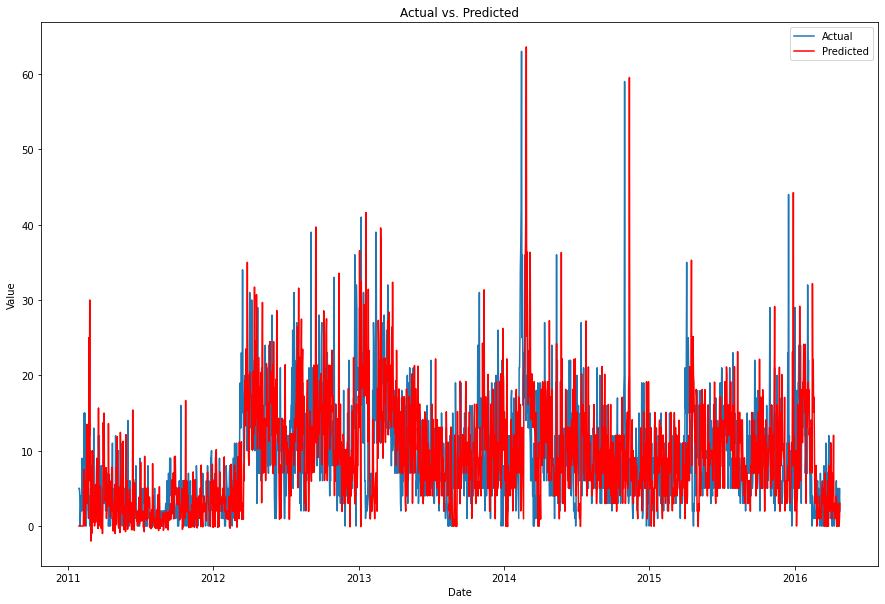

In [86]:
# Visualizing Predictions
# Plot actual vs. predicted
plt.figure(figsize=(15, 10))
plt.plot(storeTX1['sales'], label='Actual')
plt.plot(mean_predict, color='red', label='Predicted')
#plt.fill_between(conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

#### Evaluate model performance

In [46]:
#Train and Test data
split=int(len(storeTX1) * 0.8) 
train, test = storeTX1[0:split], storeTX1[split:len(storeTX1)]

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Generate forecasts for future periods
forecast_start = '2015-04-08'
forecast_end = '2016-04-24'
forecast = sarima_results.get_prediction(start=forecast_start, end=forecast_end)
# Extract the predicted mean values
mean_forecast = forecast.predicted_mean

#Model Performance Metrics
# Calculate MAE, RMSE, etc.
actual_values = storeTX1[forecast_start:forecast_end]
mae = mean_absolute_error(actual_values, mean_forecast)
rmse = np.sqrt(mean_squared_error(actual_values, mean_forecast))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 5.746488184842407
Root Mean Squared Error (RMSE): 7.857477174076914


The model's performance metrics (MAE and RMSE) are reasonable but could be further evaluated in comparison to alternative models.
In conclusion, while the model shows promise, further refinement and evaluation may be necessary to determine its effectiveness and suitability for the intended application.

##### ARIMA and SARIMA comparison:

The ARIMA model demonstrates better performance by its higher log likelihood, lower AIC/BIC values, and lower RMSE, indicating better forecasting accuracy. Both models exhibit satisfactory results regarding residual autocorrelation (Ljung-Box) and display similar levels of heteroskedasticity. An advantage of the ARIMA model lies in its simplicity and ease of interpretation due to its non-seasonal nature. On the other hand, the SARIMA model, while more complex due to its inclusion of seasonal effects, may offer improved accuracy, particularly for datasets with pronounced seasonal patterns. However, both models exhibit some weaknesses such as residual autocorrelation in SARIMAX and non-normality in ARIMA residuals, indicating areas for potential improvement or further model refinement.

### 3-3 ARIMAX Model

ARIMAX is an extension of the ARIMA model that allows for the inclusion of exogenous variables, which are additional time series that may influence the sales variable. ARIMAX can capture the impact of external factors like events, or price changes on sales.

In [9]:
# preparing Timeseries data with sales, event, and snap features for a store (TX_1)
stores_sarimax = sales_wal.groupby(['date', 'store_id']).agg({'sales': 'sum', 'snap': 'mean', 'event': 'mean'}).reset_index()
stores_sarimax['snap']=pd.to_numeric(stores_sarimax['snap'], downcast='integer')
stores_sarimax['event']=pd.to_numeric(stores_sarimax['event'], downcast='integer')
stores_sarimax['date'] = pd.to_datetime(stores_sarimax['date'], format='%m/%d/%y')
stores_sarimax.set_index('date',inplace=True)
stores_arimaxtx1=stores_sarimax[stores_sarimax['store_id']=='TX_1'][['sales','snap','event']]
stores_arimaxtx1

,sales,snap,event
date,,,
2011-01-29,5,0,0
2011-01-30,5,0,0
2011-01-31,4,0,0
2011-02-01,0,1,0
2011-02-02,2,0,0
...,...,...,...
2016-04-20,0,0,0
2016-04-21,2,0,0
2016-04-22,3,0,0


Find the best parameters for the ARIMAX model

In [ ]:
# Define the ARIMAX model
model = ARIMA(trainst1['sales'], order=(p, d, q), exog=trainst1[['event','snap']])

# Fit the model
fitted_model = model.fit()

# Make predictions on the test set
predictions = fitted_model.forecast(steps=len(testst1), exog=testst1[['event','snap']])

# Calculate MAE
mse = mean_squared_error(testst1['sales'], predictions)
print('Mean Squared Error:', mse)

In [17]:
#Split data into train and test sets (stores_arimaxtx1)
#asumming 20% test dataset
testsize=0.2 
split=int(len(stores_arimaxtx1)*(1-testsize))
trainst1x, testst1x= stores_arimaxtx1[0:split] , stores_arimaxtx1[split:len(stores_arimaxtx1)]

In [23]:
#Optimize Model Parameters

# Define parameter combinations to search
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)
#exog_combinations = list(product([None, trainst1x['event'], trainst1x['snap']], repeat=2))

best_mse = float('inf')
best_params = {}

# Perform grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            model = ARIMA(trainst1x['sales'], order=(p, d, q), exog=trainst1x[['event','snap']], freq='D')
            fitted_model = model.fit()
            predictions = fitted_model.forecast(steps=len(testst1x), exog=testst1x[['event','snap']])
            mse = mean_squared_error(testst1x['sales'], predictions)

            if mse < best_mse:
                best_mse = mse
                best_params = {'p': p, 'd': d, 'q': q,}
rmse=np.sqrt(best_mse)
print('Best Parameters:', best_params, 'Best rmse:', rmse)

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency inform

Best Parameters: {'p': 1, 'd': 0, 'q': 1} Best rmse: 6.054015723669724


/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Refit Model with Best Parameters

In [25]:
#Refit Model with best parameters: {1,0,1}
best_model = ARIMA(stores_arimaxtx1['sales'], order=(best_params['p'], best_params['d'], best_params['q']), exog=stores_arimaxtx1[['event', 'snap']],freq='D')
final_model = best_model.fit()

/Users/Arezoo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### Model summary

In [26]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5921.618
Date:                Tue, 23 Apr 2024   AIC                          11855.236
Time:                        13:26:08   BIC                          11888.575
Sample:                    01-29-2011   HQIC                         11867.505
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5384      0.966      8.843      0.000       6.646      10.431
event          1.1805      0.320      3.685      0.000       0.553       1.808
snap           1.0961      0.274      4.002      0.000       0.559       1.633
ar.L1          0.9511      0.010     97.239      0.000       0.932       0.970
ma.L1         -0.6964      0.017    -40.357      0.000      -0.730      -0.663
sigma2        28.5778      0.601     47.567      0.000      27.400      29.755
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):              3235.32
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Visualizing the model

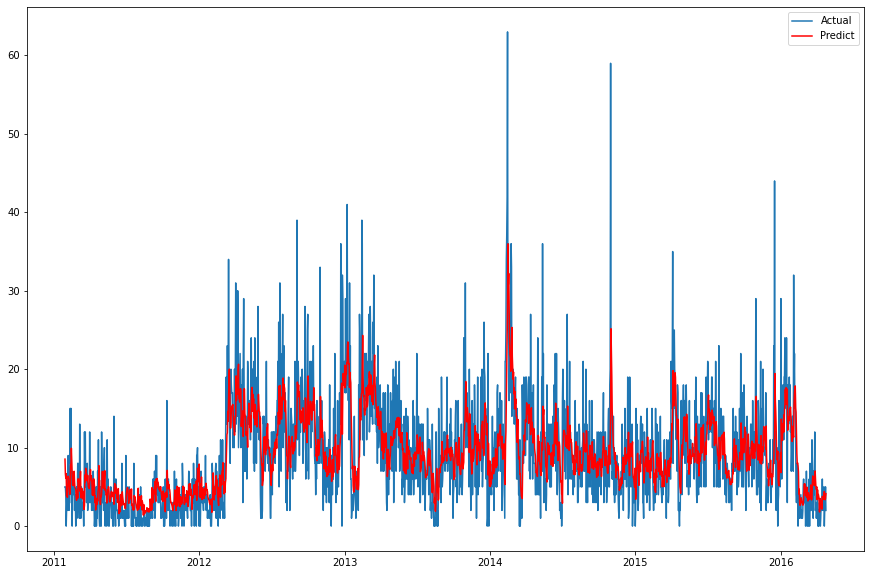

In [35]:
plt.figure(figsize=(15,10))
plt.plot(stores_arimaxtx1['sales'], label='Actual')
plt.plot(final_model.predict(steps=len(stores_arimaxtx1), exog=stores_arimaxtx1[['event','snap']]), color = 'red',label='Predict')
plt.legend()

In [468]:
# Fit ARIMAX model
model_ex = ARIMA(endog=train['sales'], exog=exog_train, order=(1, 1, 1))
model_ex_fit = model.fit()
 # Forecast
forecast_ex = model_ex_fit.forecast(steps=len(test), exog=exog_test)
# Evaluate the model
mse_ex = mean_squared_error(test['sales'], forecast_ex)
rmse_ex = mse_ex ** 0.5
print('RMSE:', rmse_ex)

RMSE: 9.487422643971476


The comparison between the ARIMAX (1, 0, 1) and ARIMA (2, 0, 1) models for forecasting sales reveals interesting insights. The ARIMAX model incorporates exogenous variables like events and snap, which slightly increases its complexity compared to the ARIMA model without exogenous factors. Despite this, the ARIMA model performs marginally better with a lower root mean squared error (RMSE) of 5.122, indicating superior predictive accuracy. Both models exhibit relatively similar log likelihood, AIC, and BIC values, suggesting comparable goodness of fit to the data. However, further analysis shows that the ARIMA model's residuals have a slightly better behavior, as indicated by the Ljung-Box test's p-value of 0.00, indicating no significant autocorrelation, and the Jarque-Bera test's p-value of 0.00, indicating non-normality in residuals. Therefore, based on these evaluations, the ARIMA model appears to be a more suitable choice for forecasting sales in this scenario.

### The Prophet Model

Prophet model Developed by Facebook, is designed to handle time series data with strong seasonal effects and multiple seasonality. It's robust to missing data and outliers, making it a popular choice for many applications. Additionally, Prophet can handle datasets with many zero values, which makes it particularly suitable for our data, where many zero sales occurrences are present.

##### Preparing data for the prohphet modle

Prophet model requires the data to be in a specific format with columns named ds (date/time) and y (numeric value to forecast).

In [9]:
storeTX1_pro=storeTX1.reset_index()
storeTX1_pro.rename(columns={'date': 'ds','sales':'y'}, inplace=True)
storeTX1_pro

,ds,y
0,2011-01-29,5
1,2011-01-30,5
2,2011-01-31,4
3,2011-02-01,0
4,2011-02-02,2
...,...,...
1908,2016-04-20,0
1909,2016-04-21,2
1910,2016-04-22,3
1911,2016-04-23,5


In [12]:
import matplotlib.pyplot as plt

In [10]:
#from prophet import Prophet
from prophet import Prophet

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(storeTX1_pro)

#Make predictions
future_dates = model.make_future_dataframe(periods=28)  # Forecasting 28 days into the future
forecast = model.predict(future_dates)

Importing plotly failed. Interactive plots will not work.
12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing


#### Visualize the Prophet model

In [16]:
forecast_prop=pd.read_csv('../Data/forecast_Prophet')
forecast_trimmed = forecast_prop.iloc[:len(storeTX1_pro)]

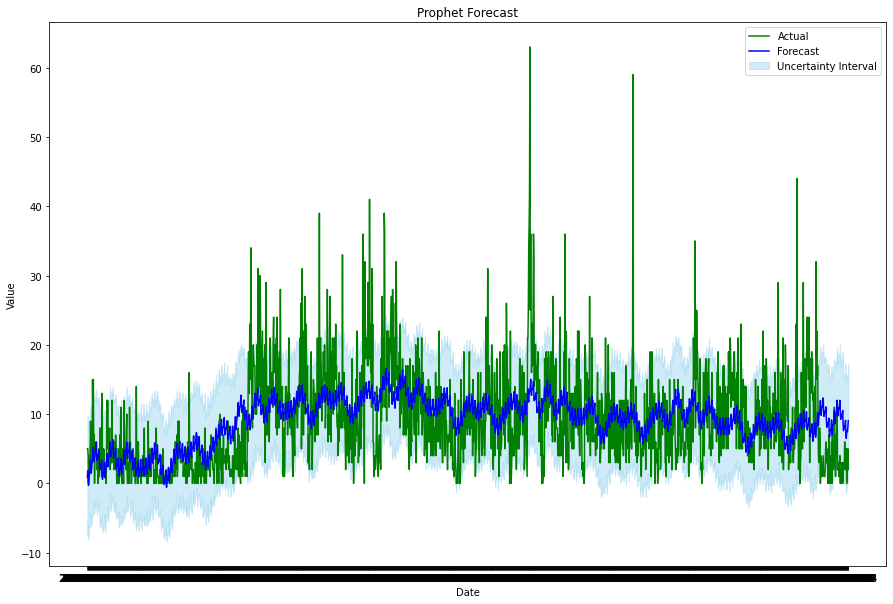

In [17]:
# Plot the forecast
#model.plot(forecast)
plt.figure(figsize=(15, 10))
plt.plot(forecast_trimmed['ds'].values, storeTX1_pro['y'].values, label='Actual', color='green')
plt.plot(forecast_trimmed['ds'].values, forecast_trimmed['yhat'].values, label='Forecast', color='blue')
plt.fill_between(forecast_trimmed['ds'].values, forecast_trimmed['yhat_lower'], forecast_trimmed['yhat_upper'], color='skyblue', alpha=0.4, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

#### Evaluate the perfomance of the model 

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [19]:
# Trim the forecast to match the length of actual data
forecast_trimmed = forecast_prop.iloc[:len(storeTX1_pro)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(storeTX1_pro['y'], forecast_trimmed['yhat']))
print('RMSE:', rmse)

RMSE: 6.064182768260556


### Hyperparameter tuning for the Prophet model 

In [11]:
from prophet.diagnostics import cross_validation
from sklearn.model_selection import ParameterGrid

In [67]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

# Define the parameter grid for tuning
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all possible combinations of parameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize TimeSeriesSplit for cross-validation
#cv = TimeSeriesSplit(n_splits=5)
split_date = '2015-04-08'
train_d=(storeTX1_pro['ds']<=split_date)
test_d=(storeTX1_pro['ds']>split_date)
train_data=storeTX1_pro.loc[train_d]
test_data=storeTX1_pro.loc[test_d]

#forecast_end = '2016-04-24'
# Initialize an empty list to store RMSE values
mean_rmse_scores = []

# Perform cross-validation with parameter tuning
for params in param_combinations:
    # Initialize an empty list to store RMSE scores for this parameter combination
    rmse_scores = []

    # Fit the Prophet model with the current parameter combination
    model = Prophet(**params)
    model.fit(train_data)

    # Make predictions for the validation period
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    trimmed_forecast=forecast.loc[test_d]

    # Calculate residuals and RMSE
    #residuals = trimmed_forecast['yhat'] - test_data['y'].values
    #rmse = np.sqrt(np.mean(residuals ** 2))
    rmse = np.sqrt(mean_squared_error(test_data['y'], trimmed_forecast['yhat']))
    rmse_scores.append(rmse)
    
    # Compute the mean RMSE across all folds for this parameter combination
    mean_rmse = np.mean(rmse_scores)
    mean_rmse_scores.append((params, mean_rmse))

# Find the parameter combination with the lowest mean RMSE
best_params, best_mean_rmse = min(mean_rmse_scores, key=lambda x: x[1])

print('Best Parameters:', best_params)
print('Best Mean RMSE:', best_mean_rmse)


16:55:36 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
16:55:38 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing
16:55:38 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:40 - cmdstanpy - INFO - Chain [1] start processing
16:55:40 - cmdstanpy - INFO - Chain [1] done processing
16:55:40 - cmdstanpy - INFO - Chain [1] start processing
16:55:40 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best Mean RMSE: 6.161215449235872


The tunning process on 'changepoint_prior_scale', 'holidays_prior_scale', 'seasonality_mode', and 'seasonality_prior_scale' variables show the best model is achieved for the following parameters:{ 'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}

In [15]:
# Create a Prophet model
model = Prophet(changepoint_prior_scale= 0.01, holidays_prior_scale= 0.1, seasonality_mode= 'multiplicative',seasonality_prior_scale= 0.01)

# Fit the model to the data
model.fit(storeTX1_pro)

#Make predictions
future_dates = model.make_future_dataframe(periods=28)  # Forecasting 28 days into the future
forecast = model.predict(future_dates)

# Trim the forecast to match the length of actual data
forecast_trimmed = forecast.iloc[:len(storeTX1_pro)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(storeTX1_pro['y'], forecast_trimmed['yhat']))

# Calculate R2 score
r2 = r2_score(storeTX1_pro['y'], forecast_trimmed['yhat'])

print('RMSE:', rmse, 'R2:',r2)

12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 6.3097447424800155 R2: 0.17866398519694016


The RMSE value of 6.31 indicates that, on average, the Prophet model's predictions are off by approximately 6.31 units from the actual values. In other words, the model's accuracy in predicting the target variable is moderate.

The R-squared (R2) value of 0.18 indicates that approximately 18% of the variance in the target variable is explained by the model. A higher R-squared value closer to 1 indicates a better fit of the model to the data, while a lower value suggests that the model does not explain much of the variance in the data.

Overall, based on these metrics, the Prophet model performs moderately in predicting the target variable, capturing some but not all of the variability in the data. Further model evaluation and refinement may be necessary to improve predictive performance.

### Summary

Overall, based on the RMSE, the ARIMA model appears to have the best predictive performance among the three models. However, a comprehensive comparison would require additional metrics and evaluation on test data to determine the most suitable model. The computational complexity of each model can vary. Prophet is known for its ease of use and automatic feature selection, making it simpler for users. On the other hand, ARIMA and SARIMA models may require more manual tuning and expertise but can offer flexibility in modeling various time series patterns.